In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
bilstm_model = create_bilstm()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

bilstm_history = bilstm_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
bilstm_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = bilstm_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

2023-03-26 12:30:03.649680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 12:30:03.834044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 12:30:03.836136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 12:30:04.586480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-26 12:30:10.780664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-26 12:30:10.992149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor 

Epoch 1/10


2023-03-26 12:30:11.104295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-26 12:30:11.143221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:30:11.144335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

479/479 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.8096

2023-03-26 12:30:49.842108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:30:49.843227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:30:49.844450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

479/479 [==============================] - 40s 78ms/step - loss: 0.5208 - accuracy: 0.8096 - val_loss: 0.3841 - val_accuracy: 0.8643
Epoch 2/10
479/479 [==============================] - 36s 75ms/step - loss: 0.2436 - accuracy: 0.9137 - val_loss: 0.3433 - val_accuracy: 0.8793
Epoch 3/10
479/479 [==============================] - 36s 76ms/step - loss: 0.1902 - accuracy: 0.9353 - val_loss: 0.3473 - val_accuracy: 0.8877
Epoch 4/10
479/479 [==============================] - 37s 78ms/step - loss: 0.1563 - accuracy: 0.9449 - val_loss: 0.3648 - val_accuracy: 0.8850
Epoch 5/10
479/479 [==============================] - 37s 78ms/step - loss: 0.1378 - accuracy: 0.9536 - val_loss: 0.3734 - val_accuracy: 0.8884
Epoch 6/10
479/479 [==============================] - 38s 78ms/step - loss: 0.1271 - accuracy: 0.9589 - val_loss: 0.3625 - val_accuracy: 0.8938
Epoch 7/10
479/479 [==============================] - 38s 79ms/step - loss: 0.1076 - accuracy: 0.9647 - val_loss: 0.3791 - val_accuracy: 0.8922
Epo

2023-03-26 12:36:27.426154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:36:27.427301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:36:27.428272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       501
           1       0.89      0.88      0.88       823
           2       0.87      0.87      0.87       974
           3       0.93      0.93      0.93       319

    accuracy                           0.88      2617
   macro avg       0.88      0.89      0.89      2617
weighted avg       0.88      0.88      0.88      2617



In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
lstm_model = create_lstm()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

lstm_history = lstm_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
lstm_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = lstm_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

Epoch 1/10


2023-03-26 12:40:35.621870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:40:35.623158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:40:35.624119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

479/479 [==============================] - ETA: 0s - loss: 0.5388 - accuracy: 0.8014

2023-03-26 12:41:08.371525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:41:08.373272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:41:08.374234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

479/479 [==============================] - 34s 67ms/step - loss: 0.5388 - accuracy: 0.8014 - val_loss: 0.3756 - val_accuracy: 0.8636
Epoch 2/10
479/479 [==============================] - 32s 67ms/step - loss: 0.2467 - accuracy: 0.9130 - val_loss: 0.3693 - val_accuracy: 0.8682
Epoch 3/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1931 - accuracy: 0.9343 - val_loss: 0.3698 - val_accuracy: 0.8708
Epoch 4/10
479/479 [==============================] - 32s 66ms/step - loss: 0.1620 - accuracy: 0.9448 - val_loss: 0.3529 - val_accuracy: 0.8804
Epoch 5/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1418 - accuracy: 0.9523 - val_loss: 0.3743 - val_accuracy: 0.8846
Epoch 6/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1241 - accuracy: 0.9585 - val_loss: 0.3921 - val_accuracy: 0.8892
Epoch 7/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1086 - accuracy: 0.9653 - val_loss: 0.3737 - val_accuracy: 0.8877
Epo

2023-03-26 12:45:57.217519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:45:57.218648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:45:57.219672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       501
           1       0.89      0.88      0.88       823
           2       0.88      0.86      0.87       974
           3       0.92      0.92      0.92       319

    accuracy                           0.88      2617
   macro avg       0.88      0.89      0.89      2617
weighted avg       0.88      0.88      0.88      2617



In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
cnn_model = create_cnn()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

cnn_history = cnn_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
cnn_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = cnn_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

2023-03-26 13:27:59.807078: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 13:27:59.844214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 13:27:59.845087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 13:28:00.422010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10


2023-03-26 13:28:06.077501: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


479/479 [==============================] - 22s 46ms/step - loss: 0.5726 - accuracy: 0.7808 - val_loss: 0.3636 - val_accuracy: 0.8643
Epoch 2/10
479/479 [==============================] - 22s 46ms/step - loss: 0.2090 - accuracy: 0.9264 - val_loss: 0.3236 - val_accuracy: 0.8907
Epoch 3/10
479/479 [==============================] - 22s 46ms/step - loss: 0.1324 - accuracy: 0.9542 - val_loss: 0.3490 - val_accuracy: 0.8877
Epoch 4/10
479/479 [==============================] - 21s 43ms/step - loss: 0.0959 - accuracy: 0.9689 - val_loss: 0.3577 - val_accuracy: 0.8884
Epoch 5/10
479/479 [==============================] - 22s 47ms/step - loss: 0.0689 - accuracy: 0.9779 - val_loss: 0.3678 - val_accuracy: 0.8919
Epoch 6/10
479/479 [==============================] - 20s 42ms/step - loss: 0.0523 - accuracy: 0.9832 - val_loss: 0.4104 - val_accuracy: 0.8945
Epoch 7/10
479/479 [==============================] - 20s 42ms/step - loss: 0.0461 - accuracy: 0.9859 - val_loss: 0.4369 - val_accuracy: 0.8980
Epo

In [10]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, Dense


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return rnn_model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
rnn_model = create_rnn()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

rnn_history = rnn_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
rnn_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = rnn_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

Epoch 1/10
479/479 [==============================] - 19s 38ms/step - loss: 0.6065 - accuracy: 0.7616 - val_loss: 0.4268 - val_accuracy: 0.8441
Epoch 2/10
479/479 [==============================] - 18s 38ms/step - loss: 0.2447 - accuracy: 0.9146 - val_loss: 0.3838 - val_accuracy: 0.8617
Epoch 3/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1776 - accuracy: 0.9366 - val_loss: 0.4071 - val_accuracy: 0.8647
Epoch 4/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1379 - accuracy: 0.9523 - val_loss: 0.4380 - val_accuracy: 0.8544
Epoch 5/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1127 - accuracy: 0.9613 - val_loss: 0.4717 - val_accuracy: 0.8582
Epoch 6/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1054 - accuracy: 0.9638 - val_loss: 0.8283 - val_accuracy: 0.7390
Epoch 7/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1584 - accuracy: 0.9447 - val_loss: 0.5090 - val_accuracy:

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, Dense


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

2023-03-26 14:13:27.458573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 14:13:27.493356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 14:13:27.493968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 14:13:28.033765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return rnn_model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
rnn_model = create_rnn()

2023-03-26 14:13:37.346256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
nn_history = rnn_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
rnn_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = rnn_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

Epoch 1/10
479/479 [==============================] - 20s 40ms/step - loss: 0.6179 - accuracy: 0.7542 - val_loss: 0.3796 - val_accuracy: 0.8586
Epoch 2/10
479/479 [==============================] - 19s 40ms/step - loss: 0.2386 - accuracy: 0.9156 - val_loss: 0.3632 - val_accuracy: 0.8705
Epoch 3/10
479/479 [==============================] - 19s 40ms/step - loss: 0.1899 - accuracy: 0.9336 - val_loss: 0.4636 - val_accuracy: 0.8338
Epoch 4/10
479/479 [==============================] - 19s 40ms/step - loss: 0.1509 - accuracy: 0.9476 - val_loss: 0.4116 - val_accuracy: 0.8678
Epoch 5/10
479/479 [==============================] - 19s 40ms/step - loss: 0.1125 - accuracy: 0.9618 - val_loss: 0.4694 - val_accuracy: 0.8582
Epoch 6/10
479/479 [==============================] - 20s 41ms/step - loss: 0.1670 - accuracy: 0.9401 - val_loss: 0.4585 - val_accuracy: 0.8441
Epoch 7/10
479/479 [==============================] - 19s 41ms/step - loss: 0.1684 - accuracy: 0.9386 - val_loss: 0.5257 - val_accuracy:

OVERSAMPLED


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score




# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model





y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values





# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}
for name, model in models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 5
batch_size = 32


# Evaluate the models on the test set

    
for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} model accuracy: {acc}')
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))   
    
  


2023-03-26 16:10:41.738941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:10:41.740051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:10:41.741010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/5


2023-03-26 16:10:42.012487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-26 16:10:42.045477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:10:42.046618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

383/383 [==============================] - 16s 39ms/step - loss: 0.3151 - accuracy: 0.7214 - val_loss: 0.1171 - val_accuracy: 0.9262
Epoch 2/5
383/383 [==============================] - 15s 39ms/step - loss: 0.1479 - accuracy: 0.8888 - val_loss: 0.0914 - val_accuracy: 0.9386
Epoch 3/5
383/383 [==============================] - 15s 39ms/step - loss: 0.1144 - accuracy: 0.9190 - val_loss: 0.1041 - val_accuracy: 0.9236
Epoch 4/5
383/383 [==============================] - 15s 39ms/step - loss: 0.0897 - accuracy: 0.9369 - val_loss: 0.0766 - val_accuracy: 0.9491
Epoch 5/5
82/82 [==============================] - 0s 5ms/step
rnn model confusion matrix:
[[457  10  31   3]
 [ 23 743  56   1]
 [ 65 106 800   3]
 [  7  12  13 287]]
rnn model accuracy: 0.8739014138326328
rnn model classification report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       501
           1       0.85      0.90      0.88       823
           2       0.89      0.82  

2023-03-26 16:13:28.852767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:13:28.854374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:13:28.855657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.7065

2023-03-26 16:13:53.138384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:13:53.139415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:13:53.140337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 25s 63ms/step - loss: 0.3200 - accuracy: 0.7065 - val_loss: 0.1030 - val_accuracy: 0.9337
Epoch 2/5
383/383 [==============================] - 24s 63ms/step - loss: 0.1472 - accuracy: 0.8907 - val_loss: 0.0622 - val_accuracy: 0.9631
Epoch 3/5
383/383 [==============================] - 24s 62ms/step - loss: 0.1124 - accuracy: 0.9190 - val_loss: 0.0555 - val_accuracy: 0.9634
Epoch 4/5
383/383 [==============================] - 24s 63ms/step - loss: 0.0942 - accuracy: 0.9341 - val_loss: 0.0564 - val_accuracy: 0.9664
Epoch 5/5
 7/82 [=>............................] - ETA: 0s 

2023-03-26 16:15:30.821402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:15:30.822455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:15:30.823571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 10ms/step
lstm model confusion matrix:
[[449  12  36   4]
 [ 23 703  91   6]
 [ 49  37 885   3]
 [  4   7  21 287]]
lstm model accuracy: 0.8880397401604891
lstm model classification report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       501
           1       0.93      0.85      0.89       823
           2       0.86      0.91      0.88       974
           3       0.96      0.90      0.93       319

    accuracy                           0.89      2617
   macro avg       0.90      0.89      0.89      2617
weighted avg       0.89      0.89      0.89      2617

Training bilstm model...
Epoch 1/5


2023-03-26 16:15:31.926898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:15:31.928851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:15:31.930043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.7062

2023-03-26 16:16:02.206270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:16:02.207502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:16:02.208313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 32s 78ms/step - loss: 0.3215 - accuracy: 0.7062 - val_loss: 0.1074 - val_accuracy: 0.9351
Epoch 2/5
383/383 [==============================] - 29s 76ms/step - loss: 0.1457 - accuracy: 0.8944 - val_loss: 0.0682 - val_accuracy: 0.9510
Epoch 3/5
383/383 [==============================] - 30s 80ms/step - loss: 0.1144 - accuracy: 0.9180 - val_loss: 0.0580 - val_accuracy: 0.9608
Epoch 4/5
383/383 [==============================] - 31s 81ms/step - loss: 0.0960 - accuracy: 0.9335 - val_loss: 0.0535 - val_accuracy: 0.9634
Epoch 5/5
383/383 [==============================] - 32s 83ms/step - loss: 0.0839 - accuracy: 0.9443 - val_loss: 0.0632 - val_accuracy: 0.9576


2023-03-26 16:18:05.874627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:18:05.876116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:18:05.877351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 12ms/step
bilstm model confusion matrix:
[[453   8  35   5]
 [ 39 694  87   3]
 [ 58  39 873   4]
 [  8   6  14 291]]
bilstm model accuracy: 0.8830722200993504
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       501
           1       0.93      0.84      0.88       823
           2       0.87      0.90      0.88       974
           3       0.96      0.91      0.94       319

    accuracy                           0.88      2617
   macro avg       0.89      0.89      0.89      2617
weighted avg       0.89      0.88      0.88      2617



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense



# Load the data
df = pd.read_csv('final_project_cleaned.csv')

2023-03-26 17:43:15.652434: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 17:43:15.689131: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 17:43:15.690221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 17:43:16.298740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other
...,...,...
13079,Can you tell me what the disposable cards are ...,card_queries_or_issues
13080,The ATM won't give me my card back. I need it ...,card_queries_or_issues
13081,Can you please tell me why my card payments ar...,card_queries_or_issues
13082,The rate for a currency exchange was wrong whe...,needs_troubleshooting


2023-03-26 17:14:02.202934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:14:02.204323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:14:02.205391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/10


2023-03-26 17:14:02.474030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-26 17:14:02.506755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:14:02.507755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

383/383 [==============================] - 16s 39ms/step - loss: 0.3581 - accuracy: 0.6606 - val_loss: 0.1602 - val_accuracy: 0.8822
Epoch 2/10
383/383 [==============================] - 15s 39ms/step - loss: 0.1513 - accuracy: 0.8888 - val_loss: 0.0927 - val_accuracy: 0.9416
Epoch 3/10
383/383 [==============================] - 15s 39ms/step - loss: 0.1159 - accuracy: 0.9177 - val_loss: 0.0622 - val_accuracy: 0.9556
Epoch 4/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0930 - accuracy: 0.9329 - val_loss: 0.0674 - val_accuracy: 0.9533
Epoch 5/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0793 - accuracy: 0.9442 - val_loss: 0.0445 - val_accuracy: 0.9693
Epoch 6/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0696 - accuracy: 0.9541 - val_loss: 0.0739 - val_accuracy: 0.9458
Epoch 7/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0620 - accuracy: 0.9589 - val_loss: 0.0406 - val_accuracy: 0.9729
Epo

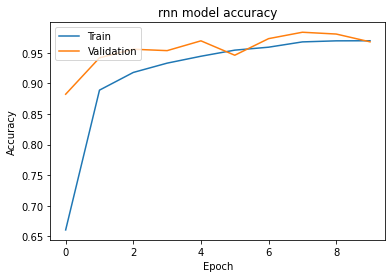

Training cnn model...
Epoch 1/10
383/383 [==============================] - 18s 46ms/step - loss: 0.3712 - accuracy: 0.6471 - val_loss: 0.2023 - val_accuracy: 0.8411
Epoch 2/10
383/383 [==============================] - 18s 46ms/step - loss: 0.1464 - accuracy: 0.8937 - val_loss: 0.1244 - val_accuracy: 0.9057
Epoch 3/10
383/383 [==============================] - 18s 46ms/step - loss: 0.1011 - accuracy: 0.9304 - val_loss: 0.0861 - val_accuracy: 0.9308
Epoch 4/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0754 - accuracy: 0.9482 - val_loss: 0.0457 - val_accuracy: 0.9710
Epoch 5/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0582 - accuracy: 0.9614 - val_loss: 0.0406 - val_accuracy: 0.9762
Epoch 6/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0449 - accuracy: 0.9703 - val_loss: 0.0259 - val_accuracy: 0.9840
Epoch 7/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0358 - accuracy: 0.9775 - val_loss: 

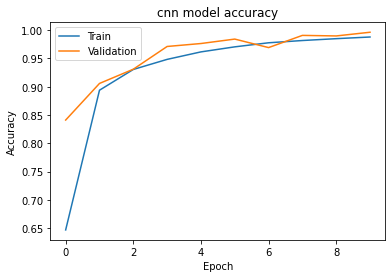

Training lstm model...
Epoch 1/10


2023-03-26 17:19:32.162359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:19:32.163983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:19:32.165305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.7022

2023-03-26 17:19:56.518129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:19:56.519589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:19:56.520773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 26s 63ms/step - loss: 0.3248 - accuracy: 0.7022 - val_loss: 0.1346 - val_accuracy: 0.9083
Epoch 2/10
383/383 [==============================] - 24s 63ms/step - loss: 0.1446 - accuracy: 0.8960 - val_loss: 0.0913 - val_accuracy: 0.9360
Epoch 3/10
383/383 [==============================] - 25s 64ms/step - loss: 0.1151 - accuracy: 0.9154 - val_loss: 0.0877 - val_accuracy: 0.9406
Epoch 4/10
383/383 [==============================] - 24s 63ms/step - loss: 0.0932 - accuracy: 0.9363 - val_loss: 0.0849 - val_accuracy: 0.9373
Epoch 5/10
383/383 [==============================] - 24s 64ms/step - loss: 0.0803 - accuracy: 0.9449 - val_loss: 0.0447 - val_accuracy: 0.9700
Epoch 6/10
383/383 [==============================] - 25s 66ms/step - loss: 0.0707 - accuracy: 0.9528 - val_loss: 0.0496 - val_accuracy: 0.9687
Epoch 7/10
383/383 [==============================] - 25s 65ms/step - loss: 0.0630 - accuracy: 0.9580 - val_loss: 0.0503 - val_accuracy: 0.9726
Epo

2023-03-26 17:23:41.658377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:23:41.659456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:23:41.660408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 11ms/step
lstm model confusion matrix:
[[446  16  31   8]
 [ 19 717  76  11]
 [ 39  46 879  10]
 [  2   5  10 302]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       501
           1       0.91      0.87      0.89       823
           2       0.88      0.90      0.89       974
           3       0.91      0.95      0.93       319

    accuracy                           0.90      2617
   macro avg       0.90      0.90      0.90      2617
weighted avg       0.90      0.90      0.90      2617

lstm model accuracy: 0.8957
lstm model precision: 0.8977
lstm model recall: 0.9026


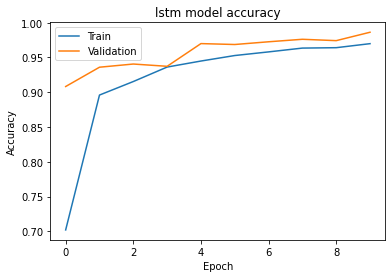

Training bilstm model...
Epoch 1/10


2023-03-26 17:23:43.031252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:23:43.032503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:23:43.033485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.7234

2023-03-26 17:24:13.271876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:24:13.273228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:24:13.274451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 32s 78ms/step - loss: 0.3104 - accuracy: 0.7234 - val_loss: 0.1424 - val_accuracy: 0.9164
Epoch 2/10
383/383 [==============================] - 31s 80ms/step - loss: 0.1422 - accuracy: 0.8963 - val_loss: 0.0577 - val_accuracy: 0.9615
Epoch 3/10
383/383 [==============================] - 31s 81ms/step - loss: 0.1098 - accuracy: 0.9214 - val_loss: 0.0656 - val_accuracy: 0.9586
Epoch 4/10
383/383 [==============================] - 30s 79ms/step - loss: 0.0932 - accuracy: 0.9336 - val_loss: 0.0603 - val_accuracy: 0.9579
Epoch 5/10
383/383 [==============================] - 30s 77ms/step - loss: 0.0809 - accuracy: 0.9447 - val_loss: 0.0465 - val_accuracy: 0.9749
Epoch 6/10
383/383 [==============================] - 30s 78ms/step - loss: 0.0698 - accuracy: 0.9525 - val_loss: 0.0561 - val_accuracy: 0.9664
Epoch 7/10
383/383 [==============================] - 30s 77ms/step - loss: 0.0621 - accuracy: 0.9579 - val_loss: 0.0513 - val_accuracy: 0.9680
Epo

2023-03-26 17:28:45.427276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:28:45.428777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:28:45.429794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 12ms/step
bilstm model confusion matrix:
[[443  14  40   4]
 [ 19 738  62   4]
 [ 37  62 872   3]
 [  4   6  12 297]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       501
           1       0.90      0.90      0.90       823
           2       0.88      0.90      0.89       974
           3       0.96      0.93      0.95       319

    accuracy                           0.90      2617
   macro avg       0.91      0.90      0.90      2617
weighted avg       0.90      0.90      0.90      2617

bilstm model accuracy: 0.8980
bilstm model precision: 0.9073
bilstm model recall: 0.9018


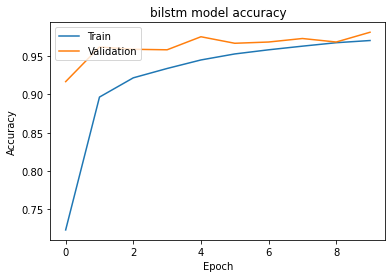

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense



# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model





y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values





# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}
for name, model in models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
  


In [7]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.2, 0.3],
    'max_seq_length': [50, 100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Epoch 1/5


/tmp/ipykernel_8207/2804649030.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
10/32 [========>.....................] - ETA: 0s - loss: 0.6298 - accuracy: 0.3938

KeyboardInterrupt: 

In [5]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.3],
    'max_seq_length': [100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/5


/tmp/ipykernel_16058/2702622369.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


32/32 [==============================] - 2s 25ms/step - loss: 0.5831 - accuracy: 0.3620
Epoch 2/5
32/32 [==============================] - 1s 25ms/step - loss: 0.4976 - accuracy: 0.3970
Epoch 3/5
32/32 [==============================] - 1s 25ms/step - loss: 0.4491 - accuracy: 0.4940
Epoch 4/5
32/32 [==============================] - 1s 25ms/step - loss: 0.3527 - accuracy: 0.6500
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 1.1046 - accuracy: 0.0220
Epoch 1/5
32/32 [==============================] - 2s 26ms/step - loss: 0.5964 - accuracy: 0.3670
Epoch 2/5
32/32 [==============================] - 1s 26ms/step - loss: 0.5180 - accuracy: 0.4250
Epoch 3/5
32/32 [==============================] - 1s 26ms/step - loss: 0.4963 - accuracy: 0.5180
Epoch 4/5
32/32 [==============================] - 1s 27ms/step - loss: 0.4383 - accuracy: 0.6310
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 0.7155 - accuracy: 0.0820
Epoch 1/5
32/32 [===============

In [9]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

/tmp/ipykernel_8598/3319202629.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)
2023-03-29 19:25:29.130409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:29.131488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/5


2023-03-29 19:25:29.345824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:29.347027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:25:29.347992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 61ms/step - loss: 0.5676 - accuracy: 0.3660
Epoch 2/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4713 - accuracy: 0.4520
Epoch 3/5
32/32 [==============================] - 2s 61ms/step - loss: 0.3742 - accuracy: 0.6560
Epoch 4/5
32/32 [==============================] - 2s 60ms/step - loss: 0.2404 - accuracy: 0.8150
Epoch 5/5
 6/16 [==========>...................] - ETA: 0s - loss: 1.9114 - accuracy: 0.0000e+00

2023-03-29 19:25:40.838413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:40.839666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:25:40.840835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 11ms/step - loss: 1.5158 - accuracy: 0.1760
Epoch 1/5


2023-03-29 19:25:41.290315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:41.291898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:25:41.293084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 3s 61ms/step - loss: 0.5907 - accuracy: 0.3860
Epoch 2/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4997 - accuracy: 0.5310
Epoch 3/5
32/32 [==============================] - 2s 60ms/step - loss: 0.3882 - accuracy: 0.6950
Epoch 4/5
32/32 [==============================] - 2s 60ms/step - loss: 0.2876 - accuracy: 0.7440
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.5981 - accuracy: 0.3125

2023-03-29 19:25:52.563377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:52.564650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:25:52.565645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 0.6240 - accuracy: 0.3480
Epoch 1/5


2023-03-29 19:25:52.995743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:52.996851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:25:52.997866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 3s 61ms/step - loss: 0.5718 - accuracy: 0.3540
Epoch 2/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4769 - accuracy: 0.4410
Epoch 3/5
32/32 [==============================] - 2s 61ms/step - loss: 0.3707 - accuracy: 0.6790
Epoch 4/5
32/32 [==============================] - 2s 61ms/step - loss: 0.2450 - accuracy: 0.8020
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.3563 - accuracy: 0.6875

2023-03-29 19:26:04.269682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:04.270834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:04.271795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.5328 - accuracy: 0.1700
Epoch 1/5


2023-03-29 19:26:04.716718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:04.718130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:04.719146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 111ms/step - loss: 0.5555 - accuracy: 0.3420
Epoch 2/5
32/32 [==============================] - 4s 110ms/step - loss: 0.4831 - accuracy: 0.4050
Epoch 3/5
32/32 [==============================] - 4s 110ms/step - loss: 0.4203 - accuracy: 0.5880
Epoch 4/5
32/32 [==============================] - 4s 110ms/step - loss: 0.2701 - accuracy: 0.7700
Epoch 5/5
 7/16 [============>.................] - ETA: 0s - loss: 1.9409 - accuracy: 0.0000e+00

2023-03-29 19:26:23.893485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:23.894912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:23.895855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.5729 - accuracy: 0.1320
Epoch 1/5


2023-03-29 19:26:24.338004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:24.339423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:24.340571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 114ms/step - loss: 0.5740 - accuracy: 0.3960
Epoch 2/5
32/32 [==============================] - 4s 114ms/step - loss: 0.5125 - accuracy: 0.4500
Epoch 3/5
32/32 [==============================] - 4s 113ms/step - loss: 0.4059 - accuracy: 0.7030
Epoch 4/5
32/32 [==============================] - 4s 113ms/step - loss: 0.2876 - accuracy: 0.7470
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.6544 - accuracy: 0.2188

2023-03-29 19:26:44.067095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:44.068485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:44.069772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 0.6504 - accuracy: 0.2880
Epoch 1/5


2023-03-29 19:26:44.515475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:44.516796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:44.517886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 113ms/step - loss: 0.5690 - accuracy: 0.3590
Epoch 2/5
32/32 [==============================] - 4s 113ms/step - loss: 0.4784 - accuracy: 0.4230
Epoch 3/5
32/32 [==============================] - 4s 112ms/step - loss: 0.4089 - accuracy: 0.6430
Epoch 4/5
32/32 [==============================] - 4s 112ms/step - loss: 0.2805 - accuracy: 0.7520
Epoch 5/5
 7/16 [============>.................] - ETA: 0s - loss: 1.1038 - accuracy: 0.3304

2023-03-29 19:27:04.085375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:04.086809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:04.087731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.5565 - accuracy: 0.1480
Epoch 1/5


2023-03-29 19:27:04.523347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:04.524518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:04.525612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 85ms/step - loss: 0.5392 - accuracy: 0.3900
Epoch 2/5
32/32 [==============================] - 3s 85ms/step - loss: 0.4766 - accuracy: 0.4300
Epoch 3/5
32/32 [==============================] - 3s 85ms/step - loss: 0.3930 - accuracy: 0.6200
Epoch 4/5
32/32 [==============================] - 3s 85ms/step - loss: 0.2388 - accuracy: 0.8020
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 2.3306 - accuracy: 0.0000e+00

2023-03-29 19:27:20.222719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:20.223990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:20.225081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 1.7884 - accuracy: 0.1880
Epoch 1/5


2023-03-29 19:27:20.784433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:20.785613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:20.786810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 85ms/step - loss: 0.5716 - accuracy: 0.3880
Epoch 2/5
32/32 [==============================] - 3s 85ms/step - loss: 0.5068 - accuracy: 0.4820
Epoch 3/5
32/32 [==============================] - 3s 86ms/step - loss: 0.4034 - accuracy: 0.6840
Epoch 4/5
32/32 [==============================] - 3s 86ms/step - loss: 0.2705 - accuracy: 0.7530
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.6457 - accuracy: 0.3125

2023-03-29 19:27:36.037220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:36.038540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:36.039389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 18ms/step - loss: 0.6785 - accuracy: 0.3400
Epoch 1/5


2023-03-29 19:27:36.594234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:36.595582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:36.596450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 86ms/step - loss: 0.5422 - accuracy: 0.3670
Epoch 2/5
32/32 [==============================] - 3s 85ms/step - loss: 0.4321 - accuracy: 0.5600
Epoch 3/5
32/32 [==============================] - 3s 86ms/step - loss: 0.3036 - accuracy: 0.7240
Epoch 4/5
32/32 [==============================] - 3s 86ms/step - loss: 0.2217 - accuracy: 0.8140
Epoch 5/5
 4/16 [======>.......................] - ETA: 0s - loss: 0.4751 - accuracy: 0.6172

2023-03-29 19:27:51.867698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:51.868849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:51.869744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 1.5901 - accuracy: 0.1580
Epoch 1/5


2023-03-29 19:27:52.430946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:52.432335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:52.433177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 141ms/step - loss: 0.5540 - accuracy: 0.3740
Epoch 2/5
32/32 [==============================] - 4s 140ms/step - loss: 0.4894 - accuracy: 0.4020
Epoch 3/5
32/32 [==============================] - 5s 142ms/step - loss: 0.4230 - accuracy: 0.5890
Epoch 4/5
32/32 [==============================] - 5s 142ms/step - loss: 0.2689 - accuracy: 0.7690
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 2.0855 - accuracy: 0.0000e+00

2023-03-29 19:28:16.543718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:28:16.544764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:28:16.545722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 1.6311 - accuracy: 0.1700
Epoch 1/5


2023-03-29 19:28:17.107690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:28:17.108954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:28:17.109899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 140ms/step - loss: 0.5617 - accuracy: 0.4050
Epoch 2/5
32/32 [==============================] - 5s 141ms/step - loss: 0.4830 - accuracy: 0.5620
Epoch 3/5
32/32 [==============================] - 4s 139ms/step - loss: 0.3462 - accuracy: 0.7080
Epoch 4/5
32/32 [==============================] - 4s 140ms/step - loss: 0.2443 - accuracy: 0.7710
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.5841 - accuracy: 0.4062

2023-03-29 19:28:41.032513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:28:41.033729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:28:41.034945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 0.6392 - accuracy: 0.4160
Epoch 1/5


2023-03-29 19:28:41.602852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:28:41.603923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:28:41.604811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 143ms/step - loss: 0.5348 - accuracy: 0.3630
Epoch 2/5
32/32 [==============================] - 5s 143ms/step - loss: 0.4553 - accuracy: 0.4870
Epoch 3/5
32/32 [==============================] - 5s 140ms/step - loss: 0.3385 - accuracy: 0.6920
Epoch 4/5
32/32 [==============================] - 5s 141ms/step - loss: 0.2368 - accuracy: 0.7960
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.3392 - accuracy: 0.7188

2023-03-29 19:29:05.759716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:05.761315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:05.762647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 18ms/step - loss: 1.5980 - accuracy: 0.1840
Epoch 1/5


2023-03-29 19:29:06.316705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:06.317863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:06.319076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 62ms/step - loss: 0.5764 - accuracy: 0.3490
Epoch 2/5
32/32 [==============================] - 2s 64ms/step - loss: 0.4887 - accuracy: 0.3870
Epoch 3/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4211 - accuracy: 0.6030
Epoch 4/5
32/32 [==============================] - 2s 62ms/step - loss: 0.2529 - accuracy: 0.8360
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 1.8874 - accuracy: 0.0000e+00

2023-03-29 19:29:18.383864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:18.385279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:18.386586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.4911 - accuracy: 0.1900
Epoch 1/5


2023-03-29 19:29:18.830894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:18.832541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:18.833973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 3s 60ms/step - loss: 0.6013 - accuracy: 0.3590
Epoch 2/5
32/32 [==============================] - 2s 61ms/step - loss: 0.5211 - accuracy: 0.4190
Epoch 3/5
32/32 [==============================] - 2s 60ms/step - loss: 0.4544 - accuracy: 0.6200
Epoch 4/5
32/32 [==============================] - 2s 60ms/step - loss: 0.2766 - accuracy: 0.7820
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.4429 - accuracy: 0.6562

2023-03-29 19:29:30.042832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:30.044422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:30.045608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 0.5241 - accuracy: 0.4780
Epoch 1/5


2023-03-29 19:29:30.485124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:30.486130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:30.487196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 3s 60ms/step - loss: 0.5754 - accuracy: 0.3870
Epoch 2/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4864 - accuracy: 0.4300
Epoch 3/5
32/32 [==============================] - 2s 60ms/step - loss: 0.3992 - accuracy: 0.6540
Epoch 4/5
32/32 [==============================] - 2s 60ms/step - loss: 0.3023 - accuracy: 0.7250
Epoch 5/5
 6/16 [==========>...................] - ETA: 0s - loss: 1.0082 - accuracy: 0.2344

2023-03-29 19:29:41.685497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:41.686878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:41.687833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.5085 - accuracy: 0.0900
Epoch 1/5


2023-03-29 19:29:42.144632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:42.145725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:42.146665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 112ms/step - loss: 0.5711 - accuracy: 0.3570
Epoch 2/5
32/32 [==============================] - 4s 114ms/step - loss: 0.4825 - accuracy: 0.4120
Epoch 3/5
32/32 [==============================] - 4s 111ms/step - loss: 0.4039 - accuracy: 0.6540
Epoch 4/5
32/32 [==============================] - 4s 113ms/step - loss: 0.2419 - accuracy: 0.8490
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 2.2090 - accuracy: 0.0000e+00

2023-03-29 19:30:01.673430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:01.674904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:01.675831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.7272 - accuracy: 0.1840
Epoch 1/5


2023-03-29 19:30:02.122528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:02.124014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:02.125205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 112ms/step - loss: 0.5790 - accuracy: 0.4040
Epoch 2/5
32/32 [==============================] - 4s 111ms/step - loss: 0.5020 - accuracy: 0.5070
Epoch 3/5
32/32 [==============================] - 4s 111ms/step - loss: 0.3663 - accuracy: 0.7160
Epoch 4/5
32/32 [==============================] - 4s 110ms/step - loss: 0.2547 - accuracy: 0.7570
Epoch 5/5
 6/16 [==========>...................] - ETA: 0s - loss: 0.5435 - accuracy: 0.2552

2023-03-29 19:30:21.460508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:21.461924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:21.463151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 0.5719 - accuracy: 0.3960
Epoch 1/5


2023-03-29 19:30:21.907678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:21.908674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:21.909639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 112ms/step - loss: 0.5624 - accuracy: 0.3860
Epoch 2/5
32/32 [==============================] - 4s 114ms/step - loss: 0.4748 - accuracy: 0.4590
Epoch 3/5
32/32 [==============================] - 4s 113ms/step - loss: 0.3794 - accuracy: 0.6720
Epoch 4/5
32/32 [==============================] - 4s 114ms/step - loss: 0.2759 - accuracy: 0.7670
Epoch 5/5
 6/16 [==========>...................] - ETA: 0s - loss: 0.8905 - accuracy: 0.4688

2023-03-29 19:30:43.785020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:43.786411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:43.787570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.5121 - accuracy: 0.1800
Epoch 1/5


2023-03-29 19:30:44.229118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:44.230225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:44.231239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 88ms/step - loss: 0.5477 - accuracy: 0.3760
Epoch 2/5
32/32 [==============================] - 3s 87ms/step - loss: 0.4812 - accuracy: 0.4150
Epoch 3/5
32/32 [==============================] - 3s 89ms/step - loss: 0.3926 - accuracy: 0.6280
Epoch 4/5
32/32 [==============================] - 3s 87ms/step - loss: 0.2368 - accuracy: 0.8410
Epoch 5/5
 1/16 [>.............................] - ETA: 11s - loss: 2.3610 - accuracy: 0.0000e+00

2023-03-29 19:31:00.290746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:00.292269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:00.293389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 1.8895 - accuracy: 0.1360
Epoch 1/5


2023-03-29 19:31:00.874452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:00.875917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:00.877234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 85ms/step - loss: 0.5522 - accuracy: 0.4060
Epoch 2/5
32/32 [==============================] - 3s 86ms/step - loss: 0.4966 - accuracy: 0.5010
Epoch 3/5
32/32 [==============================] - 3s 86ms/step - loss: 0.3293 - accuracy: 0.7230
Epoch 4/5
32/32 [==============================] - 3s 85ms/step - loss: 0.2057 - accuracy: 0.8180
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.5756 - accuracy: 0.4375

2023-03-29 19:31:16.167663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:16.168735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:16.169665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 18ms/step - loss: 0.6289 - accuracy: 0.4300
Epoch 1/5


2023-03-29 19:31:16.731663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:16.733081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:16.734376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 86ms/step - loss: 0.5481 - accuracy: 0.3570
Epoch 2/5
32/32 [==============================] - 3s 86ms/step - loss: 0.4588 - accuracy: 0.4840
Epoch 3/5
32/32 [==============================] - 3s 86ms/step - loss: 0.3398 - accuracy: 0.6870
Epoch 4/5
32/32 [==============================] - 3s 86ms/step - loss: 0.2446 - accuracy: 0.8100
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.4271 - accuracy: 0.5938

2023-03-29 19:31:32.063193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:32.064472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:32.065291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 18ms/step - loss: 1.4718 - accuracy: 0.1500
Epoch 1/5


2023-03-29 19:31:32.628531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:32.629962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:32.630941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 141ms/step - loss: 0.5391 - accuracy: 0.3440
Epoch 2/5
32/32 [==============================] - 5s 141ms/step - loss: 0.4811 - accuracy: 0.3980
Epoch 3/5
32/32 [==============================] - 5s 146ms/step - loss: 0.4387 - accuracy: 0.5780
Epoch 4/5
32/32 [==============================] - 5s 149ms/step - loss: 0.2926 - accuracy: 0.7820
Epoch 5/5
 4/16 [======>.......................] - ETA: 0s - loss: 2.4747 - accuracy: 0.0000e+00

2023-03-29 19:31:57.220463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:57.221822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:57.222876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 18ms/step - loss: 1.9468 - accuracy: 0.1680
Epoch 1/5


2023-03-29 19:31:57.788779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:57.790186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:57.791422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 141ms/step - loss: 0.5701 - accuracy: 0.3840
Epoch 2/5
32/32 [==============================] - 5s 141ms/step - loss: 0.4982 - accuracy: 0.5190
Epoch 3/5
32/32 [==============================] - 5s 142ms/step - loss: 0.3413 - accuracy: 0.7310
Epoch 4/5
32/32 [==============================] - 5s 141ms/step - loss: 0.2129 - accuracy: 0.8210
Epoch 5/5
 4/16 [======>.......................] - ETA: 0s - loss: 0.3834 - accuracy: 0.7188

2023-03-29 19:32:21.904357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:32:21.905466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:32:21.906372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 0.4919 - accuracy: 0.5140
Epoch 1/5


2023-03-29 19:32:22.465442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:32:22.466791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:32:22.467627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 141ms/step - loss: 0.5539 - accuracy: 0.3760
Epoch 2/5
32/32 [==============================] - 4s 139ms/step - loss: 0.4457 - accuracy: 0.5340
Epoch 3/5
32/32 [==============================] - 4s 140ms/step - loss: 0.3153 - accuracy: 0.7090
Epoch 4/5
32/32 [==============================] - 4s 139ms/step - loss: 0.2487 - accuracy: 0.7980
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.3912 - accuracy: 0.6250

2023-03-29 19:32:46.326603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:32:46.327700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:32:46.328633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 1.4394 - accuracy: 0.1540
Epoch 1/5


2023-03-29 19:32:46.898751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:32:46.899932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:32:46.901147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/47 [==============================] - 8s 142ms/step - loss: 0.5826 - accuracy: 0.3060
Epoch 2/5
47/47 [==============================] - 7s 148ms/step - loss: 0.4529 - accuracy: 0.5693
Epoch 3/5
47/47 [==============================] - 7s 148ms/step - loss: 0.2637 - accuracy: 0.7807
Epoch 4/5
47/47 [==============================] - 7s 143ms/step - loss: 0.2040 - accuracy: 0.8547
Epoch 5/5
47/47 [==============================] - 7s 142ms/step - loss: 0.1448 - accuracy: 0.9033
Best parameters: {'dense_size': 64, 'dropout_rate': 0.3, 'embedding_size': 128, 'lstm_size': 128, 'num_words': 50000}
Best accuracy: 0.2786666651566823


In [20]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

/tmp/ipykernel_8598/1569365333.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)
2023-03-29 20:46:19.128037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:19.129057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/conca

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/5


2023-03-29 20:46:19.237920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-29 20:46:19.271491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:19.272442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

32/32 [==============================] - 5s 80ms/step - loss: 0.5455 - accuracy: 0.3790
Epoch 2/5
32/32 [==============================] - 2s 74ms/step - loss: 0.4655 - accuracy: 0.4680
Epoch 3/5
32/32 [==============================] - 2s 71ms/step - loss: 0.3303 - accuracy: 0.7130
Epoch 4/5
32/32 [==============================] - 2s 71ms/step - loss: 0.1715 - accuracy: 0.8700
Epoch 5/5
32/32 [==============================] - 2s 72ms/step - loss: 0.1064 - accuracy: 0.9260


2023-03-29 20:46:33.932364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:33.933399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:46:33.934327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.5309 - accuracy: 0.1800
Epoch 1/5


2023-03-29 20:46:34.585323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:34.586714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:46:34.587564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:46:36.218771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 4s 71ms/step - loss: 0.5783 - accuracy: 0.3910
Epoch 2/5
32/32 [==============================] - 2s 72ms/step - loss: 0.5011 - accuracy: 0.4980
Epoch 3/5
32/32 [==============================] - 2s 72ms/step - loss: 0.3691 - accuracy: 0.7050
Epoch 4/5
32/32 [==============================] - 2s 71ms/step - loss: 0.2581 - accuracy: 0.7650
Epoch 5/5
32/32 [==============================] - 2s 71ms/step - loss: 0.1809 - accuracy: 0.8500


2023-03-29 20:46:48.437982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:48.439175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:46:48.440016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 0.6654 - accuracy: 0.3360
Epoch 1/5


2023-03-29 20:46:49.102516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:49.103647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:46:49.104663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:46:50.738659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 4s 72ms/step - loss: 0.5398 - accuracy: 0.3800
Epoch 2/5
32/32 [==============================] - 2s 71ms/step - loss: 0.4618 - accuracy: 0.4930
Epoch 3/5
32/32 [==============================] - 2s 71ms/step - loss: 0.3525 - accuracy: 0.6690
Epoch 4/5
32/32 [==============================] - 2s 71ms/step - loss: 0.2590 - accuracy: 0.7770
Epoch 5/5
32/32 [==============================] - 2s 71ms/step - loss: 0.1823 - accuracy: 0.8810


2023-03-29 20:47:02.993597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:02.995053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:02.996302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.4906 - accuracy: 0.1760
Epoch 1/5


2023-03-29 20:47:03.654832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:03.655923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:03.656828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:47:05.695451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 124ms/step - loss: 0.5407 - accuracy: 0.3650
Epoch 2/5
32/32 [==============================] - 4s 136ms/step - loss: 0.4679 - accuracy: 0.4300
Epoch 3/5
32/32 [==============================] - 4s 126ms/step - loss: 0.3721 - accuracy: 0.6600
Epoch 4/5
32/32 [==============================] - 4s 126ms/step - loss: 0.2404 - accuracy: 0.8050
Epoch 5/5
32/32 [==============================] - 4s 126ms/step - loss: 0.1586 - accuracy: 0.8800


2023-03-29 20:47:26.934103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:26.935241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:26.936123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 2.0969 - accuracy: 0.1500


2023-03-29 20:47:27.597489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:27.598965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:27.600066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:47:27.932388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:27.934664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:27.935979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 121ms/step - loss: 0.5692 - accuracy: 0.4070
Epoch 2/5
32/32 [==============================] - 4s 121ms/step - loss: 0.4674 - accuracy: 0.6080
Epoch 3/5
32/32 [==============================] - 4s 121ms/step - loss: 0.3082 - accuracy: 0.7410
Epoch 4/5
32/32 [==============================] - 4s 121ms/step - loss: 0.2101 - accuracy: 0.8220
Epoch 5/5
32/32 [==============================] - 4s 121ms/step - loss: 0.1670 - accuracy: 0.8400


2023-03-29 20:47:49.485806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:49.487218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:49.488222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 0.5480 - accuracy: 0.4720
Epoch 1/5


2023-03-29 20:47:50.147031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:50.148501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:50.149763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:47:51.825867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 121ms/step - loss: 0.5577 - accuracy: 0.3320
Epoch 2/5
32/32 [==============================] - 4s 123ms/step - loss: 0.4752 - accuracy: 0.4430
Epoch 3/5
32/32 [==============================] - 4s 124ms/step - loss: 0.3532 - accuracy: 0.6920
Epoch 4/5
32/32 [==============================] - 4s 122ms/step - loss: 0.2636 - accuracy: 0.7710
Epoch 5/5
32/32 [==============================] - 4s 124ms/step - loss: 0.1959 - accuracy: 0.8680


2023-03-29 20:48:12.342664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:12.343982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:12.344961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.6006 - accuracy: 0.1680


2023-03-29 20:48:12.997709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:12.999108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:13.000095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:48:13.340151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:13.341683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:13.342630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 121ms/step - loss: 0.5329 - accuracy: 0.3420
Epoch 2/5
32/32 [==============================] - 4s 121ms/step - loss: 0.4641 - accuracy: 0.4590
Epoch 3/5
32/32 [==============================] - 4s 122ms/step - loss: 0.3429 - accuracy: 0.6760
Epoch 4/5
32/32 [==============================] - 4s 121ms/step - loss: 0.2099 - accuracy: 0.8440
Epoch 5/5
32/32 [==============================] - 4s 121ms/step - loss: 0.1259 - accuracy: 0.9110


2023-03-29 20:48:35.319252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:35.320638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:35.321921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.6341 - accuracy: 0.1740
Epoch 1/5


2023-03-29 20:48:36.194962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:36.196126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:36.197160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:48:37.849573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 122ms/step - loss: 0.5589 - accuracy: 0.3980
Epoch 2/5
32/32 [==============================] - 4s 122ms/step - loss: 0.4931 - accuracy: 0.4800
Epoch 3/5
32/32 [==============================] - 4s 134ms/step - loss: 0.3136 - accuracy: 0.7370
Epoch 4/5
32/32 [==============================] - 4s 129ms/step - loss: 0.1935 - accuracy: 0.8270
Epoch 5/5
32/32 [==============================] - 4s 125ms/step - loss: 0.1618 - accuracy: 0.8620


2023-03-29 20:48:58.941026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:58.942277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:58.943210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 0.6170 - accuracy: 0.4140
Epoch 1/5


2023-03-29 20:48:59.791386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:59.792494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:59.793506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:49:01.447214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 122ms/step - loss: 0.5280 - accuracy: 0.3730
Epoch 2/5
32/32 [==============================] - 4s 122ms/step - loss: 0.4440 - accuracy: 0.5290
Epoch 3/5
32/32 [==============================] - 4s 123ms/step - loss: 0.3247 - accuracy: 0.7120
Epoch 4/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2292 - accuracy: 0.8160
Epoch 5/5
32/32 [==============================] - 4s 123ms/step - loss: 0.1786 - accuracy: 0.8690


2023-03-29 20:49:21.954819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:49:21.955826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:49:21.956845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.6545 - accuracy: 0.1280


2023-03-29 20:49:22.816956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:49:22.818092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:49:22.819004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:49:23.152422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:49:23.153548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:49:23.154499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 8s 178ms/step - loss: 0.5398 - accuracy: 0.3440
Epoch 2/5
32/32 [==============================] - 6s 179ms/step - loss: 0.4802 - accuracy: 0.3950
Epoch 3/5
32/32 [==============================] - 6s 177ms/step - loss: 0.4035 - accuracy: 0.6080
Epoch 4/5
32/32 [==============================] - 6s 178ms/step - loss: 0.2288 - accuracy: 0.8220
Epoch 5/5
32/32 [==============================] - 6s 178ms/step - loss: 0.1316 - accuracy: 0.9090


2023-03-29 20:49:53.771937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:49:53.773346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:49:53.774356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.5784 - accuracy: 0.1980
Epoch 1/5


2023-03-29 20:49:54.623510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:49:54.624682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:49:54.625687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:49:56.742739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 8s 173ms/step - loss: 0.5599 - accuracy: 0.3950
Epoch 2/5
32/32 [==============================] - 6s 173ms/step - loss: 0.4618 - accuracy: 0.5990
Epoch 3/5
32/32 [==============================] - 6s 178ms/step - loss: 0.2954 - accuracy: 0.7310
Epoch 4/5
32/32 [==============================] - 6s 174ms/step - loss: 0.1931 - accuracy: 0.8390
Epoch 5/5
32/32 [==============================] - 6s 174ms/step - loss: 0.1814 - accuracy: 0.8300


2023-03-29 20:50:25.501700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:50:25.502978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:50:25.504186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 0.4737 - accuracy: 0.5180
Epoch 1/5


2023-03-29 20:50:26.354624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:50:26.355913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:50:26.356863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:50:27.996317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 8s 175ms/step - loss: 0.5265 - accuracy: 0.3790
Epoch 2/5
32/32 [==============================] - 6s 174ms/step - loss: 0.4377 - accuracy: 0.5490
Epoch 3/5
32/32 [==============================] - 6s 174ms/step - loss: 0.3001 - accuracy: 0.7180
Epoch 4/5
32/32 [==============================] - 6s 177ms/step - loss: 0.2341 - accuracy: 0.8060
Epoch 5/5
32/32 [==============================] - 6s 178ms/step - loss: 0.1829 - accuracy: 0.8750


2023-03-29 20:50:56.989453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:50:56.990685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:50:56.991811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 25ms/step - loss: 1.7065 - accuracy: 0.1840
Epoch 1/5


2023-03-29 20:50:57.861318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:50:57.862389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:50:57.863298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:50:59.496918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 4s 72ms/step - loss: 0.5561 - accuracy: 0.3680
Epoch 2/5
32/32 [==============================] - 2s 72ms/step - loss: 0.4808 - accuracy: 0.4290
Epoch 3/5
32/32 [==============================] - 2s 72ms/step - loss: 0.3809 - accuracy: 0.6100
Epoch 4/5
32/32 [==============================] - 2s 72ms/step - loss: 0.2696 - accuracy: 0.7340
Epoch 5/5
32/32 [==============================] - 2s 74ms/step - loss: 0.2143 - accuracy: 0.8100


2023-03-29 20:51:11.886575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:11.887904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:11.889032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.4270 - accuracy: 0.1980


2023-03-29 20:51:12.547660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:12.549203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:12.550288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:51:12.899315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:12.900483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:12.901577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 84ms/step - loss: 0.5922 - accuracy: 0.3380
Epoch 2/5
32/32 [==============================] - 3s 82ms/step - loss: 0.5130 - accuracy: 0.4530
Epoch 3/5
32/32 [==============================] - 2s 76ms/step - loss: 0.3876 - accuracy: 0.6960
Epoch 4/5
32/32 [==============================] - 2s 75ms/step - loss: 0.2564 - accuracy: 0.7860
Epoch 5/5
32/32 [==============================] - 2s 73ms/step - loss: 0.1811 - accuracy: 0.8560


2023-03-29 20:51:28.128806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:28.129850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:28.130908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 0.6522 - accuracy: 0.3440
Epoch 1/5


2023-03-29 20:51:28.787311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:28.788508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:28.789514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:51:30.496597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 5s 74ms/step - loss: 0.5452 - accuracy: 0.3570
Epoch 2/5
32/32 [==============================] - 2s 73ms/step - loss: 0.4498 - accuracy: 0.5060
Epoch 3/5
32/32 [==============================] - 2s 74ms/step - loss: 0.3284 - accuracy: 0.6920
Epoch 4/5
32/32 [==============================] - 2s 73ms/step - loss: 0.2706 - accuracy: 0.7670
Epoch 5/5
32/32 [==============================] - 2s 74ms/step - loss: 0.2030 - accuracy: 0.8560


2023-03-29 20:51:43.130461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:43.131609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:43.132539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.6635 - accuracy: 0.1660
Epoch 1/5


2023-03-29 20:51:43.805613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:43.806695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:43.807654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:51:45.463867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 124ms/step - loss: 0.5579 - accuracy: 0.3740
Epoch 2/5
32/32 [==============================] - 4s 124ms/step - loss: 0.4833 - accuracy: 0.4060
Epoch 3/5
32/32 [==============================] - 4s 124ms/step - loss: 0.3920 - accuracy: 0.6250
Epoch 4/5
32/32 [==============================] - 4s 123ms/step - loss: 0.2804 - accuracy: 0.7240
Epoch 5/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2190 - accuracy: 0.8110


2023-03-29 20:52:06.089706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:06.090779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:06.091853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.4756 - accuracy: 0.1620
Epoch 1/5


2023-03-29 20:52:06.751978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:06.753246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:06.754195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:52:08.417764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 123ms/step - loss: 0.5727 - accuracy: 0.3870
Epoch 2/5
32/32 [==============================] - 4s 123ms/step - loss: 0.4962 - accuracy: 0.5330
Epoch 3/5
32/32 [==============================] - 4s 124ms/step - loss: 0.3496 - accuracy: 0.7220
Epoch 4/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2440 - accuracy: 0.7850
Epoch 5/5
32/32 [==============================] - 4s 125ms/step - loss: 0.1814 - accuracy: 0.8390


2023-03-29 20:52:29.472678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:29.473776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:29.474700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 0.5779 - accuracy: 0.3900


2023-03-29 20:52:30.153989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:30.155155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:30.156335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:52:30.500137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:30.501189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:30.502525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 122ms/step - loss: 0.5380 - accuracy: 0.3920
Epoch 2/5
32/32 [==============================] - 4s 122ms/step - loss: 0.4565 - accuracy: 0.5090
Epoch 3/5
32/32 [==============================] - 4s 122ms/step - loss: 0.3194 - accuracy: 0.7120
Epoch 4/5
32/32 [==============================] - 4s 122ms/step - loss: 0.2394 - accuracy: 0.8160
Epoch 5/5
32/32 [==============================] - 4s 124ms/step - loss: 0.1794 - accuracy: 0.8860


2023-03-29 20:52:52.307899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:52.309023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:52.310334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.5746 - accuracy: 0.1620
Epoch 1/5


2023-03-29 20:52:52.966899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:52.968037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:52.968983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:52:54.632429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 122ms/step - loss: 0.5388 - accuracy: 0.3610
Epoch 2/5
32/32 [==============================] - 4s 124ms/step - loss: 0.4752 - accuracy: 0.4260
Epoch 3/5
32/32 [==============================] - 4s 123ms/step - loss: 0.3660 - accuracy: 0.6710
Epoch 4/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2404 - accuracy: 0.8120
Epoch 5/5
32/32 [==============================] - 4s 123ms/step - loss: 0.1358 - accuracy: 0.9030


2023-03-29 20:53:15.192604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:53:15.193737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:53:15.194618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.9960 - accuracy: 0.1840
Epoch 1/5


2023-03-29 20:53:16.048564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:53:16.049834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:53:16.050848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:53:17.707641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 124ms/step - loss: 0.5598 - accuracy: 0.4100
Epoch 2/5
32/32 [==============================] - 4s 124ms/step - loss: 0.4713 - accuracy: 0.5700
Epoch 3/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2924 - accuracy: 0.7510
Epoch 4/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2155 - accuracy: 0.8150
Epoch 5/5
32/32 [==============================] - 4s 125ms/step - loss: 0.1648 - accuracy: 0.8490


2023-03-29 20:53:38.426027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:53:38.427147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:53:38.428532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 26ms/step - loss: 0.5748 - accuracy: 0.4440


2023-03-29 20:53:39.309823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:53:39.311205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:53:39.312360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:53:39.673079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:53:39.674765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:53:39.676095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 7s 129ms/step - loss: 0.5316 - accuracy: 0.4000
Epoch 2/5
32/32 [==============================] - 4s 123ms/step - loss: 0.4152 - accuracy: 0.5870
Epoch 3/5
32/32 [==============================] - 4s 124ms/step - loss: 0.3373 - accuracy: 0.6890
Epoch 4/5
32/32 [==============================] - 4s 130ms/step - loss: 0.2494 - accuracy: 0.7810
Epoch 5/5
32/32 [==============================] - 4s 129ms/step - loss: 0.1920 - accuracy: 0.8540


2023-03-29 20:54:02.795875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:54:02.796935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:54:02.797967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 25ms/step - loss: 1.6321 - accuracy: 0.1780


2023-03-29 20:54:03.714607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:54:03.715783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:54:03.716804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:54:04.075389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:54:04.076535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:54:04.077731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 8s 179ms/step - loss: 0.5285 - accuracy: 0.3670
Epoch 2/5
32/32 [==============================] - 6s 176ms/step - loss: 0.4794 - accuracy: 0.4140
Epoch 3/5
32/32 [==============================] - 6s 177ms/step - loss: 0.4239 - accuracy: 0.5740
Epoch 4/5
32/32 [==============================] - 6s 178ms/step - loss: 0.2402 - accuracy: 0.8200
Epoch 5/5
32/32 [==============================] - 6s 177ms/step - loss: 0.1706 - accuracy: 0.8790


2023-03-29 20:54:34.751787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:54:34.752886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:54:34.753925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.5412 - accuracy: 0.1680
Epoch 1/5


2023-03-29 20:54:35.613724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:54:35.615172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:54:35.616363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:54:37.278840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 8s 178ms/step - loss: 0.5536 - accuracy: 0.3990
Epoch 2/5
32/32 [==============================] - 6s 178ms/step - loss: 0.4824 - accuracy: 0.5500
Epoch 3/5
32/32 [==============================] - 6s 180ms/step - loss: 0.3060 - accuracy: 0.7330
Epoch 4/5
32/32 [==============================] - 6s 179ms/step - loss: 0.2157 - accuracy: 0.8160
Epoch 5/5
32/32 [==============================] - 6s 178ms/step - loss: 0.1740 - accuracy: 0.8470


2023-03-29 20:55:06.656915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:55:06.658030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:55:06.658952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 25ms/step - loss: 0.6442 - accuracy: 0.3360
Epoch 1/5


2023-03-29 20:55:07.528041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:55:07.529501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:55:07.530365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:55:09.608134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 8s 176ms/step - loss: 0.5469 - accuracy: 0.3620
Epoch 2/5
32/32 [==============================] - 6s 177ms/step - loss: 0.4714 - accuracy: 0.4670
Epoch 3/5
32/32 [==============================] - 6s 177ms/step - loss: 0.3398 - accuracy: 0.7060
Epoch 4/5
32/32 [==============================] - 6s 191ms/step - loss: 0.2430 - accuracy: 0.7950
Epoch 5/5
32/32 [==============================] - 6s 184ms/step - loss: 0.1793 - accuracy: 0.8740


2023-03-29 20:55:39.437502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:55:39.439068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:55:39.440319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.4619 - accuracy: 0.1820
Epoch 1/5


2023-03-29 20:55:40.314745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:55:40.315995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:55:40.316868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:55:41.976443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


47/47 [==============================] - 10s 176ms/step - loss: 0.5780 - accuracy: 0.3020
Epoch 2/5
47/47 [==============================] - 8s 176ms/step - loss: 0.4214 - accuracy: 0.5880
Epoch 3/5
47/47 [==============================] - 8s 176ms/step - loss: 0.2579 - accuracy: 0.7900
Epoch 4/5
47/47 [==============================] - 8s 176ms/step - loss: 0.1776 - accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 8s 176ms/step - loss: 0.1301 - accuracy: 0.9133
Best parameters: {'dense_size': 64, 'dropout_rate': 0.2, 'embedding_size': 128, 'lstm_size': 128, 'num_words': 50000}
Best accuracy: 0.3000000019868215


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over

param_grid = {'num_words': [20000, 50000],
              'embedding_size': [64, 128, 256],
              'filter_size': [16, 32, 64],
              'kernel_size': [3, 5],
              'pool_size': [2, 3],
              'dense_size': [32, 64, 128],
              'dropout_rate': [0.2, 0.3, 0.4]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

In [22]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over

param_grid = {'num_words': [50000],
              'embedding_size': [64,128],
              'filter_size': [32],
              'kernel_size': [3,5],
              'pool_size': [2,3],
              'dense_size': [64,128],
              'dropout_rate': [0.3]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/5


/tmp/ipykernel_8598/654584404.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)


32/32 [==============================] - 2s 54ms/step - loss: 0.6458 - accuracy: 0.2840
Epoch 2/5
32/32 [==============================] - 2s 56ms/step - loss: 0.5050 - accuracy: 0.3810
Epoch 3/5
32/32 [==============================] - 2s 54ms/step - loss: 0.4848 - accuracy: 0.3880
Epoch 4/5
32/32 [==============================] - 2s 55ms/step - loss: 0.4347 - accuracy: 0.5510
Epoch 5/5
16/16 [==============================] - 0s 3ms/step - loss: 1.2550 - accuracy: 0.1460
Epoch 1/5
32/32 [==============================] - 3s 60ms/step - loss: 0.6251 - accuracy: 0.3230
Epoch 2/5
32/32 [==============================] - 2s 69ms/step - loss: 0.5360 - accuracy: 0.3670
Epoch 3/5
32/32 [==============================] - 2s 70ms/step - loss: 0.5284 - accuracy: 0.4000
Epoch 4/5
32/32 [==============================] - 2s 69ms/step - loss: 0.4944 - accuracy: 0.5640
Epoch 5/5
16/16 [==============================] - 0s 3ms/step - loss: 0.7424 - accuracy: 0.0000e+00
Epoch 1/5
32/32 [===========

32/32 [==============================] - 3s 98ms/step - loss: 0.4834 - accuracy: 0.4220
Epoch 3/5
32/32 [==============================] - 3s 97ms/step - loss: 0.3975 - accuracy: 0.6110
Epoch 4/5
32/32 [==============================] - 3s 97ms/step - loss: 0.2914 - accuracy: 0.7480
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 1.5519 - accuracy: 0.1600
Epoch 1/5
32/32 [==============================] - 4s 97ms/step - loss: 0.6020 - accuracy: 0.3570
Epoch 2/5
32/32 [==============================] - 3s 97ms/step - loss: 0.5029 - accuracy: 0.3540
Epoch 3/5
32/32 [==============================] - 3s 97ms/step - loss: 0.4884 - accuracy: 0.4020
Epoch 4/5
32/32 [==============================] - 3s 97ms/step - loss: 0.4648 - accuracy: 0.4420
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 1.2718 - accuracy: 0.1440
Epoch 1/5
32/32 [==============================] - 4s 97ms/step - loss: 0.6048 - accuracy: 0.3560
Epoch 2/5
32/32 [===============

32/32 [==============================] - 3s 102ms/step - loss: 0.4872 - accuracy: 0.3930
Epoch 3/5
32/32 [==============================] - 3s 102ms/step - loss: 0.4608 - accuracy: 0.4650
Epoch 4/5
32/32 [==============================] - 3s 102ms/step - loss: 0.3348 - accuracy: 0.6820
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 1.4883 - accuracy: 0.1400
Epoch 1/5
32/32 [==============================] - 4s 102ms/step - loss: 0.5852 - accuracy: 0.3600
Epoch 2/5
32/32 [==============================] - 3s 102ms/step - loss: 0.5237 - accuracy: 0.3920
Epoch 3/5
32/32 [==============================] - 3s 102ms/step - loss: 0.4548 - accuracy: 0.6170
Epoch 4/5
32/32 [==============================] - 3s 103ms/step - loss: 0.2762 - accuracy: 0.7610
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 0.5602 - accuracy: 0.4280
Epoch 1/5
32/32 [==============================] - 4s 101ms/step - loss: 0.5811 - accuracy: 0.3630
Epoch 2/5
32/32 [=======

In [ ]:
num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64

In [16]:
X_train_resampled

array([[  0,   0,   0, ..., 409,  25,  43],
       [  0,   0,   0, ..., 428,  56,   1],
       [  0,   0,   0, ...,  37,   1, 247],
       ...,
       [  0,   0,   0, ..., 824,  61,  20],
       [  0,   0,   0, ...,  20,  68,  64],
       [  0,   0,   0, ...,   0,  10, 211]], dtype=int32)

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense



# Load the data
df = pd.read_csv('final_project_cleaned.csv')

In [17]:
df=df[:4000]

2023-03-29 20:36:52.509794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:36:52.510972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:36:52.511962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/10


2023-03-29 20:36:52.791447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-29 20:36:52.825525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:36:52.826617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

38/38 [==============================] - 3s 47ms/step - loss: 0.5512 - accuracy: 0.3342 - val_loss: 0.9062 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.4765 - accuracy: 0.5458 - val_loss: 0.9168 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.3987 - accuracy: 0.6483 - val_loss: 0.9131 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 2s 42ms/step - loss: 0.3067 - accuracy: 0.7583 - val_loss: 0.7156 - val_accuracy: 0.1200
Epoch 5/10
38/38 [==============================] - 2s 41ms/step - loss: 0.2140 - accuracy: 0.8600 - val_loss: 0.6666 - val_accuracy: 0.3400
Epoch 6/10
38/38 [==============================] - 2s 41ms/step - loss: 0.1422 - accuracy: 0.9183 - val_loss: 0.5752 - val_accuracy: 0.5467
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0962 - accuracy: 0.9517 - val_loss: 0.5655 - val_accuracy: 0.5967
Epoch 8/10
3

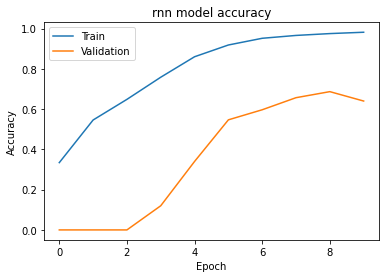

Training cnn model...
Epoch 1/10
38/38 [==============================] - 3s 58ms/step - loss: 0.6050 - accuracy: 0.3050 - val_loss: 0.8248 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 2s 44ms/step - loss: 0.5299 - accuracy: 0.3225 - val_loss: 0.9113 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 2s 44ms/step - loss: 0.4995 - accuracy: 0.5067 - val_loss: 1.0261 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 2s 45ms/step - loss: 0.3977 - accuracy: 0.6717 - val_loss: 0.9903 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 2s 45ms/step - loss: 0.2930 - accuracy: 0.7900 - val_loss: 0.9656 - val_accuracy: 0.0000e+00
Epoch 6/10
38/38 [==============================] - 2s 45ms/step - loss: 0.2191 - accuracy: 0.8533 - val_loss: 0.9845 - val_accuracy: 0.0000e+00
Epoch 7/10
38/38 [==============================] - 2s 45ms/step - loss: 0.1613 - accuracy: 0.8883 - val_los

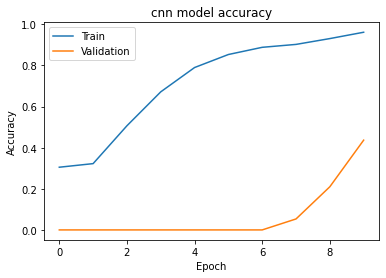

Training lstm model...
Epoch 1/10


2023-03-29 20:37:28.429407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:37:28.430604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:37:28.431592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.3233

2023-03-29 20:37:32.114446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:37:32.115576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:37:32.116518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 4s 71ms/step - loss: 0.5790 - accuracy: 0.3233 - val_loss: 0.9367 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 3s 66ms/step - loss: 0.4871 - accuracy: 0.4750 - val_loss: 0.8135 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 3s 67ms/step - loss: 0.3704 - accuracy: 0.6750 - val_loss: 0.8176 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 3s 69ms/step - loss: 0.2791 - accuracy: 0.7767 - val_loss: 0.8664 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 3s 68ms/step - loss: 0.2123 - accuracy: 0.8433 - val_loss: 0.7985 - val_accuracy: 0.1400
Epoch 6/10
38/38 [==============================] - 3s 73ms/step - loss: 0.1523 - accuracy: 0.8992 - val_loss: 0.5871 - val_accuracy: 0.4700
Epoch 7/10
38/38 [==============================] - 3s 66ms/step - loss: 0.1111 - accuracy: 0.9350 - val_loss: 0.5080 - val_accuracy: 0.6167
Epoch 8/

2023-03-29 20:37:55.349056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:37:55.350297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:37:55.351314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 0s 10ms/step
lstm model confusion matrix:
[[125   5   8   1]
 [ 21 193  35   0]
 [ 27  41 229   5]
 [  9   9   9  83]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       139
           1       0.78      0.78      0.78       249
           2       0.81      0.76      0.79       302
           3       0.93      0.75      0.83       110

    accuracy                           0.79       800
   macro avg       0.80      0.80      0.79       800
weighted avg       0.80      0.79      0.79       800

lstm model accuracy: 0.7875
lstm model precision: 0.8031
lstm model recall: 0.7968


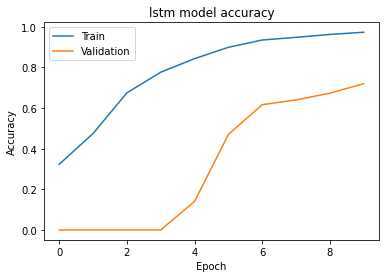

Training bilstm model...
Epoch 1/10


2023-03-29 20:37:55.952344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:37:55.953589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:37:55.954642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.3175

2023-03-29 20:38:00.785151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:38:00.786540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:38:00.787526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 5s 86ms/step - loss: 0.5707 - accuracy: 0.3175 - val_loss: 1.0230 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 3s 74ms/step - loss: 0.4923 - accuracy: 0.5067 - val_loss: 0.9546 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 3s 74ms/step - loss: 0.3705 - accuracy: 0.6808 - val_loss: 0.9307 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 3s 75ms/step - loss: 0.2758 - accuracy: 0.7775 - val_loss: 0.9009 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 3s 74ms/step - loss: 0.2165 - accuracy: 0.8442 - val_loss: 0.9520 - val_accuracy: 0.0000e+00
Epoch 6/10
38/38 [==============================] - 3s 74ms/step - loss: 0.1673 - accuracy: 0.8692 - val_loss: 0.9556 - val_accuracy: 0.0500
Epoch 7/10
38/38 [==============================] - 3s 74ms/step - loss: 0.1267 - accuracy: 0.9167 - val_loss: 0.6480 - val_accuracy: 0.3633
Epoc

2023-03-29 20:38:26.754599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:38:26.755669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:38:26.756630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 1s 12ms/step
bilstm model confusion matrix:
[[114   9  14   2]
 [ 11 199  39   0]
 [ 13  37 251   1]
 [  8  17  11  74]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       139
           1       0.76      0.80      0.78       249
           2       0.80      0.83      0.81       302
           3       0.96      0.67      0.79       110

    accuracy                           0.80       800
   macro avg       0.82      0.78      0.80       800
weighted avg       0.81      0.80      0.80       800

bilstm model accuracy: 0.7975
bilstm model precision: 0.8246
bilstm model recall: 0.7808


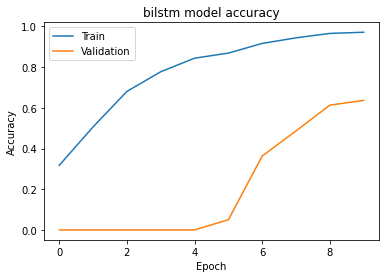

In [18]:


# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model





y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values





# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
  


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
#import warnings
#warnings.filterwarnings(action='ignore')

2023-03-30 01:06:17.926681: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 01:06:17.963923: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 01:06:17.964844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 01:06:18.685469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# LOADING THE CLEANED AND FILLED DATASET

In [2]:
df = pd.read_csv('final_project_cleaned.csv')

In [3]:
df=df[:500]

# PREPROCESSING AND PADDING

In [4]:


# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)



  


# DEFINE THE NEURAL NETWORK MODELS WITH DEFAULT PARAMS PASSED 

In [7]:
# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# OVERSAMPLING DATASET AND ENCODING Y LABELS

In [30]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RUNNING MODELS ON OVERSAMPLED DATASET AND PERFORMANCE ANALYSIS

2023-03-30 00:56:22.995309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:56:22.996483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:56:22.997761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/10


2023-03-30 00:56:23.286764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 00:56:23.320534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:56:23.321763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

5/5 [==============================] - 1s 90ms/step - loss: 0.6445 - accuracy: 0.3200 - val_loss: 0.7793 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 51ms/step - loss: 0.5840 - accuracy: 0.3333 - val_loss: 0.8069 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 53ms/step - loss: 0.5461 - accuracy: 0.3933 - val_loss: 0.7913 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 50ms/step - loss: 0.5099 - accuracy: 0.4467 - val_loss: 0.8143 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 52ms/step - loss: 0.5036 - accuracy: 0.5267 - val_loss: 0.8558 - val_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 50ms/step - loss: 0.4899 - accuracy: 0.5200 - val_loss: 0.8378 - val_accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 50ms/step - loss: 0.4741 - accuracy: 0.6000 - val_loss: 0.8547 - val_accuracy: 0.0000e+00
Epoch 8/10

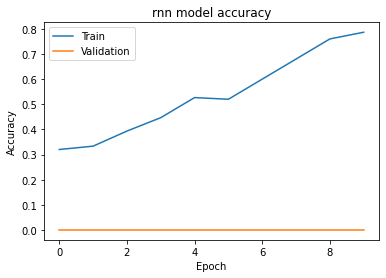

Training cnn model...
Epoch 1/10
5/5 [==============================] - 1s 95ms/step - loss: 0.6921 - accuracy: 0.3200 - val_loss: 0.6839 - val_accuracy: 0.0263
Epoch 2/10
5/5 [==============================] - 0s 74ms/step - loss: 0.6788 - accuracy: 0.2867 - val_loss: 0.6616 - val_accuracy: 0.9474
Epoch 3/10
5/5 [==============================] - 0s 52ms/step - loss: 0.6627 - accuracy: 0.2000 - val_loss: 0.6342 - val_accuracy: 0.8947
Epoch 4/10
5/5 [==============================] - 0s 50ms/step - loss: 0.6370 - accuracy: 0.2467 - val_loss: 0.5972 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 53ms/step - loss: 0.6053 - accuracy: 0.2600 - val_loss: 0.5652 - val_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 50ms/step - loss: 0.5772 - accuracy: 0.2467 - val_loss: 0.5809 - val_accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 52ms/step - loss: 0.5689 - accuracy: 0.2867 - val_loss: 0.6437 - val_accuracy: 

/home/ajay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ajay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ajay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ajay/.local/lib/python3.8/site-packages/

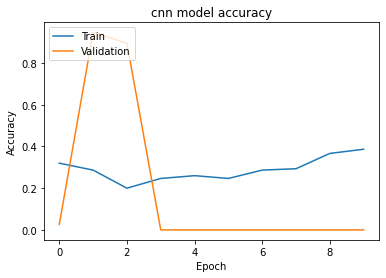

Training lstm model...
Epoch 1/10


2023-03-30 00:56:31.002154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:56:31.003511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:56:31.004499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 2s 141ms/step - loss: 0.6869 - accuracy: 0.3333 - val_loss: 0.7143 - val_accuracy: 0.0000e+00
Epoch 2/10


2023-03-30 00:56:32.744413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:56:32.745651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:56:32.746766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 70ms/step - loss: 0.6595 - accuracy: 0.3067 - val_loss: 0.8027 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 69ms/step - loss: 0.6050 - accuracy: 0.3267 - val_loss: 0.9439 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 77ms/step - loss: 0.5814 - accuracy: 0.2867 - val_loss: 0.8895 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 81ms/step - loss: 0.5516 - accuracy: 0.3000 - val_loss: 0.8382 - val_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 72ms/step - loss: 0.5303 - accuracy: 0.4133 - val_loss: 0.8466 - val_accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 76ms/step - loss: 0.5255 - accuracy: 0.3933 - val_loss: 0.8763 - val_accuracy: 0.0000e+00
Epoch 8/10
5/5 [==============================] - 0s 72ms/step - loss: 0.5194 - accuracy: 0.3800 - val_loss: 0.9273 - val_accuracy: 0.0000e+00
Epoch 9/10

2023-03-30 00:56:36.308300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:56:36.309645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:56:36.310627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

lstm model confusion matrix:
[[10  0  6  0]
 [ 4 19 13  0]
 [ 0  3 29  0]
 [ 1  0 15  0]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        16
           1       0.86      0.53      0.66        36
           2       0.46      0.91      0.61        32
           3       0.00      0.00      0.00        16

    accuracy                           0.58       100
   macro avg       0.50      0.51      0.48       100
weighted avg       0.56      0.58      0.53       100

lstm model accuracy: 0.5800
lstm model precision: 0.4977
lstm model recall: 0.5148


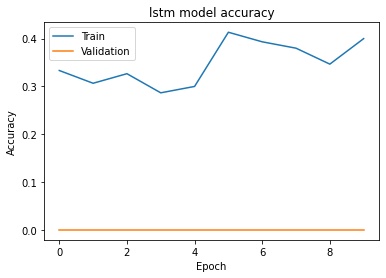

Training bilstm model...
Epoch 1/10


2023-03-30 00:56:36.709586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:56:36.711110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:56:36.712207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.2933

2023-03-30 00:56:39.967429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:56:39.968987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:56:39.970213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 4s 203ms/step - loss: 0.6856 - accuracy: 0.2933 - val_loss: 0.6856 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 87ms/step - loss: 0.6500 - accuracy: 0.3333 - val_loss: 0.6645 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 87ms/step - loss: 0.5743 - accuracy: 0.3200 - val_loss: 0.7671 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 84ms/step - loss: 0.5506 - accuracy: 0.2933 - val_loss: 0.9306 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 85ms/step - loss: 0.5502 - accuracy: 0.2867 - val_loss: 0.9763 - val_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 85ms/step - loss: 0.5447 - accuracy: 0.3400 - val_loss: 0.9069 - val_accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 1s 102ms/step - loss: 0.5189 - accuracy: 0.4200 - val_loss: 0.8812 - val_accuracy: 0.0000e+00
Epoch 8/

2023-03-30 00:56:44.513691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:56:44.515157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:56:44.516389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 13ms/step
bilstm model confusion matrix:
[[14  2  0  0]
 [ 6 28  2  0]
 [ 6 14 12  0]
 [ 3  5  8  0]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.48      0.88      0.62        16
           1       0.57      0.78      0.66        36
           2       0.55      0.38      0.44        32
           3       0.00      0.00      0.00        16

    accuracy                           0.54       100
   macro avg       0.40      0.51      0.43       100
weighted avg       0.46      0.54      0.48       100

bilstm model accuracy: 0.5400
bilstm model precision: 0.3999
bilstm model recall: 0.5069


/home/ajay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ajay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ajay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ajay/.local/lib/python3.8/site-packages/

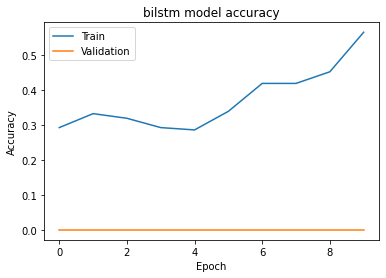

In [31]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# UNDERSAMPLING DATASET AND ENCODING Y LABELS

In [ ]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RUNNING MODELS ON UNDERSAMPLED DATASET AND PERFORMANCE ANALYSIS

In [ ]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# FINDING BEST PARAMS FOR OVERSAMPLED DATA

In [5]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RNN

In [8]:
# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.2,0.3],
    'max_seq_length': [100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

/tmp/ipykernel_38927/1669981765.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5
4/4 [==============================] - 1s 30ms/step - loss: 0.6466 - accuracy: 0.2400
Epoch 2/5
4/4 [==============================] - 0s 34ms/step - loss: 0.6057 - accuracy: 0.3440
Epoch 3/5
1/4 [======>.......................] - ETA: 0s - loss: 0.5878 - accuracy: 0.4062

2023-03-30 01:08:54.657853: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


KeyboardInterrupt: 

# CNN

In [9]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000, 50000],
              'embedding_size': [64, 128],
              'filter_size': [32, 64],
              'kernel_size': [3, 5],
              'pool_size': [2, 3],
              'dense_size': [64, 128],
              'dropout_rate': [0.2, 0.3]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Epoch 1/5


/tmp/ipykernel_38927/3953337257.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)


4/4 [==============================] - 1s 28ms/step - loss: 0.6730 - accuracy: 0.3760
Epoch 2/5
4/4 [==============================] - 0s 30ms/step - loss: 0.6463 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 30ms/step - loss: 0.6190 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 28ms/step - loss: 0.5847 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7703 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 26ms/step - loss: 0.6910 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 0s 28ms/step - loss: 0.6813 - accuracy: 0.4560
Epoch 3/5
4/4 [==============================] - 0s 29ms/step - loss: 0.6708 - accuracy: 0.4480
Epoch 4/5
4/4 [==============================] - 0s 28ms/step - loss: 0.6588 - accuracy: 0.3600
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [=============================

2/2 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 25ms/step - loss: 0.6928 - accuracy: 0.1680
Epoch 2/5
4/4 [==============================] - 0s 26ms/step - loss: 0.6834 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 0s 25ms/step - loss: 0.6705 - accuracy: 0.4080
Epoch 4/5
4/4 [==============================] - 0s 26ms/step - loss: 0.6493 - accuracy: 0.3840
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 26ms/step - loss: 0.6844 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 0s 26ms/step - loss: 0.6616 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 25ms/step - loss: 0.6335 - accuracy: 0.4080
Epoch 4/5
4/4 [==============================] - 0s 27ms/step - loss: 0.5930 - accuracy: 0.3520
Epoch 5/5
2/2 [=============================

4/4 [==============================] - 0s 27ms/step - loss: 0.6635 - accuracy: 0.3254
Epoch 3/5
4/4 [==============================] - 0s 26ms/step - loss: 0.6376 - accuracy: 0.2937
Epoch 4/5
4/4 [==============================] - 0s 27ms/step - loss: 0.5964 - accuracy: 0.3016
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7874 - accuracy: 0.2419
Epoch 1/5
4/4 [==============================] - 1s 25ms/step - loss: 0.6887 - accuracy: 0.2240
Epoch 2/5
4/4 [==============================] - 0s 26ms/step - loss: 0.6653 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 0s 25ms/step - loss: 0.6360 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 25ms/step - loss: 0.5906 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7477 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 24ms/step - loss: 0.6844 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] -

4/4 [==============================] - 0s 27ms/step - loss: 0.5985 - accuracy: 0.3280
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 27ms/step - loss: 0.6817 - accuracy: 0.3571
Epoch 2/5
4/4 [==============================] - 0s 28ms/step - loss: 0.6451 - accuracy: 0.3571
Epoch 3/5
4/4 [==============================] - 0s 27ms/step - loss: 0.5904 - accuracy: 0.3175
Epoch 4/5
4/4 [==============================] - 0s 27ms/step - loss: 0.5200 - accuracy: 0.3968
Epoch 5/5
2/2 [==============================] - 0s 5ms/step - loss: 1.0911 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 61ms/step - loss: 0.6881 - accuracy: 0.3280
Epoch 2/5
4/4 [==============================] - 0s 60ms/step - loss: 0.6617 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 0s 61ms/step - loss: 0.6205 - accuracy: 0.4160
Epoch 4/5
4/4 [=============================

2/2 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 103ms/step - loss: 0.6860 - accuracy: 0.2960
Epoch 2/5
4/4 [==============================] - 0s 101ms/step - loss: 0.6713 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 0s 100ms/step - loss: 0.6492 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 100ms/step - loss: 0.6200 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6647 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 102ms/step - loss: 0.6923 - accuracy: 0.3571
Epoch 2/5
4/4 [==============================] - 0s 102ms/step - loss: 0.6792 - accuracy: 0.3651
Epoch 3/5
4/4 [==============================] - 0s 106ms/step - loss: 0.6651 - accuracy: 0.3810
Epoch 4/5
4/4 [==============================] - 0s 101ms/step - loss: 0.6438 - accuracy: 0.4365
Epoch 5/5
2/2 [=====================

4/4 [==============================] - 0s 103ms/step - loss: 0.6493 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 105ms/step - loss: 0.6097 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 105ms/step - loss: 0.5629 - accuracy: 0.3600
Epoch 5/5
2/2 [==============================] - 0s 5ms/step - loss: 0.8909 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 106ms/step - loss: 0.6894 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 0s 104ms/step - loss: 0.6740 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 106ms/step - loss: 0.6504 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 108ms/step - loss: 0.6203 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7529 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 109ms/step - loss: 0.6864 - accuracy: 0.2698
Epoch 2/5
4/4 [=====================

4/4 [==============================] - 0s 104ms/step - loss: 0.5770 - accuracy: 0.3254
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7145 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 50ms/step - loss: 0.6857 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 0s 52ms/step - loss: 0.6562 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 0s 51ms/step - loss: 0.6052 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 52ms/step - loss: 0.5499 - accuracy: 0.4000
Epoch 5/5
2/2 [==============================] - 0s 5ms/step - loss: 0.9701 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 50ms/step - loss: 0.6879 - accuracy: 0.1520
Epoch 2/5
4/4 [==============================] - 0s 51ms/step - loss: 0.6635 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 51ms/step - loss: 0.6207 - accuracy: 0.4000
Epoch 4/5
4/4 [============================

2/2 [==============================] - 0s 4ms/step - loss: 0.5940 - accuracy: 0.0952
Epoch 1/5
4/4 [==============================] - 1s 24ms/step - loss: 0.6854 - accuracy: 0.3730
Epoch 2/5
4/4 [==============================] - 0s 25ms/step - loss: 0.6695 - accuracy: 0.3810
Epoch 3/5
4/4 [==============================] - 0s 24ms/step - loss: 0.6475 - accuracy: 0.4524
Epoch 4/5
4/4 [==============================] - 0s 25ms/step - loss: 0.6192 - accuracy: 0.3968
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7565 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 23ms/step - loss: 0.6879 - accuracy: 0.3520
Epoch 2/5
4/4 [==============================] - 0s 24ms/step - loss: 0.6759 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 24ms/step - loss: 0.6599 - accuracy: 0.3520
Epoch 4/5
4/4 [==============================] - 0s 24ms/step - loss: 0.6336 - accuracy: 0.4000
Epoch 5/5
2/2 [==============================] -

4/4 [==============================] - 0s 27ms/step - loss: 0.6804 - accuracy: 0.1920
Epoch 3/5
4/4 [==============================] - 0s 27ms/step - loss: 0.6683 - accuracy: 0.1440
Epoch 4/5
4/4 [==============================] - 0s 27ms/step - loss: 0.6439 - accuracy: 0.2320
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.0476
Epoch 1/5
4/4 [==============================] - 1s 26ms/step - loss: 0.6888 - accuracy: 0.2937
Epoch 2/5
4/4 [==============================] - 0s 25ms/step - loss: 0.6778 - accuracy: 0.4206
Epoch 3/5
4/4 [==============================] - 0s 27ms/step - loss: 0.6615 - accuracy: 0.4286
Epoch 4/5
4/4 [==============================] - 0s 27ms/step - loss: 0.6377 - accuracy: 0.4127
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6675 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 57ms/step - loss: 0.6839 - accuracy: 0.2880
Epoch 2/5
4/4 [==============================] -

4/4 [==============================] - 0s 61ms/step - loss: 0.5817 - accuracy: 0.3680
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7186 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 56ms/step - loss: 0.6812 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 56ms/step - loss: 0.6558 - accuracy: 0.3280
Epoch 3/5
4/4 [==============================] - 0s 56ms/step - loss: 0.6208 - accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 0s 56ms/step - loss: 0.5756 - accuracy: 0.4560
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 56ms/step - loss: 0.6920 - accuracy: 0.2063
Epoch 2/5
4/4 [==============================] - 0s 67ms/step - loss: 0.6789 - accuracy: 0.3730
Epoch 3/5
4/4 [==============================] - 0s 62ms/step - loss: 0.6640 - accuracy: 0.3889
Epoch 4/5
4/4 [=============================

2/2 [==============================] - 0s 4ms/step - loss: 0.9973 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 58ms/step - loss: 0.6769 - accuracy: 0.2640
Epoch 2/5
4/4 [==============================] - 0s 57ms/step - loss: 0.6374 - accuracy: 0.3360
Epoch 3/5
4/4 [==============================] - 0s 57ms/step - loss: 0.5797 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 0s 57ms/step - loss: 0.5274 - accuracy: 0.3680
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.9424 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 57ms/step - loss: 0.6843 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 0s 57ms/step - loss: 0.6588 - accuracy: 0.4320
Epoch 3/5
4/4 [==============================] - 0s 57ms/step - loss: 0.6205 - accuracy: 0.3520
Epoch 4/5
4/4 [==============================] - 0s 57ms/step - loss: 0.5683 - accuracy: 0.3840
Epoch 5/5
2/2 [=============================

4/4 [==============================] - 0s 106ms/step - loss: 0.6712 - accuracy: 0.3095
Epoch 3/5
4/4 [==============================] - 0s 103ms/step - loss: 0.6440 - accuracy: 0.3968
Epoch 4/5
4/4 [==============================] - 0s 102ms/step - loss: 0.6104 - accuracy: 0.3095
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7530 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 48ms/step - loss: 0.6912 - accuracy: 0.1840
Epoch 2/5
4/4 [==============================] - 0s 49ms/step - loss: 0.6717 - accuracy: 0.4320
Epoch 3/5
4/4 [==============================] - 0s 47ms/step - loss: 0.6443 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 49ms/step - loss: 0.6031 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 5ms/step - loss: 0.7356 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 47ms/step - loss: 0.6822 - accuracy: 0.3600
Epoch 2/5
4/4 [==========================

4/4 [==============================] - 0s 48ms/step - loss: 0.5796 - accuracy: 0.3360
Epoch 5/5
2/2 [==============================] - 0s 5ms/step - loss: 0.6786 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 47ms/step - loss: 0.6802 - accuracy: 0.3889
Epoch 2/5
4/4 [==============================] - 0s 48ms/step - loss: 0.6487 - accuracy: 0.3730
Epoch 3/5
4/4 [==============================] - 0s 50ms/step - loss: 0.6004 - accuracy: 0.3889
Epoch 4/5
4/4 [==============================] - 0s 47ms/step - loss: 0.5494 - accuracy: 0.3968
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.9390 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 46ms/step - loss: 0.6861 - accuracy: 0.2720
Epoch 2/5
4/4 [==============================] - 0s 48ms/step - loss: 0.6555 - accuracy: 0.3600
Epoch 3/5
4/4 [==============================] - 0s 47ms/step - loss: 0.6187 - accuracy: 0.3520
Epoch 4/5
4/4 [=============================

2/2 [==============================] - 0s 5ms/step - loss: 0.9590 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 50ms/step - loss: 0.6829 - accuracy: 0.2160
Epoch 2/5
4/4 [==============================] - 0s 54ms/step - loss: 0.6512 - accuracy: 0.2800
Epoch 3/5
4/4 [==============================] - 0s 60ms/step - loss: 0.5954 - accuracy: 0.3520
Epoch 4/5
4/4 [==============================] - 0s 53ms/step - loss: 0.5585 - accuracy: 0.2800
Epoch 5/5
2/2 [==============================] - 0s 6ms/step - loss: 0.8215 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 52ms/step - loss: 0.6806 - accuracy: 0.3095
Epoch 2/5
4/4 [==============================] - 0s 54ms/step - loss: 0.6357 - accuracy: 0.3571
Epoch 3/5
4/4 [==============================] - 0s 53ms/step - loss: 0.5798 - accuracy: 0.3651
Epoch 4/5
4/4 [==============================] - 0s 52ms/step - loss: 0.5311 - accuracy: 0.3175
Epoch 5/5
2/2 [=============================

4/4 [==============================] - 0s 53ms/step - loss: 0.6733 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 54ms/step - loss: 0.6527 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 57ms/step - loss: 0.6275 - accuracy: 0.4000
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 55ms/step - loss: 0.6879 - accuracy: 0.2720
Epoch 2/5
4/4 [==============================] - 0s 54ms/step - loss: 0.6731 - accuracy: 0.4320
Epoch 3/5
4/4 [==============================] - 0s 55ms/step - loss: 0.6529 - accuracy: 0.4880
Epoch 4/5
4/4 [==============================] - 0s 54ms/step - loss: 0.6233 - accuracy: 0.5120
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 55ms/step - loss: 0.6874 - accuracy: 0.2302
Epoch 2/5
4/4 [=============================

4/4 [==============================] - 0s 58ms/step - loss: 0.6186 - accuracy: 0.4365
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7499 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 60ms/step - loss: 0.6845 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 55ms/step - loss: 0.6582 - accuracy: 0.3520
Epoch 3/5
4/4 [==============================] - 0s 54ms/step - loss: 0.6148 - accuracy: 0.3520
Epoch 4/5
4/4 [==============================] - 0s 56ms/step - loss: 0.5556 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.8640 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 57ms/step - loss: 0.6905 - accuracy: 0.2880
Epoch 2/5
4/4 [==============================] - 0s 55ms/step - loss: 0.6799 - accuracy: 0.4240
Epoch 3/5
4/4 [==============================] - 0s 56ms/step - loss: 0.6647 - accuracy: 0.4000
Epoch 4/5
4/4 [=============================

2/2 [==============================] - 0s 4ms/step - loss: 0.7312 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 55ms/step - loss: 0.6821 - accuracy: 0.3175
Epoch 2/5
4/4 [==============================] - 0s 54ms/step - loss: 0.6513 - accuracy: 0.3810
Epoch 3/5
4/4 [==============================] - 0s 55ms/step - loss: 0.6067 - accuracy: 0.3651
Epoch 4/5
4/4 [==============================] - 0s 55ms/step - loss: 0.5493 - accuracy: 0.4127
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.8607 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 29ms/step - loss: 0.6836 - accuracy: 0.3840
Epoch 2/5
4/4 [==============================] - 0s 29ms/step - loss: 0.6466 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 30ms/step - loss: 0.5814 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 28ms/step - loss: 0.5066 - accuracy: 0.4320
Epoch 5/5
2/2 [=============================

4/4 [==============================] - 0s 47ms/step - loss: 0.6642 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 0s 46ms/step - loss: 0.6317 - accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 0s 46ms/step - loss: 0.5815 - accuracy: 0.4240
Epoch 5/5
2/2 [==============================] - 0s 5ms/step - loss: 0.6839 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 44ms/step - loss: 0.6907 - accuracy: 0.3413
Epoch 2/5
4/4 [==============================] - 0s 46ms/step - loss: 0.6723 - accuracy: 0.4286
Epoch 3/5
4/4 [==============================] - 0s 46ms/step - loss: 0.6465 - accuracy: 0.3413
Epoch 4/5
4/4 [==============================] - 0s 45ms/step - loss: 0.6030 - accuracy: 0.3492
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7768 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 46ms/step - loss: 0.6899 - accuracy: 0.3600
Epoch 2/5
4/4 [=============================

4/4 [==============================] - 0s 53ms/step - loss: 0.6295 - accuracy: 0.2880
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6058 - accuracy: 0.2540
Epoch 1/5
4/4 [==============================] - 1s 47ms/step - loss: 0.6848 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 51ms/step - loss: 0.6585 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 50ms/step - loss: 0.6193 - accuracy: 0.3600
Epoch 4/5
4/4 [==============================] - 0s 50ms/step - loss: 0.5570 - accuracy: 0.3520
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.8006 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 49ms/step - loss: 0.6865 - accuracy: 0.0397
Epoch 2/5
4/4 [==============================] - 0s 50ms/step - loss: 0.6622 - accuracy: 0.2619
Epoch 3/5
4/4 [==============================] - 0s 48ms/step - loss: 0.6244 - accuracy: 0.2778
Epoch 4/5
4/4 [==============================] -

2/2 [==============================] - 0s 5ms/step - loss: 0.9389 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 108ms/step - loss: 0.6890 - accuracy: 0.2720
Epoch 2/5
4/4 [==============================] - 0s 105ms/step - loss: 0.6709 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 104ms/step - loss: 0.6409 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 110ms/step - loss: 0.5964 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 5ms/step - loss: 0.7543 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 105ms/step - loss: 0.6848 - accuracy: 0.3760
Epoch 2/5
4/4 [==============================] - 0s 106ms/step - loss: 0.6580 - accuracy: 0.4080
Epoch 3/5
4/4 [==============================] - 0s 106ms/step - loss: 0.6135 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 107ms/step - loss: 0.5559 - accuracy: 0.4080
Epoch 5/5
2/2 [=====================

4/4 [==============================] - 0s 113ms/step - loss: 0.6571 - accuracy: 0.4048
Epoch 3/5
4/4 [==============================] - 0s 112ms/step - loss: 0.5942 - accuracy: 0.4524
Epoch 4/5
4/4 [==============================] - 0s 109ms/step - loss: 0.5230 - accuracy: 0.4127
Epoch 5/5
2/2 [==============================] - 0s 5ms/step - loss: 1.1523 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 108ms/step - loss: 0.6763 - accuracy: 0.3680
Epoch 2/5
4/4 [==============================] - 0s 109ms/step - loss: 0.6161 - accuracy: 0.3520
Epoch 3/5
4/4 [==============================] - 0s 107ms/step - loss: 0.5354 - accuracy: 0.4160
Epoch 4/5
4/4 [==============================] - 0s 111ms/step - loss: 0.5016 - accuracy: 0.3680
Epoch 5/5
2/2 [==============================] - 0s 5ms/step - loss: 1.1522 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 107ms/step - loss: 0.6864 - accuracy: 0.3600
Epoch 2/5
4/4 [=====================

4/4 [==============================] - 0s 57ms/step - loss: 0.6313 - accuracy: 0.3600
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 55ms/step - loss: 0.6884 - accuracy: 0.3571
Epoch 2/5
4/4 [==============================] - 0s 55ms/step - loss: 0.6729 - accuracy: 0.4127
Epoch 3/5
4/4 [==============================] - 0s 55ms/step - loss: 0.6526 - accuracy: 0.3968
Epoch 4/5
4/4 [==============================] - 0s 53ms/step - loss: 0.6240 - accuracy: 0.3651
Epoch 5/5
2/2 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 26ms/step - loss: 0.6868 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 0s 27ms/step - loss: 0.6687 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 26ms/step - loss: 0.6386 - accuracy: 0.4240
Epoch 4/5
4/4 [=============================

2/2 [==============================] - 0s 4ms/step - loss: 0.7720 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 26ms/step - loss: 0.6851 - accuracy: 0.2320
Epoch 2/5
4/4 [==============================] - 0s 26ms/step - loss: 0.6644 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 0s 27ms/step - loss: 0.6300 - accuracy: 0.3600
Epoch 4/5
4/4 [==============================] - 0s 27ms/step - loss: 0.5813 - accuracy: 0.4320
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7083 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 28ms/step - loss: 0.6858 - accuracy: 0.2778
Epoch 2/5
4/4 [==============================] - 0s 27ms/step - loss: 0.6607 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 0s 27ms/step - loss: 0.6269 - accuracy: 0.4762
Epoch 4/5
4/4 [==============================] - 0s 27ms/step - loss: 0.5808 - accuracy: 0.3968
Epoch 5/5
2/2 [=============================

4/4 [==============================] - 0s 27ms/step - loss: 0.6651 - accuracy: 0.3600
Epoch 3/5
4/4 [==============================] - 0s 28ms/step - loss: 0.6252 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 0s 28ms/step - loss: 0.5650 - accuracy: 0.3600
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.9057 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 27ms/step - loss: 0.6844 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 0s 28ms/step - loss: 0.6507 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 0s 28ms/step - loss: 0.5964 - accuracy: 0.3280
Epoch 4/5
4/4 [==============================] - 0s 28ms/step - loss: 0.5407 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.8592 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 27ms/step - loss: 0.6808 - accuracy: 0.2937
Epoch 2/5
4/4 [=============================

4/4 [==============================] - 0s 46ms/step - loss: 0.6000 - accuracy: 0.2540
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7377 - accuracy: 0.2419
Epoch 1/5
4/4 [==============================] - 1s 106ms/step - loss: 0.6849 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 105ms/step - loss: 0.6652 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 0s 106ms/step - loss: 0.6362 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 105ms/step - loss: 0.5953 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7619 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 104ms/step - loss: 0.6909 - accuracy: 0.2720
Epoch 2/5
4/4 [==============================] - 0s 105ms/step - loss: 0.6764 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 0s 103ms/step - loss: 0.6525 - accuracy: 0.4000
Epoch 4/5
4/4 [==========================

2/2 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 108ms/step - loss: 0.6896 - accuracy: 0.2222
Epoch 2/5
4/4 [==============================] - 0s 110ms/step - loss: 0.6708 - accuracy: 0.4048
Epoch 3/5
4/4 [==============================] - 0s 115ms/step - loss: 0.6410 - accuracy: 0.3730
Epoch 4/5
4/4 [==============================] - 0s 116ms/step - loss: 0.5958 - accuracy: 0.3571
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.7178 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 111ms/step - loss: 0.6879 - accuracy: 0.2480
Epoch 2/5
4/4 [==============================] - 0s 113ms/step - loss: 0.6704 - accuracy: 0.2640
Epoch 3/5
4/4 [==============================] - 0s 110ms/step - loss: 0.6378 - accuracy: 0.2720
Epoch 4/5
4/4 [==============================] - 0s 110ms/step - loss: 0.5848 - accuracy: 0.3040
Epoch 5/5
2/2 [=====================

4/4 [==============================] - 0s 104ms/step - loss: 0.6712 - accuracy: 0.3520
Epoch 3/5
4/4 [==============================] - 0s 103ms/step - loss: 0.6453 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 104ms/step - loss: 0.6038 - accuracy: 0.3680
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6633 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 103ms/step - loss: 0.6836 - accuracy: 0.3492
Epoch 2/5
4/4 [==============================] - 0s 102ms/step - loss: 0.6534 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 0s 104ms/step - loss: 0.6003 - accuracy: 0.3492
Epoch 4/5
4/4 [==============================] - 0s 101ms/step - loss: 0.5301 - accuracy: 0.3730
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 1.0000 - accuracy: 0.0000e+00
Epoch 1/5
4/4 [==============================] - 1s 53ms/step - loss: 0.6833 - accuracy: 0.2320
Epoch 2/5
4/4 [======================

6/6 [==============================] - 0s 47ms/step - loss: 0.5683 - accuracy: 0.3138
Epoch 5/5
6/6 [==============================] - 0s 48ms/step - loss: 0.5647 - accuracy: 0.3191
Best parameters: {'dense_size': 64, 'dropout_rate': 0.2, 'embedding_size': 128, 'filter_size': 64, 'kernel_size': 3, 'num_words': 20000, 'pool_size': 2}
Best accuracy: 0.24995733797550201


# LSTM

In [10]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

/tmp/ipykernel_38927/3755137833.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)
2023-03-30 01:25:59.454510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:25:59.455740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


2023-03-30 01:25:59.669132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:25:59.670302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:25:59.671324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 49ms/step - loss: 0.6863 - accuracy: 0.4160
Epoch 2/5
4/4 [==============================] - 0s 53ms/step - loss: 0.6626 - accuracy: 0.4560
Epoch 3/5
4/4 [==============================] - 0s 49ms/step - loss: 0.6069 - accuracy: 0.4480
Epoch 4/5
4/4 [==============================] - 0s 49ms/step - loss: 0.5188 - accuracy: 0.3200
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 1.1109 - accuracy: 0.0000e+00


2023-03-30 01:26:02.058127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:02.059202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:02.060025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:02.367011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:02.368249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:02.369127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 45ms/step - loss: 0.6902 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 47ms/step - loss: 0.6752 - accuracy: 0.4400
Epoch 3/5
4/4 [==============================] - 0s 45ms/step - loss: 0.6431 - accuracy: 0.4240
Epoch 4/5
4/4 [==============================] - 0s 44ms/step - loss: 0.5665 - accuracy: 0.4080
Epoch 5/5
2/2 [==============================] - 0s 14ms/step - loss: 0.7808 - accuracy: 0.0000e+00


2023-03-30 01:26:05.485145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:05.486423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:05.487466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:05.830682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:05.831967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:05.833018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 45ms/step - loss: 0.6890 - accuracy: 0.3571
Epoch 2/5
4/4 [==============================] - 0s 43ms/step - loss: 0.6712 - accuracy: 0.3730
Epoch 3/5
4/4 [==============================] - 0s 43ms/step - loss: 0.6319 - accuracy: 0.3571
Epoch 4/5
4/4 [==============================] - 0s 42ms/step - loss: 0.5446 - accuracy: 0.3651
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 1.0897 - accuracy: 0.0000e+00


2023-03-30 01:26:08.364291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:08.365702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:08.366704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:08.690274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:08.691852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:08.693266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 82ms/step - loss: 0.6900 - accuracy: 0.2320
Epoch 2/5
4/4 [==============================] - 0s 80ms/step - loss: 0.6775 - accuracy: 0.3520
Epoch 3/5
4/4 [==============================] - 0s 73ms/step - loss: 0.6487 - accuracy: 0.4560
Epoch 4/5
4/4 [==============================] - 0s 71ms/step - loss: 0.5709 - accuracy: 0.3360
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 0.8663 - accuracy: 0.0000e+00


2023-03-30 01:26:11.908449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:11.909991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:11.911030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:12.221998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:12.222906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:12.223899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 70ms/step - loss: 0.6896 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 72ms/step - loss: 0.6758 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 0s 73ms/step - loss: 0.6473 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 84ms/step - loss: 0.5847 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.7787 - accuracy: 0.0000e+00


2023-03-30 01:26:15.308972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:15.310065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:15.310987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:15.612392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:15.613492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:15.614446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 66ms/step - loss: 0.6891 - accuracy: 0.3889
Epoch 2/5
4/4 [==============================] - 0s 68ms/step - loss: 0.6731 - accuracy: 0.4444
Epoch 3/5
4/4 [==============================] - 0s 69ms/step - loss: 0.6446 - accuracy: 0.3968
Epoch 4/5
4/4 [==============================] - 0s 69ms/step - loss: 0.5749 - accuracy: 0.3571
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 1.1674 - accuracy: 0.0000e+00


2023-03-30 01:26:18.524714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:18.526133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:18.527083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:18.842796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:18.844423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:18.845826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 63ms/step - loss: 0.6903 - accuracy: 0.2720
Epoch 2/5
4/4 [==============================] - 0s 64ms/step - loss: 0.6629 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5856 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5185 - accuracy: 0.4000
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 0.9380 - accuracy: 0.0000e+00


2023-03-30 01:26:22.449782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:22.451004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:22.452016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:22.795162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:22.796535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:22.797777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 63ms/step - loss: 0.6884 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 63ms/step - loss: 0.6568 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5546 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5430 - accuracy: 0.3360
Epoch 5/5
2/2 [==============================] - 0s 19ms/step - loss: 0.7848 - accuracy: 0.0000e+00


2023-03-30 01:26:25.754787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:25.755912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:25.756841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:26.089523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:26.090905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:26.091815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 65ms/step - loss: 0.6883 - accuracy: 0.3095
Epoch 2/5
4/4 [==============================] - 0s 64ms/step - loss: 0.6587 - accuracy: 0.3730
Epoch 3/5
4/4 [==============================] - 0s 63ms/step - loss: 0.5570 - accuracy: 0.3730
Epoch 4/5
4/4 [==============================] - 0s 64ms/step - loss: 0.4952 - accuracy: 0.3889
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 1.1605 - accuracy: 0.0000e+00


2023-03-30 01:26:28.997975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:28.999315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:29.000273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:29.323369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:29.324599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:29.325654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 91ms/step - loss: 0.6825 - accuracy: 0.3040
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.6238 - accuracy: 0.2720
Epoch 3/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5133 - accuracy: 0.3200
Epoch 4/5
4/4 [==============================] - 0s 93ms/step - loss: 0.5034 - accuracy: 0.3440
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 1.2661 - accuracy: 0.0000e+00


2023-03-30 01:26:32.705968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:32.707431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:32.708720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:33.029482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:33.030990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:33.032259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 90ms/step - loss: 0.6899 - accuracy: 0.3280
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.6631 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5695 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 91ms/step - loss: 0.5393 - accuracy: 0.3840
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 0.7689 - accuracy: 0.0000e+00


2023-03-30 01:26:36.447269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:36.448518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:36.449837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:36.767721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:36.769053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:36.769975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 90ms/step - loss: 0.6872 - accuracy: 0.3175
Epoch 2/5
4/4 [==============================] - 0s 92ms/step - loss: 0.6490 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5427 - accuracy: 0.3889
Epoch 4/5
4/4 [==============================] - 0s 91ms/step - loss: 0.5093 - accuracy: 0.4206
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 0.8276 - accuracy: 0.0000e+00

2023-03-30 01:26:40.851313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:40.852851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:40.854105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 19ms/step - loss: 0.9259 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:26:41.219184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:41.220317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:41.221543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 61ms/step - loss: 0.6872 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 61ms/step - loss: 0.6681 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 0s 61ms/step - loss: 0.6318 - accuracy: 0.3920
Epoch 4/5
4/4 [==============================] - 0s 62ms/step - loss: 0.5561 - accuracy: 0.3440
Epoch 5/5
2/2 [==============================] - 0s 14ms/step - loss: 0.8831 - accuracy: 0.0000e+00


2023-03-30 01:26:44.129035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:44.130206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:44.131160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:44.454811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:44.455918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:44.456922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 61ms/step - loss: 0.6874 - accuracy: 0.4240
Epoch 2/5
4/4 [==============================] - 0s 64ms/step - loss: 0.6653 - accuracy: 0.5120
Epoch 3/5
4/4 [==============================] - 0s 61ms/step - loss: 0.6139 - accuracy: 0.4640
Epoch 4/5
4/4 [==============================] - 0s 75ms/step - loss: 0.5327 - accuracy: 0.4000
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.8834 - accuracy: 0.0000e+00


2023-03-30 01:26:47.415995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:47.417153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:47.418037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:47.732159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:47.733671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:47.734843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 61ms/step - loss: 0.6891 - accuracy: 0.2937
Epoch 2/5
4/4 [==============================] - 0s 61ms/step - loss: 0.6696 - accuracy: 0.5159
Epoch 3/5
4/4 [==============================] - 0s 62ms/step - loss: 0.6236 - accuracy: 0.4603
Epoch 4/5
4/4 [==============================] - 0s 63ms/step - loss: 0.5356 - accuracy: 0.3571
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.9874 - accuracy: 0.0000e+00


2023-03-30 01:26:50.576587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:50.577822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:50.578707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:50.897415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:50.898554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:50.899598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 112ms/step - loss: 0.6879 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 0s 111ms/step - loss: 0.6637 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 111ms/step - loss: 0.6134 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 111ms/step - loss: 0.5315 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.9769 - accuracy: 0.0000e+00


2023-03-30 01:26:54.710182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:54.711202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:54.712440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:26:55.025619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:55.026794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:55.028167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 113ms/step - loss: 0.6878 - accuracy: 0.4320
Epoch 2/5
4/4 [==============================] - 0s 111ms/step - loss: 0.6687 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 0s 114ms/step - loss: 0.6222 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 113ms/step - loss: 0.5455 - accuracy: 0.3840
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 0.7817 - accuracy: 0.0000e+00

2023-03-30 01:26:59.248390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:59.249934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:59.251190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 13ms/step - loss: 0.8331 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:26:59.623049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:26:59.624190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:26:59.625216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 111ms/step - loss: 0.6868 - accuracy: 0.4127
Epoch 2/5
4/4 [==============================] - 0s 110ms/step - loss: 0.6611 - accuracy: 0.4127
Epoch 3/5
4/4 [==============================] - 0s 112ms/step - loss: 0.5980 - accuracy: 0.3968
Epoch 4/5
4/4 [==============================] - 0s 112ms/step - loss: 0.5509 - accuracy: 0.3651
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.7927 - accuracy: 0.0000e+00


2023-03-30 01:27:03.594031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:03.595193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:03.596168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:03.922012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:03.923393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:03.924296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 89ms/step - loss: 0.6880 - accuracy: 0.2560
Epoch 2/5
4/4 [==============================] - 0s 89ms/step - loss: 0.6447 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 88ms/step - loss: 0.5212 - accuracy: 0.3520
Epoch 4/5
4/4 [==============================] - 0s 89ms/step - loss: 0.5038 - accuracy: 0.3520
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 1.1841 - accuracy: 0.0000e+00


2023-03-30 01:27:07.350137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:07.351646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:07.353066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:07.688625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:07.689732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:07.690697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 88ms/step - loss: 0.6852 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.6412 - accuracy: 0.4960
Epoch 3/5
4/4 [==============================] - 0s 87ms/step - loss: 0.5490 - accuracy: 0.3920
Epoch 4/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5283 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 23ms/step - loss: 0.8000 - accuracy: 0.0000e+00


2023-03-30 01:27:11.040767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:11.042205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:11.043414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:11.362862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:11.364040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:11.365698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 88ms/step - loss: 0.6829 - accuracy: 0.3651
Epoch 2/5
4/4 [==============================] - 0s 88ms/step - loss: 0.6265 - accuracy: 0.3810
Epoch 3/5
4/4 [==============================] - 0s 88ms/step - loss: 0.5055 - accuracy: 0.3571
Epoch 4/5
4/4 [==============================] - 0s 89ms/step - loss: 0.5040 - accuracy: 0.3016
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 1.2874 - accuracy: 0.0000e+00


2023-03-30 01:27:14.722713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:14.724034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:14.724945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:15.063051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:15.064139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:15.065070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 144ms/step - loss: 0.6801 - accuracy: 0.3840
Epoch 2/5
4/4 [==============================] - 1s 140ms/step - loss: 0.6053 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 1s 140ms/step - loss: 0.5350 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 1s 141ms/step - loss: 0.4931 - accuracy: 0.3680
Epoch 5/5
2/2 [==============================] - 0s 23ms/step - loss: 1.1091 - accuracy: 0.0000e+00


2023-03-30 01:27:19.459277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:19.460519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:19.461349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:20.244229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:20.245807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:20.246841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 139ms/step - loss: 0.6825 - accuracy: 0.2240
Epoch 2/5
4/4 [==============================] - 1s 141ms/step - loss: 0.6185 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 1s 140ms/step - loss: 0.5496 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 1s 138ms/step - loss: 0.5217 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 0.7517 - accuracy: 0.0000e+00


2023-03-30 01:27:24.791542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:24.792780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:24.793701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:25.159198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:25.160319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:25.161269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 143ms/step - loss: 0.6889 - accuracy: 0.3651
Epoch 2/5
4/4 [==============================] - 1s 141ms/step - loss: 0.6578 - accuracy: 0.4286
Epoch 3/5
4/4 [==============================] - 1s 141ms/step - loss: 0.5555 - accuracy: 0.3175
Epoch 4/5
4/4 [==============================] - 1s 144ms/step - loss: 0.5007 - accuracy: 0.3968
Epoch 5/5
2/2 [==============================] - 0s 22ms/step - loss: 1.1690 - accuracy: 0.0000e+00


2023-03-30 01:27:29.655013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:29.656198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:29.657416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:29.996264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:29.997432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:29.998248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 43ms/step - loss: 0.6862 - accuracy: 0.3520
Epoch 2/5
4/4 [==============================] - 0s 43ms/step - loss: 0.6647 - accuracy: 0.4560
Epoch 3/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6099 - accuracy: 0.4240
Epoch 4/5
4/4 [==============================] - 0s 44ms/step - loss: 0.5371 - accuracy: 0.4000
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.9152 - accuracy: 0.0000e+00


2023-03-30 01:27:32.468159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:32.469423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:32.470418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:32.774703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:32.775838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:32.776767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 43ms/step - loss: 0.6897 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6752 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6380 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 42ms/step - loss: 0.5680 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 0.7981 - accuracy: 0.0000e+00


2023-03-30 01:27:35.210531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:35.211606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:35.212470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:35.507612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:35.508769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:35.509695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 44ms/step - loss: 0.6882 - accuracy: 0.2540
Epoch 2/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6668 - accuracy: 0.3254
Epoch 3/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6163 - accuracy: 0.3492
Epoch 4/5
4/4 [==============================] - 0s 43ms/step - loss: 0.5447 - accuracy: 0.2937
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 0.8745 - accuracy: 0.0000e+00


2023-03-30 01:27:38.003730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:38.004685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:38.005749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:38.310009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:38.311075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:38.311924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 67ms/step - loss: 0.6888 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 0s 68ms/step - loss: 0.6730 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 0s 68ms/step - loss: 0.6326 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 68ms/step - loss: 0.5572 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.8520 - accuracy: 0.0000e+00


2023-03-30 01:27:41.886185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:41.887106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:41.888176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:42.217074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:42.218178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:42.219111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 66ms/step - loss: 0.6878 - accuracy: 0.3680
Epoch 2/5
4/4 [==============================] - 0s 67ms/step - loss: 0.6685 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 67ms/step - loss: 0.6303 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 67ms/step - loss: 0.5682 - accuracy: 0.3600
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.7059 - accuracy: 0.0000e+00


2023-03-30 01:27:45.214473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:45.215610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:45.216592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:45.531657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:45.533275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:45.534632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 80ms/step - loss: 0.6857 - accuracy: 0.3333
Epoch 2/5
4/4 [==============================] - 0s 67ms/step - loss: 0.6625 - accuracy: 0.3016
Epoch 3/5
4/4 [==============================] - 0s 67ms/step - loss: 0.5969 - accuracy: 0.3651
Epoch 4/5
4/4 [==============================] - 0s 69ms/step - loss: 0.5414 - accuracy: 0.2540
Epoch 5/5
2/2 [==============================] - 0s 13ms/step - loss: 1.0108 - accuracy: 0.0000e+00


2023-03-30 01:27:48.553407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:48.554842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:48.556278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:48.867310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:48.869000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:48.870444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 64ms/step - loss: 0.6887 - accuracy: 0.2480
Epoch 2/5
4/4 [==============================] - 0s 64ms/step - loss: 0.6615 - accuracy: 0.3440
Epoch 3/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5617 - accuracy: 0.3600
Epoch 4/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5152 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 1.1292 - accuracy: 0.0000e+00


2023-03-30 01:27:51.734937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:51.736184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:51.737227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:52.068676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:52.070184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:52.071424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 64ms/step - loss: 0.6861 - accuracy: 0.2640
Epoch 2/5
4/4 [==============================] - 0s 65ms/step - loss: 0.6465 - accuracy: 0.4240
Epoch 3/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5531 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 0s 66ms/step - loss: 0.5303 - accuracy: 0.4160
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 0.7178 - accuracy: 0.0000e+00


2023-03-30 01:27:54.929707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:54.930897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:54.932111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:55.241559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:55.242660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:55.243607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 64ms/step - loss: 0.6880 - accuracy: 0.4048
Epoch 2/5
4/4 [==============================] - 0s 65ms/step - loss: 0.6574 - accuracy: 0.3333
Epoch 3/5
4/4 [==============================] - 0s 65ms/step - loss: 0.5406 - accuracy: 0.3254
Epoch 4/5
4/4 [==============================] - 0s 64ms/step - loss: 0.4915 - accuracy: 0.4206
Epoch 5/5
2/2 [==============================] - 0s 19ms/step - loss: 1.3852 - accuracy: 0.0000e+00


2023-03-30 01:27:58.706458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:58.707492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:58.708529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:27:59.043874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:27:59.045174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:27:59.046146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 91ms/step - loss: 0.6862 - accuracy: 0.2880
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.6461 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 0s 91ms/step - loss: 0.5296 - accuracy: 0.3280
Epoch 4/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5180 - accuracy: 0.3520
Epoch 5/5
2/2 [==============================] - 0s 21ms/step - loss: 1.1529 - accuracy: 0.0000e+00


2023-03-30 01:28:02.538581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:02.539749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:02.540845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:02.879138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:02.880214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:02.881157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 90ms/step - loss: 0.6863 - accuracy: 0.4000
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.6509 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5661 - accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5445 - accuracy: 0.4000
Epoch 5/5
2/2 [==============================] - 0s 19ms/step - loss: 0.7541 - accuracy: 0.0000e+00


2023-03-30 01:28:06.301381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:06.302494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:06.303424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:06.641440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:06.642738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:06.643695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 91ms/step - loss: 0.6833 - accuracy: 0.3413
Epoch 2/5
4/4 [==============================] - 0s 92ms/step - loss: 0.6134 - accuracy: 0.4206
Epoch 3/5
4/4 [==============================] - 0s 93ms/step - loss: 0.5132 - accuracy: 0.3810
Epoch 4/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5131 - accuracy: 0.3333
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 1.1158 - accuracy: 0.0000e+00


2023-03-30 01:28:10.074929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:10.076177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:10.077166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:10.409771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:10.411295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:10.412664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 61ms/step - loss: 0.6870 - accuracy: 0.2560
Epoch 2/5
4/4 [==============================] - 0s 62ms/step - loss: 0.6632 - accuracy: 0.3600
Epoch 3/5
4/4 [==============================] - 0s 62ms/step - loss: 0.6089 - accuracy: 0.3360
Epoch 4/5
4/4 [==============================] - 0s 63ms/step - loss: 0.5566 - accuracy: 0.3440
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.8222 - accuracy: 0.0000e+00


2023-03-30 01:28:13.250983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:13.252409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:13.253565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:13.561150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:13.562242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:13.563245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 63ms/step - loss: 0.6868 - accuracy: 0.3760
Epoch 2/5
4/4 [==============================] - 0s 62ms/step - loss: 0.6621 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 61ms/step - loss: 0.5938 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 63ms/step - loss: 0.5364 - accuracy: 0.3440
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.8518 - accuracy: 0.0000e+00


2023-03-30 01:28:17.013916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:17.015054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:17.015968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:17.336500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:17.338000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:17.339110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 61ms/step - loss: 0.6848 - accuracy: 0.4206
Epoch 2/5
4/4 [==============================] - 0s 62ms/step - loss: 0.6595 - accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 0s 63ms/step - loss: 0.6129 - accuracy: 0.3968
Epoch 4/5
4/4 [==============================] - 0s 62ms/step - loss: 0.5405 - accuracy: 0.3413
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.9923 - accuracy: 0.0000e+00


2023-03-30 01:28:20.275733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:20.276853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:20.277788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:20.606412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:20.607541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:20.608513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 112ms/step - loss: 0.6836 - accuracy: 0.4240
Epoch 2/5
4/4 [==============================] - 0s 110ms/step - loss: 0.6548 - accuracy: 0.4080
Epoch 3/5
4/4 [==============================] - 0s 111ms/step - loss: 0.5934 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 116ms/step - loss: 0.5343 - accuracy: 0.4320
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.9183 - accuracy: 0.0000e+00


2023-03-30 01:28:24.475944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:24.477068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:24.477915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:24.809436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:24.810456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:24.811507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 113ms/step - loss: 0.6862 - accuracy: 0.3680
Epoch 2/5
4/4 [==============================] - 0s 113ms/step - loss: 0.6635 - accuracy: 0.4240
Epoch 3/5
4/4 [==============================] - 0s 111ms/step - loss: 0.6227 - accuracy: 0.4160
Epoch 4/5
4/4 [==============================] - 0s 115ms/step - loss: 0.5673 - accuracy: 0.4000
Epoch 5/5
2/2 [==============================] - 0s 13ms/step - loss: 0.8128 - accuracy: 0.0000e+00


2023-03-30 01:28:28.705419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:28.706659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:28.707537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:29.019608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:29.020949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:29.021919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 116ms/step - loss: 0.6926 - accuracy: 0.3968
Epoch 2/5
4/4 [==============================] - 0s 116ms/step - loss: 0.6781 - accuracy: 0.4762
Epoch 3/5
4/4 [==============================] - 0s 117ms/step - loss: 0.6478 - accuracy: 0.4365
Epoch 4/5
4/4 [==============================] - 1s 127ms/step - loss: 0.5846 - accuracy: 0.3810
Epoch 5/5
2/2 [==============================] - 0s 13ms/step - loss: 0.9036 - accuracy: 0.0000e+00


2023-03-30 01:28:33.057111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:33.058212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:33.059189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:33.427687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:33.428814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:33.429714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 90ms/step - loss: 0.6834 - accuracy: 0.3920
Epoch 2/5
4/4 [==============================] - 0s 89ms/step - loss: 0.6288 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5240 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 91ms/step - loss: 0.5125 - accuracy: 0.3040
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 1.1486 - accuracy: 0.0000e+00

2023-03-30 01:28:37.522272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:37.523802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:37.524727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 22ms/step - loss: 1.0063 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:28:37.881540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:37.882653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:37.883609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 89ms/step - loss: 0.6791 - accuracy: 0.2400
Epoch 2/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5906 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 91ms/step - loss: 0.5675 - accuracy: 0.3520
Epoch 4/5
4/4 [==============================] - 0s 93ms/step - loss: 0.5261 - accuracy: 0.3600
Epoch 5/5
2/2 [==============================] - 0s 24ms/step - loss: 0.7811 - accuracy: 0.0000e+00


2023-03-30 01:28:41.458763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:41.460821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:41.461658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:41.800502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:41.801601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:41.802711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 87ms/step - loss: 0.6868 - accuracy: 0.3651
Epoch 2/5
4/4 [==============================] - 0s 89ms/step - loss: 0.6378 - accuracy: 0.3810
Epoch 3/5
4/4 [==============================] - 0s 88ms/step - loss: 0.5156 - accuracy: 0.3889
Epoch 4/5
4/4 [==============================] - 0s 88ms/step - loss: 0.5043 - accuracy: 0.3651
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 1.2124 - accuracy: 0.0000e+00


2023-03-30 01:28:45.241726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:45.242953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:45.243867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:45.597493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:45.598747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:45.599754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 142ms/step - loss: 0.6828 - accuracy: 0.3120
Epoch 2/5
4/4 [==============================] - 1s 142ms/step - loss: 0.6068 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 1s 139ms/step - loss: 0.5278 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 1s 140ms/step - loss: 0.5127 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 21ms/step - loss: 0.9480 - accuracy: 0.0000e+00


2023-03-30 01:28:50.014218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:50.015339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:50.016193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:50.350457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:50.351594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:50.352653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 140ms/step - loss: 0.6876 - accuracy: 0.2960
Epoch 2/5
4/4 [==============================] - 1s 141ms/step - loss: 0.6398 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 1s 140ms/step - loss: 0.5514 - accuracy: 0.3920
Epoch 4/5
4/4 [==============================] - 1s 141ms/step - loss: 0.5442 - accuracy: 0.3600
Epoch 5/5
2/2 [==============================] - 0s 22ms/step - loss: 0.7567 - accuracy: 0.0000e+00


2023-03-30 01:28:54.775718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:54.777137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:54.778341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:28:55.117410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:28:55.118480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:28:55.119429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 141ms/step - loss: 0.6846 - accuracy: 0.3095
Epoch 2/5
4/4 [==============================] - 1s 140ms/step - loss: 0.6262 - accuracy: 0.3889
Epoch 3/5
4/4 [==============================] - 1s 141ms/step - loss: 0.5443 - accuracy: 0.3254
Epoch 4/5
4/4 [==============================] - 1s 140ms/step - loss: 0.4925 - accuracy: 0.3651
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 0.9071 - accuracy: 0.0000e+00

2023-03-30 01:29:00.202285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:00.203420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:00.204484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 20ms/step - loss: 1.0652 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:29:00.550621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:00.552131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:00.553293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 43ms/step - loss: 0.6896 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6732 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 43ms/step - loss: 0.6368 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 44ms/step - loss: 0.5600 - accuracy: 0.3760
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 1.0077 - accuracy: 0.0000e+00


2023-03-30 01:29:03.094656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:03.095792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:03.096722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:03.404789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:03.406178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:03.407330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 44ms/step - loss: 0.6881 - accuracy: 0.2880
Epoch 2/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6682 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 45ms/step - loss: 0.6292 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 43ms/step - loss: 0.5471 - accuracy: 0.4240
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 0.8316 - accuracy: 0.0000e+00


2023-03-30 01:29:05.922606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:05.923701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:05.924697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:06.233906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:06.234994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:06.236037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 44ms/step - loss: 0.6870 - accuracy: 0.4365
Epoch 2/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6670 - accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6206 - accuracy: 0.4048
Epoch 4/5
4/4 [==============================] - 0s 43ms/step - loss: 0.5220 - accuracy: 0.4206
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 1.1725 - accuracy: 0.0000e+00


2023-03-30 01:29:08.708246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:08.709324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:08.710216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:09.011246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:09.012405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:09.014764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 67ms/step - loss: 0.6881 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 0s 67ms/step - loss: 0.6693 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 0s 69ms/step - loss: 0.6246 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 68ms/step - loss: 0.5311 - accuracy: 0.3600
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 1.1210 - accuracy: 0.0000e+00


2023-03-30 01:29:11.949591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:11.951303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:11.952526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:12.269181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:12.270244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:12.271153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 67ms/step - loss: 0.6888 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 67ms/step - loss: 0.6677 - accuracy: 0.4960
Epoch 3/5
4/4 [==============================] - 0s 67ms/step - loss: 0.6168 - accuracy: 0.4560
Epoch 4/5
4/4 [==============================] - 0s 68ms/step - loss: 0.5271 - accuracy: 0.4240
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 0.9521 - accuracy: 0.0000e+00

2023-03-30 01:29:15.836683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:15.837927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:15.839052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 11ms/step - loss: 0.9291 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:29:16.190978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:16.191934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:16.192962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 69ms/step - loss: 0.6884 - accuracy: 0.3730
Epoch 2/5
4/4 [==============================] - 0s 68ms/step - loss: 0.6715 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 0s 68ms/step - loss: 0.6297 - accuracy: 0.3730
Epoch 4/5
4/4 [==============================] - 0s 68ms/step - loss: 0.5475 - accuracy: 0.3730
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 1.0938 - accuracy: 0.0000e+00


2023-03-30 01:29:19.260265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:19.261475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:19.262339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:19.576249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:19.577188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:19.578134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 64ms/step - loss: 0.6855 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 64ms/step - loss: 0.6352 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5411 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5052 - accuracy: 0.3440
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 0.9919 - accuracy: 0.0000e+00


2023-03-30 01:29:22.521870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:22.523106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:22.524003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:22.848455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:22.849686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:22.850590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 64ms/step - loss: 0.6879 - accuracy: 0.2800
Epoch 2/5
4/4 [==============================] - 0s 63ms/step - loss: 0.6561 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 0s 65ms/step - loss: 0.5476 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5396 - accuracy: 0.4080
Epoch 5/5
2/2 [==============================] - 0s 19ms/step - loss: 0.8044 - accuracy: 0.0000e+00


2023-03-30 01:29:25.748398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:25.749508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:25.750669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:26.068276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:26.069420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:26.070661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 64ms/step - loss: 0.6858 - accuracy: 0.3810
Epoch 2/5
4/4 [==============================] - 0s 64ms/step - loss: 0.6412 - accuracy: 0.4365
Epoch 3/5
4/4 [==============================] - 0s 66ms/step - loss: 0.5161 - accuracy: 0.4048
Epoch 4/5
4/4 [==============================] - 0s 65ms/step - loss: 0.5008 - accuracy: 0.3254
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 1.3058 - accuracy: 0.0000e+00


2023-03-30 01:29:28.943525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:28.944948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:28.945923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:29.265141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:29.266242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:29.267206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 91ms/step - loss: 0.6840 - accuracy: 0.3840
Epoch 2/5
4/4 [==============================] - 0s 92ms/step - loss: 0.6289 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5124 - accuracy: 0.4080
Epoch 4/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5001 - accuracy: 0.3120
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 1.5343 - accuracy: 0.0000e+00

2023-03-30 01:29:33.373475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:33.374580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:33.375572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 20ms/step - loss: 1.3027 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:29:33.734625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:33.735736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:33.736749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 92ms/step - loss: 0.6871 - accuracy: 0.4000
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.6504 - accuracy: 0.4480
Epoch 3/5
4/4 [==============================] - 0s 91ms/step - loss: 0.5344 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 91ms/step - loss: 0.5282 - accuracy: 0.4320
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 0.7298 - accuracy: 0.0000e+00


2023-03-30 01:29:37.232233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:37.233619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:37.234630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:37.564661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:37.566147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:37.567453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 92ms/step - loss: 0.6853 - accuracy: 0.3571
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.6383 - accuracy: 0.3810
Epoch 3/5
4/4 [==============================] - 0s 91ms/step - loss: 0.4981 - accuracy: 0.3651
Epoch 4/5
4/4 [==============================] - 0s 92ms/step - loss: 0.4933 - accuracy: 0.3730
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 1.3978 - accuracy: 0.0000e+00


2023-03-30 01:29:41.044262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:41.045320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:41.046415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:41.373577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:41.374668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:41.375737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 65ms/step - loss: 0.6886 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 63ms/step - loss: 0.6681 - accuracy: 0.4800
Epoch 3/5
4/4 [==============================] - 0s 64ms/step - loss: 0.6221 - accuracy: 0.4400
Epoch 4/5
4/4 [==============================] - 0s 63ms/step - loss: 0.5262 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 1.1108 - accuracy: 0.0000e+00


2023-03-30 01:29:44.238415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:44.239594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:44.240747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:44.553213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:44.554397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:44.555320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 61ms/step - loss: 0.6881 - accuracy: 0.3280
Epoch 2/5
4/4 [==============================] - 0s 62ms/step - loss: 0.6680 - accuracy: 0.4880
Epoch 3/5
4/4 [==============================] - 0s 65ms/step - loss: 0.6261 - accuracy: 0.4320
Epoch 4/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5418 - accuracy: 0.4400
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.9008 - accuracy: 0.0000e+00


2023-03-30 01:29:47.411390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:47.412620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:47.413505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:47.713718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:47.715071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:47.716020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 64ms/step - loss: 0.6873 - accuracy: 0.3175
Epoch 2/5
4/4 [==============================] - 0s 62ms/step - loss: 0.6607 - accuracy: 0.3571
Epoch 3/5
4/4 [==============================] - 0s 63ms/step - loss: 0.6004 - accuracy: 0.3571
Epoch 4/5
4/4 [==============================] - 0s 63ms/step - loss: 0.5275 - accuracy: 0.3651
Epoch 5/5
4/4 [==============================] - 0s 62ms/step - loss: 0.5070 - accuracy: 0.4048


2023-03-30 01:29:50.964272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:50.965513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:50.966647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 12ms/step - loss: 0.9654 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:29:51.348053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:51.349802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:51.351164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 112ms/step - loss: 0.6865 - accuracy: 0.3280
Epoch 2/5
4/4 [==============================] - 0s 113ms/step - loss: 0.6560 - accuracy: 0.5200
Epoch 3/5
4/4 [==============================] - 0s 115ms/step - loss: 0.5808 - accuracy: 0.4320
Epoch 4/5
4/4 [==============================] - 0s 110ms/step - loss: 0.5044 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 13ms/step - loss: 1.2270 - accuracy: 0.0000e+00


2023-03-30 01:29:55.332415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:55.334016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:55.335293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:55.670741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:55.672128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:55.673056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 115ms/step - loss: 0.6875 - accuracy: 0.1840
Epoch 2/5
4/4 [==============================] - 0s 114ms/step - loss: 0.6638 - accuracy: 0.2880
Epoch 3/5
4/4 [==============================] - 0s 115ms/step - loss: 0.6091 - accuracy: 0.3280
Epoch 4/5
4/4 [==============================] - 0s 116ms/step - loss: 0.5609 - accuracy: 0.2880
Epoch 5/5
2/2 [==============================] - 0s 14ms/step - loss: 0.7614 - accuracy: 0.0000e+00


2023-03-30 01:29:59.645775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:59.647147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:59.648163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:29:59.976746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:29:59.978046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:29:59.979020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 111ms/step - loss: 0.6875 - accuracy: 0.3651
Epoch 2/5
4/4 [==============================] - 0s 111ms/step - loss: 0.6650 - accuracy: 0.4603
Epoch 3/5
4/4 [==============================] - 0s 111ms/step - loss: 0.6061 - accuracy: 0.4683
Epoch 4/5
4/4 [==============================] - 0s 113ms/step - loss: 0.5251 - accuracy: 0.3651
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.9360 - accuracy: 0.0000e+00


2023-03-30 01:30:03.809214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:03.810853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:03.812266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:04.124527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:04.125799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:04.126635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 88ms/step - loss: 0.6888 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 89ms/step - loss: 0.6500 - accuracy: 0.4800
Epoch 3/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5237 - accuracy: 0.3360
Epoch 4/5
4/4 [==============================] - 0s 90ms/step - loss: 0.4900 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 21ms/step - loss: 1.4368 - accuracy: 0.0000e+00


2023-03-30 01:30:07.512858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:07.514045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:07.514980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:07.836018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:07.837126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:07.838183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 89ms/step - loss: 0.6824 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 0s 88ms/step - loss: 0.6151 - accuracy: 0.3600
Epoch 3/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5481 - accuracy: 0.3920
Epoch 4/5
4/4 [==============================] - 0s 89ms/step - loss: 0.5213 - accuracy: 0.3680
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 0.7557 - accuracy: 0.0000e+00

2023-03-30 01:30:11.928491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:11.930035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:11.931193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 21ms/step - loss: 0.7722 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:30:12.299206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:12.300330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:12.301263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 88ms/step - loss: 0.6835 - accuracy: 0.2619
Epoch 2/5
4/4 [==============================] - 0s 89ms/step - loss: 0.6124 - accuracy: 0.3651
Epoch 3/5
4/4 [==============================] - 0s 89ms/step - loss: 0.5157 - accuracy: 0.3492
Epoch 4/5
4/4 [==============================] - 0s 89ms/step - loss: 0.4845 - accuracy: 0.3571
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 1.2235 - accuracy: 0.0000e+00


2023-03-30 01:30:15.803610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:15.804912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:15.805897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:16.156660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:16.158317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:16.159343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 140ms/step - loss: 0.6775 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 1s 140ms/step - loss: 0.5731 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 1s 142ms/step - loss: 0.5064 - accuracy: 0.3280
Epoch 4/5
4/4 [==============================] - 1s 140ms/step - loss: 0.4759 - accuracy: 0.4640
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 1.3029 - accuracy: 0.0000e+00


2023-03-30 01:30:20.630963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:20.632362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:20.633585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:20.989208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:20.990797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:20.991964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 139ms/step - loss: 0.6820 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 1s 140ms/step - loss: 0.6104 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 1s 142ms/step - loss: 0.5350 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 1s 140ms/step - loss: 0.5193 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 0.7681 - accuracy: 0.0000e+00


2023-03-30 01:30:25.429249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:25.430366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:25.431430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:25.772556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:25.773680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:25.774632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 142ms/step - loss: 0.6833 - accuracy: 0.3492
Epoch 2/5
4/4 [==============================] - 1s 145ms/step - loss: 0.6200 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 1s 140ms/step - loss: 0.5128 - accuracy: 0.3175
Epoch 4/5
4/4 [==============================] - 1s 142ms/step - loss: 0.4885 - accuracy: 0.3254
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 1.2758 - accuracy: 0.0000e+00


2023-03-30 01:30:30.201019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:30.202266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:30.203131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:30.522223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:30.523409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:30.524376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 44ms/step - loss: 0.6871 - accuracy: 0.3760
Epoch 2/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6659 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6127 - accuracy: 0.3200
Epoch 4/5
4/4 [==============================] - 0s 44ms/step - loss: 0.5088 - accuracy: 0.4080
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 1.3385 - accuracy: 0.0000e+00

2023-03-30 01:30:33.480625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:33.481911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:33.482794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 12ms/step - loss: 1.1557 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:30:33.831050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:33.832327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:33.833329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 43ms/step - loss: 0.6899 - accuracy: 0.3680
Epoch 2/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6741 - accuracy: 0.4800
Epoch 3/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6420 - accuracy: 0.3920
Epoch 4/5
4/4 [==============================] - 0s 45ms/step - loss: 0.5658 - accuracy: 0.3840
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 0.8474 - accuracy: 0.0000e+00


2023-03-30 01:30:36.485909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:36.487538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:36.488650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:36.803768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:36.804867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:36.805732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 44ms/step - loss: 0.6873 - accuracy: 0.2381
Epoch 2/5
4/4 [==============================] - 0s 45ms/step - loss: 0.6649 - accuracy: 0.4127
Epoch 3/5
4/4 [==============================] - 0s 44ms/step - loss: 0.6062 - accuracy: 0.3810
Epoch 4/5
4/4 [==============================] - 0s 44ms/step - loss: 0.5382 - accuracy: 0.3730
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.8693 - accuracy: 0.0000e+00


2023-03-30 01:30:39.362908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:39.363928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:39.365254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:39.688932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:39.690188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:39.691177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 68ms/step - loss: 0.6887 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 0s 68ms/step - loss: 0.6697 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 0s 67ms/step - loss: 0.6243 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 68ms/step - loss: 0.5381 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 1.0729 - accuracy: 0.0000e+00


2023-03-30 01:30:42.650734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:42.652023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:42.653097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:42.960356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:42.961474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:42.962458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 68ms/step - loss: 0.6872 - accuracy: 0.4160
Epoch 2/5
4/4 [==============================] - 0s 67ms/step - loss: 0.6691 - accuracy: 0.4480
Epoch 3/5
4/4 [==============================] - 0s 72ms/step - loss: 0.6285 - accuracy: 0.4720
Epoch 4/5
4/4 [==============================] - 0s 67ms/step - loss: 0.5504 - accuracy: 0.3600
Epoch 5/5
2/2 [==============================] - 0s 11ms/step - loss: 0.8537 - accuracy: 0.0000e+00


2023-03-30 01:30:45.909619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:45.910977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:45.912083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:46.218486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:46.219661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:46.220551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 68ms/step - loss: 0.6882 - accuracy: 0.3254
Epoch 2/5
4/4 [==============================] - 0s 68ms/step - loss: 0.6720 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 0s 68ms/step - loss: 0.6354 - accuracy: 0.3968
Epoch 4/5
4/4 [==============================] - 0s 68ms/step - loss: 0.5469 - accuracy: 0.4762
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.9811 - accuracy: 0.0000e+00


2023-03-30 01:30:49.180106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:49.181191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:49.182065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:49.487554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:49.488629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:49.489601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 65ms/step - loss: 0.6849 - accuracy: 0.2960
Epoch 2/5
4/4 [==============================] - 0s 66ms/step - loss: 0.6332 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 0s 65ms/step - loss: 0.5210 - accuracy: 0.3280
Epoch 4/5
4/4 [==============================] - 0s 66ms/step - loss: 0.4906 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 1.1755 - accuracy: 0.0000e+00


2023-03-30 01:30:53.028047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:53.030154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:53.031210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:53.371657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:53.372836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:53.374103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 64ms/step - loss: 0.6882 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 65ms/step - loss: 0.6518 - accuracy: 0.4480
Epoch 3/5
4/4 [==============================] - 0s 65ms/step - loss: 0.5546 - accuracy: 0.4160
Epoch 4/5
4/4 [==============================] - 0s 68ms/step - loss: 0.5482 - accuracy: 0.4160
Epoch 5/5
2/2 [==============================] - 0s 19ms/step - loss: 0.7313 - accuracy: 0.0000e+00


2023-03-30 01:30:56.369277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:56.370397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:56.371356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:56.692627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:56.695678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:56.696892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 64ms/step - loss: 0.6880 - accuracy: 0.3968
Epoch 2/5
4/4 [==============================] - 0s 65ms/step - loss: 0.6543 - accuracy: 0.3889
Epoch 3/5
4/4 [==============================] - 0s 66ms/step - loss: 0.5334 - accuracy: 0.3889
Epoch 4/5
4/4 [==============================] - 0s 67ms/step - loss: 0.5069 - accuracy: 0.3492
Epoch 5/5
2/2 [==============================] - 0s 19ms/step - loss: 1.2384 - accuracy: 0.0000e+00


2023-03-30 01:30:59.626052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:59.627116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:59.628022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:30:59.957265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:30:59.958670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:30:59.959923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 90ms/step - loss: 0.6857 - accuracy: 0.3120
Epoch 2/5
4/4 [==============================] - 0s 94ms/step - loss: 0.6388 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5173 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 91ms/step - loss: 0.5060 - accuracy: 0.3440
Epoch 5/5
2/2 [==============================] - 0s 19ms/step - loss: 1.1744 - accuracy: 0.0000e+00


2023-03-30 01:31:03.409318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:03.410487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:03.411421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:03.732874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:03.734376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:03.735346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 90ms/step - loss: 0.6886 - accuracy: 0.4160
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.6608 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 0s 93ms/step - loss: 0.5692 - accuracy: 0.4080
Epoch 4/5
4/4 [==============================] - 0s 91ms/step - loss: 0.5414 - accuracy: 0.4400
Epoch 5/5
2/2 [==============================] - 0s 19ms/step - loss: 0.7487 - accuracy: 0.0000e+00


2023-03-30 01:31:07.149251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:07.150589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:07.151730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:07.482409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:07.483924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:07.485217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 91ms/step - loss: 0.6885 - accuracy: 0.3333
Epoch 2/5
4/4 [==============================] - 0s 92ms/step - loss: 0.6604 - accuracy: 0.4683
Epoch 3/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5562 - accuracy: 0.4127
Epoch 4/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5203 - accuracy: 0.3016
Epoch 5/5
2/2 [==============================] - 0s 18ms/step - loss: 1.0383 - accuracy: 0.0000e+00


2023-03-30 01:31:11.563141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:11.564124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:11.565288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:11.901215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:11.902314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:11.903289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 62ms/step - loss: 0.6854 - accuracy: 0.3520
Epoch 2/5
4/4 [==============================] - 0s 63ms/step - loss: 0.6582 - accuracy: 0.4800
Epoch 3/5
4/4 [==============================] - 0s 64ms/step - loss: 0.5947 - accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 0s 65ms/step - loss: 0.5098 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 1.0645 - accuracy: 0.0000e+00


2023-03-30 01:31:14.859193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:14.860281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:14.861506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:15.181712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:15.183216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:15.184376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 62ms/step - loss: 0.6857 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 63ms/step - loss: 0.6602 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 63ms/step - loss: 0.5974 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 65ms/step - loss: 0.5330 - accuracy: 0.4080
Epoch 5/5
2/2 [==============================] - 0s 13ms/step - loss: 0.8437 - accuracy: 0.0000e+00


2023-03-30 01:31:18.072569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:18.073909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:18.074900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:18.409414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:18.410546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:18.411448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 62ms/step - loss: 0.6886 - accuracy: 0.2381
Epoch 2/5
4/4 [==============================] - 0s 66ms/step - loss: 0.6662 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 0s 62ms/step - loss: 0.6080 - accuracy: 0.3651
Epoch 4/5
4/4 [==============================] - 0s 66ms/step - loss: 0.5248 - accuracy: 0.3968
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.9528 - accuracy: 0.0000e+00


2023-03-30 01:31:21.306859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:21.308379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:21.309676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:21.626708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:21.627920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:21.628816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 116ms/step - loss: 0.6883 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 122ms/step - loss: 0.6674 - accuracy: 0.4240
Epoch 3/5
4/4 [==============================] - 0s 120ms/step - loss: 0.6214 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 118ms/step - loss: 0.5213 - accuracy: 0.3680
Epoch 5/5
2/2 [==============================] - 0s 13ms/step - loss: 1.0653 - accuracy: 0.0000e+00


2023-03-30 01:31:25.560753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:25.561865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:25.562766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:25.887564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:25.888996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:25.890306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 114ms/step - loss: 0.6857 - accuracy: 0.4240
Epoch 2/5
4/4 [==============================] - 0s 117ms/step - loss: 0.6594 - accuracy: 0.4880
Epoch 3/5
4/4 [==============================] - 0s 121ms/step - loss: 0.5974 - accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 1s 134ms/step - loss: 0.5294 - accuracy: 0.4080
Epoch 5/5
2/2 [==============================] - 0s 13ms/step - loss: 0.8384 - accuracy: 0.0000e+00


2023-03-30 01:31:30.658125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:30.659261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:30.660346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:31.011583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:31.012709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:31.013535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 118ms/step - loss: 0.6860 - accuracy: 0.3968
Epoch 2/5
4/4 [==============================] - 0s 117ms/step - loss: 0.6556 - accuracy: 0.3889
Epoch 3/5
4/4 [==============================] - 0s 118ms/step - loss: 0.5728 - accuracy: 0.3333
Epoch 4/5
4/4 [==============================] - 0s 119ms/step - loss: 0.5168 - accuracy: 0.3413
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 1.0722 - accuracy: 0.0000e+00


2023-03-30 01:31:35.076456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:35.077791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:35.078775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:35.397144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:35.398291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:35.399235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 88ms/step - loss: 0.6827 - accuracy: 0.2960
Epoch 2/5
4/4 [==============================] - 0s 88ms/step - loss: 0.6127 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 0s 88ms/step - loss: 0.5080 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 89ms/step - loss: 0.5018 - accuracy: 0.3520
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 1.2706 - accuracy: 0.0000e+00


2023-03-30 01:31:38.826660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:38.827784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:38.828724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:39.166504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:39.167659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:39.168551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 88ms/step - loss: 0.6833 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 89ms/step - loss: 0.6169 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 89ms/step - loss: 0.5376 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5359 - accuracy: 0.3520
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 0.7424 - accuracy: 0.0000e+00


2023-03-30 01:31:42.518065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:42.519553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:42.520807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:42.857997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:42.859087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:42.859953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 88ms/step - loss: 0.6861 - accuracy: 0.2778
Epoch 2/5
4/4 [==============================] - 0s 89ms/step - loss: 0.6391 - accuracy: 0.3889
Epoch 3/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5295 - accuracy: 0.3413
Epoch 4/5
4/4 [==============================] - 0s 90ms/step - loss: 0.4944 - accuracy: 0.3651
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 1.2026 - accuracy: 0.0000e+00


2023-03-30 01:31:46.267161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:46.268403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:46.269547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:46.619926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:46.621133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:46.622452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 141ms/step - loss: 0.6804 - accuracy: 0.3840
Epoch 2/5
4/4 [==============================] - 1s 142ms/step - loss: 0.5863 - accuracy: 0.4480
Epoch 3/5
4/4 [==============================] - 1s 142ms/step - loss: 0.4985 - accuracy: 0.4560
Epoch 4/5
4/4 [==============================] - 1s 140ms/step - loss: 0.4904 - accuracy: 0.3920
Epoch 5/5
2/2 [==============================] - 0s 21ms/step - loss: 1.3314 - accuracy: 0.0000e+00


2023-03-30 01:31:51.698341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:51.699424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:51.700342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:52.058347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:52.059544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:52.060457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 142ms/step - loss: 0.6807 - accuracy: 0.3280
Epoch 2/5
4/4 [==============================] - 1s 142ms/step - loss: 0.6056 - accuracy: 0.4320
Epoch 3/5
4/4 [==============================] - 1s 143ms/step - loss: 0.5407 - accuracy: 0.3920
Epoch 4/5
4/4 [==============================] - 1s 141ms/step - loss: 0.5207 - accuracy: 0.4160
Epoch 5/5
2/2 [==============================] - 0s 23ms/step - loss: 0.7622 - accuracy: 0.0000e+00


2023-03-30 01:31:56.605257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:56.607210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:56.608162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:31:56.957151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:31:56.958260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:31:56.959285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 142ms/step - loss: 0.6860 - accuracy: 0.2937
Epoch 2/5
4/4 [==============================] - 1s 143ms/step - loss: 0.6429 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 1s 142ms/step - loss: 0.5339 - accuracy: 0.3730
Epoch 4/5
4/4 [==============================] - 1s 142ms/step - loss: 0.4981 - accuracy: 0.4286
Epoch 5/5
2/2 [==============================] - 0s 22ms/step - loss: 1.2232 - accuracy: 0.0000e+00


2023-03-30 01:32:01.447822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:32:01.448769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:32:01.449817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:32:01.786569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:32:01.788048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:32:01.789043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 2s 44ms/step - loss: 0.6890 - accuracy: 0.2287
Epoch 2/5
6/6 [==============================] - 0s 43ms/step - loss: 0.6698 - accuracy: 0.2553
Epoch 3/5
6/6 [==============================] - 0s 44ms/step - loss: 0.6176 - accuracy: 0.2500
Epoch 4/5
6/6 [==============================] - 0s 43ms/step - loss: 0.5723 - accuracy: 0.2340
Epoch 5/5
6/6 [==============================] - 0s 44ms/step - loss: 0.5676 - accuracy: 0.3351
Best parameters: {'dense_size': 64, 'dropout_rate': 0.2, 'embedding_size': 64, 'lstm_size': 64, 'num_words': 20000}
Best accuracy: 0.0


# BILSTM

In [11]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

/tmp/ipykernel_38927/1400334571.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)
2023-03-30 01:34:14.989094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:14.990111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/conc

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


2023-03-30 01:34:15.100997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 01:34:15.136283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:15.137331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

4/4 [==============================] - 2s 56ms/step - loss: 0.6827 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 51ms/step - loss: 0.6521 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 60ms/step - loss: 0.5876 - accuracy: 0.4560
Epoch 4/5
4/4 [==============================] - 0s 55ms/step - loss: 0.5113 - accuracy: 0.3360
Epoch 5/5
4/4 [==============================] - 0s 52ms/step - loss: 0.4982 - accuracy: 0.4160


2023-03-30 01:34:19.148494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:19.149762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:19.150671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 13ms/step - loss: 1.2182 - accuracy: 0.0000e+00


2023-03-30 01:34:19.795966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:19.797851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:19.798875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:34:20.155028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:20.156625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:20.157606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 53ms/step - loss: 0.6837 - accuracy: 0.3040
Epoch 2/5
4/4 [==============================] - 0s 62ms/step - loss: 0.6528 - accuracy: 0.4720
Epoch 3/5
4/4 [==============================] - 0s 55ms/step - loss: 0.5931 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 66ms/step - loss: 0.5510 - accuracy: 0.3760
Epoch 5/5
4/4 [==============================] - 0s 67ms/step - loss: 0.5420 - accuracy: 0.3680


2023-03-30 01:34:23.946001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:23.947249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:23.948448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 14ms/step - loss: 0.8526 - accuracy: 0.0000e+00


2023-03-30 01:34:24.486483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:24.488229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:24.489797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:34:24.845527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:24.846817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:24.847736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 54ms/step - loss: 0.6889 - accuracy: 0.2381
Epoch 2/5
4/4 [==============================] - 0s 51ms/step - loss: 0.6668 - accuracy: 0.4127
Epoch 3/5
4/4 [==============================] - 0s 52ms/step - loss: 0.6229 - accuracy: 0.4048
Epoch 4/5
4/4 [==============================] - 0s 69ms/step - loss: 0.5427 - accuracy: 0.4206
Epoch 5/5
4/4 [==============================] - 0s 52ms/step - loss: 0.5193 - accuracy: 0.4048


2023-03-30 01:34:28.218664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:28.219920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:28.220889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 13ms/step - loss: 0.9106 - accuracy: 0.0000e+00


2023-03-30 01:34:28.715044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:28.716108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:28.717035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:34:29.051777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:29.053317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:29.054688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 76ms/step - loss: 0.6841 - accuracy: 0.4240
Epoch 2/5
4/4 [==============================] - 0s 77ms/step - loss: 0.6519 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 0s 81ms/step - loss: 0.5846 - accuracy: 0.3600
Epoch 4/5
4/4 [==============================] - 0s 76ms/step - loss: 0.5229 - accuracy: 0.3600
Epoch 5/5
4/4 [==============================] - 0s 79ms/step - loss: 0.4974 - accuracy: 0.3840


2023-03-30 01:34:33.316265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:33.317366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:33.318281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 13ms/step - loss: 1.1134 - accuracy: 0.0000e+00


2023-03-30 01:34:33.935709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:33.937215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:33.938342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:34:34.296876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:34.298163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:34.299507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 77ms/step - loss: 0.6842 - accuracy: 0.3840
Epoch 2/5
4/4 [==============================] - 0s 77ms/step - loss: 0.6575 - accuracy: 0.4320
Epoch 3/5
4/4 [==============================] - 0s 76ms/step - loss: 0.6065 - accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5412 - accuracy: 0.4080
Epoch 5/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5347 - accuracy: 0.4480


2023-03-30 01:34:38.184291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:38.185586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:38.186546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 14ms/step - loss: 0.8690 - accuracy: 0.0000e+00


2023-03-30 01:34:38.703590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:38.704758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:38.705679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:34:39.047121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:39.048349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:39.049335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 77ms/step - loss: 0.6835 - accuracy: 0.2381
Epoch 2/5
4/4 [==============================] - 0s 78ms/step - loss: 0.6427 - accuracy: 0.4048
Epoch 3/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5769 - accuracy: 0.3571
Epoch 4/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5312 - accuracy: 0.3254
Epoch 5/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5225 - accuracy: 0.2937


2023-03-30 01:34:42.765532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:42.766614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:42.767563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 13ms/step - loss: 0.8684 - accuracy: 0.0000e+00


2023-03-30 01:34:43.261505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:43.262694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:43.263906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:34:43.610818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:43.612486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:43.613782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 4s 95ms/step - loss: 0.6816 - accuracy: 0.3520
Epoch 2/5
4/4 [==============================] - 0s 96ms/step - loss: 0.6266 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 0s 97ms/step - loss: 0.5088 - accuracy: 0.4480
Epoch 4/5
4/4 [==============================] - 0s 96ms/step - loss: 0.4981 - accuracy: 0.3520
Epoch 5/5
4/4 [==============================] - 0s 93ms/step - loss: 0.5149 - accuracy: 0.3120


2023-03-30 01:34:48.734852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:48.735913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:48.737095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 25ms/step - loss: 1.0904 - accuracy: 0.0000e+00


2023-03-30 01:34:49.355664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:49.357016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:49.358030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:34:49.703993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:49.705224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:49.706157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 92ms/step - loss: 0.6814 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 92ms/step - loss: 0.6235 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 94ms/step - loss: 0.5602 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 0s 94ms/step - loss: 0.5288 - accuracy: 0.4400
Epoch 5/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5277 - accuracy: 0.4080


2023-03-30 01:34:53.930229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:53.931713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:53.932769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 25ms/step - loss: 0.7454 - accuracy: 0.0000e+00


2023-03-30 01:34:54.463721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:54.464809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:54.465792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:34:54.807573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:54.808710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:54.809678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 93ms/step - loss: 0.6776 - accuracy: 0.3730
Epoch 2/5
4/4 [==============================] - 0s 93ms/step - loss: 0.6071 - accuracy: 0.3730
Epoch 3/5
4/4 [==============================] - 0s 94ms/step - loss: 0.5327 - accuracy: 0.3889
Epoch 4/5
4/4 [==============================] - 0s 93ms/step - loss: 0.5048 - accuracy: 0.3492
Epoch 5/5
4/4 [==============================] - 0s 93ms/step - loss: 0.4955 - accuracy: 0.3413


2023-03-30 01:34:58.920324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:58.921495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:58.922441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 25ms/step - loss: 1.0472 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:34:59.438290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:34:59.439329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:34:59.440392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:35:01.115748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 4s 117ms/step - loss: 0.6862 - accuracy: 0.2640
Epoch 2/5
4/4 [==============================] - 0s 118ms/step - loss: 0.6470 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 119ms/step - loss: 0.5463 - accuracy: 0.3520
Epoch 4/5
4/4 [==============================] - 0s 120ms/step - loss: 0.5053 - accuracy: 0.3680
Epoch 5/5
4/4 [==============================] - 0s 120ms/step - loss: 0.4965 - accuracy: 0.3600


2023-03-30 01:35:05.257186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:05.258546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:05.259505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 26ms/step - loss: 1.0923 - accuracy: 0.0000e+00


2023-03-30 01:35:05.864188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:05.865348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:05.866265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:35:06.219352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:06.220601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:06.221764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 117ms/step - loss: 0.6783 - accuracy: 0.3280
Epoch 2/5
4/4 [==============================] - 0s 119ms/step - loss: 0.6124 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 119ms/step - loss: 0.5328 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 119ms/step - loss: 0.5194 - accuracy: 0.3920
Epoch 5/5
4/4 [==============================] - 0s 118ms/step - loss: 0.5198 - accuracy: 0.3920


2023-03-30 01:35:10.958101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:10.959654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:10.960879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 24ms/step - loss: 0.8302 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:35:11.502008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:11.503250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:11.504353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:35:13.191766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 120ms/step - loss: 0.6765 - accuracy: 0.3333
Epoch 2/5
4/4 [==============================] - 0s 118ms/step - loss: 0.6036 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 0s 120ms/step - loss: 0.5122 - accuracy: 0.3810
Epoch 4/5
4/4 [==============================] - 0s 118ms/step - loss: 0.4967 - accuracy: 0.3571
Epoch 5/5
4/4 [==============================] - 0s 119ms/step - loss: 0.4963 - accuracy: 0.3413


2023-03-30 01:35:16.423509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:16.424724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:16.425846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 24ms/step - loss: 1.2069 - accuracy: 0.0000e+00


2023-03-30 01:35:16.942667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:16.943992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:16.945218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:35:17.292667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:17.293694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:17.294772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 73ms/step - loss: 0.6848 - accuracy: 0.3280
Epoch 2/5
4/4 [==============================] - 0s 75ms/step - loss: 0.6477 - accuracy: 0.4320
Epoch 3/5
4/4 [==============================] - 0s 76ms/step - loss: 0.5732 - accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 0s 75ms/step - loss: 0.5041 - accuracy: 0.4080
Epoch 5/5
4/4 [==============================] - 0s 74ms/step - loss: 0.4909 - accuracy: 0.4240


2023-03-30 01:35:21.953140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:21.954273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:21.955476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 15ms/step - loss: 1.3611 - accuracy: 0.0000e+00


2023-03-30 01:35:22.553160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:22.554763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:22.555888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:35:22.912766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:22.914006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:22.915109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 74ms/step - loss: 0.6815 - accuracy: 0.4080
Epoch 2/5
4/4 [==============================] - 0s 88ms/step - loss: 0.6438 - accuracy: 0.4240
Epoch 3/5
4/4 [==============================] - 0s 81ms/step - loss: 0.5717 - accuracy: 0.4480
Epoch 4/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5294 - accuracy: 0.4000
Epoch 5/5
4/4 [==============================] - 0s 75ms/step - loss: 0.5244 - accuracy: 0.4320


2023-03-30 01:35:26.871247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:26.872476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:26.873402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 15ms/step - loss: 0.8122 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:35:27.402350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:27.403443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:27.404350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:35:29.110237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 2s 74ms/step - loss: 0.6855 - accuracy: 0.1349
Epoch 2/5
4/4 [==============================] - 0s 72ms/step - loss: 0.6518 - accuracy: 0.4444
Epoch 3/5
4/4 [==============================] - 0s 74ms/step - loss: 0.5872 - accuracy: 0.3968
Epoch 4/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5087 - accuracy: 0.4206
Epoch 5/5
4/4 [==============================] - 0s 76ms/step - loss: 0.4880 - accuracy: 0.4365


2023-03-30 01:35:31.417187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:31.418181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:31.419518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 14ms/step - loss: 1.1589 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:35:31.940691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:31.941869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:31.942826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:35:34.102353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 4s 125ms/step - loss: 0.6835 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 1s 127ms/step - loss: 0.6486 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 1s 124ms/step - loss: 0.5873 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5317 - accuracy: 0.3600
Epoch 5/5
4/4 [==============================] - 1s 125ms/step - loss: 0.4898 - accuracy: 0.4160


2023-03-30 01:35:37.876382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:37.877535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:37.878502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 14ms/step - loss: 1.0060 - accuracy: 0.0000e+00


2023-03-30 01:35:38.469067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:38.470240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:38.471434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:35:38.816631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:38.817830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:38.818863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 124ms/step - loss: 0.6815 - accuracy: 0.3920
Epoch 2/5
4/4 [==============================] - 1s 126ms/step - loss: 0.6386 - accuracy: 0.4240
Epoch 3/5
4/4 [==============================] - 1s 124ms/step - loss: 0.5642 - accuracy: 0.4080
Epoch 4/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5299 - accuracy: 0.3200
Epoch 5/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5415 - accuracy: 0.3760


2023-03-30 01:35:43.616268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:43.617667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:43.618624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 15ms/step - loss: 0.8138 - accuracy: 0.0000e+00


2023-03-30 01:35:44.137996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:44.139224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:44.140192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:35:44.494662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:44.495909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:44.496912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 126ms/step - loss: 0.6880 - accuracy: 0.2381
Epoch 2/5
4/4 [==============================] - 1s 126ms/step - loss: 0.6565 - accuracy: 0.2857
Epoch 3/5
4/4 [==============================] - 1s 129ms/step - loss: 0.5970 - accuracy: 0.2857
Epoch 4/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5369 - accuracy: 0.3095
Epoch 5/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5067 - accuracy: 0.3810


2023-03-30 01:35:49.242345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:49.243548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:49.244451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 14ms/step - loss: 0.9435 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:35:49.748614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:49.749829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:49.750976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:35:51.881641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 4s 126ms/step - loss: 0.6785 - accuracy: 0.4080
Epoch 2/5
4/4 [==============================] - 1s 125ms/step - loss: 0.6035 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 1s 127ms/step - loss: 0.5494 - accuracy: 0.3920
Epoch 4/5
4/4 [==============================] - 1s 126ms/step - loss: 0.4962 - accuracy: 0.4400
Epoch 5/5
4/4 [==============================] - 1s 127ms/step - loss: 0.4928 - accuracy: 0.3920


2023-03-30 01:35:55.699430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:55.700646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:55.701552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 32ms/step - loss: 0.9613 - accuracy: 0.0000e+00


2023-03-30 01:35:56.317467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:56.319516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:56.320517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:35:56.659960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:35:56.661383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:35:56.662414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 127ms/step - loss: 0.6762 - accuracy: 0.3520
Epoch 2/5
4/4 [==============================] - 1s 125ms/step - loss: 0.6028 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 1s 128ms/step - loss: 0.5401 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5299 - accuracy: 0.3360
Epoch 5/5
4/4 [==============================] - 1s 146ms/step - loss: 0.5153 - accuracy: 0.4320


2023-03-30 01:36:01.582783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:01.584313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:01.585490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 30ms/step - loss: 0.7601 - accuracy: 0.0000e+00


2023-03-30 01:36:02.118293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:02.119683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:02.120789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:36:02.474802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:02.476102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:02.477395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 128ms/step - loss: 0.6774 - accuracy: 0.3571
Epoch 2/5
4/4 [==============================] - 1s 127ms/step - loss: 0.5951 - accuracy: 0.3651
Epoch 3/5
4/4 [==============================] - 1s 126ms/step - loss: 0.5205 - accuracy: 0.3571
Epoch 4/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5012 - accuracy: 0.4048
Epoch 5/5
4/4 [==============================] - 1s 124ms/step - loss: 0.5062 - accuracy: 0.3651


2023-03-30 01:36:07.284830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:07.285936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:07.286833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 30ms/step - loss: 1.0594 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:36:07.829729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:07.830856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:07.831979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:36:10.009611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 4s 181ms/step - loss: 0.6844 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 1s 178ms/step - loss: 0.6233 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 1s 182ms/step - loss: 0.5059 - accuracy: 0.4080
Epoch 4/5
4/4 [==============================] - 1s 178ms/step - loss: 0.5184 - accuracy: 0.3760
Epoch 5/5
4/4 [==============================] - 1s 177ms/step - loss: 0.5224 - accuracy: 0.2960


2023-03-30 01:36:14.868919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:14.870241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:14.871549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 33ms/step - loss: 1.1503 - accuracy: 0.0000e+00


2023-03-30 01:36:15.492449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:15.493605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:15.494470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:36:15.840999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:15.842529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:15.843511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 178ms/step - loss: 0.6823 - accuracy: 0.3120
Epoch 2/5
4/4 [==============================] - 1s 181ms/step - loss: 0.6148 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 1s 178ms/step - loss: 0.5653 - accuracy: 0.3200
Epoch 4/5
4/4 [==============================] - 1s 177ms/step - loss: 0.5260 - accuracy: 0.4000
Epoch 5/5
4/4 [==============================] - 1s 180ms/step - loss: 0.5315 - accuracy: 0.4160


2023-03-30 01:36:21.730876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:21.732202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:21.733136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 29ms/step - loss: 0.7560 - accuracy: 0.0000e+00


2023-03-30 01:36:22.312456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:22.313571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:22.314509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:36:22.658404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:22.659467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:22.660507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 181ms/step - loss: 0.6784 - accuracy: 0.3413
Epoch 2/5
4/4 [==============================] - 1s 180ms/step - loss: 0.5984 - accuracy: 0.3810
Epoch 3/5
4/4 [==============================] - 1s 179ms/step - loss: 0.5153 - accuracy: 0.4365
Epoch 4/5
4/4 [==============================] - 1s 180ms/step - loss: 0.5023 - accuracy: 0.3492
Epoch 5/5
4/4 [==============================] - 1s 183ms/step - loss: 0.4837 - accuracy: 0.3968


2023-03-30 01:36:28.493114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:28.494333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:28.495211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 28ms/step - loss: 1.1815 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:36:29.003997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:29.005081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:29.006010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:36:31.120678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 53ms/step - loss: 0.6833 - accuracy: 0.2480
Epoch 2/5
4/4 [==============================] - 0s 53ms/step - loss: 0.6539 - accuracy: 0.3600
Epoch 3/5
4/4 [==============================] - 0s 52ms/step - loss: 0.5991 - accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 0s 52ms/step - loss: 0.5359 - accuracy: 0.3040
Epoch 5/5
4/4 [==============================] - 0s 54ms/step - loss: 0.4978 - accuracy: 0.3840


2023-03-30 01:36:33.421531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:33.423071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:33.424328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 13ms/step - loss: 1.2226 - accuracy: 0.0000e+00


2023-03-30 01:36:33.978034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:33.979138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:33.980233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:36:34.329444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:34.331226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:34.332642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 51ms/step - loss: 0.6803 - accuracy: 0.4240
Epoch 2/5
4/4 [==============================] - 0s 50ms/step - loss: 0.6501 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 53ms/step - loss: 0.5917 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 51ms/step - loss: 0.5407 - accuracy: 0.3840
Epoch 5/5
4/4 [==============================] - 0s 52ms/step - loss: 0.5351 - accuracy: 0.3920


2023-03-30 01:36:37.703213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:37.704309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:37.705162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 14ms/step - loss: 0.8344 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:36:38.205122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:38.206392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:38.207648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:36:39.868920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 2s 53ms/step - loss: 0.6835 - accuracy: 0.3413
Epoch 2/5
4/4 [==============================] - 0s 52ms/step - loss: 0.6558 - accuracy: 0.3889
Epoch 3/5
4/4 [==============================] - 0s 53ms/step - loss: 0.6084 - accuracy: 0.3730
Epoch 4/5
4/4 [==============================] - 0s 54ms/step - loss: 0.5423 - accuracy: 0.3968
Epoch 5/5
4/4 [==============================] - 0s 54ms/step - loss: 0.5377 - accuracy: 0.2619


2023-03-30 01:36:41.752311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:41.753605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:41.754452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 13ms/step - loss: 0.9795 - accuracy: 0.0000e+00


2023-03-30 01:36:42.246979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:42.248066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:42.249056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:36:42.591593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:42.593094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:42.594112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 78ms/step - loss: 0.6845 - accuracy: 0.3520
Epoch 2/5
4/4 [==============================] - 0s 79ms/step - loss: 0.6588 - accuracy: 0.3520
Epoch 3/5
4/4 [==============================] - 0s 78ms/step - loss: 0.6064 - accuracy: 0.4240
Epoch 4/5
4/4 [==============================] - 0s 80ms/step - loss: 0.5239 - accuracy: 0.3600
Epoch 5/5
4/4 [==============================] - 0s 78ms/step - loss: 0.5165 - accuracy: 0.3680


2023-03-30 01:36:47.341682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:47.343161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:47.344400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 13ms/step - loss: 1.0816 - accuracy: 0.0000e+00


2023-03-30 01:36:47.935247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:47.936898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:47.938236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:36:48.293057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:48.295109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:48.296424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 77ms/step - loss: 0.6820 - accuracy: 0.3120
Epoch 2/5
4/4 [==============================] - 0s 77ms/step - loss: 0.6465 - accuracy: 0.4080
Epoch 3/5
4/4 [==============================] - 0s 79ms/step - loss: 0.5811 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 0s 79ms/step - loss: 0.5281 - accuracy: 0.4000
Epoch 5/5
4/4 [==============================] - 0s 78ms/step - loss: 0.5317 - accuracy: 0.4320


2023-03-30 01:36:52.151049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:52.152560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:52.153952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 13ms/step - loss: 0.8093 - accuracy: 0.0000e+00


2023-03-30 01:36:52.690760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:52.692333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:52.693498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:36:53.037351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:53.039112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:53.040516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 77ms/step - loss: 0.6867 - accuracy: 0.3889
Epoch 2/5
4/4 [==============================] - 0s 76ms/step - loss: 0.6629 - accuracy: 0.4841
Epoch 3/5
4/4 [==============================] - 0s 79ms/step - loss: 0.6210 - accuracy: 0.4444
Epoch 4/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5364 - accuracy: 0.3810
Epoch 5/5
4/4 [==============================] - 0s 78ms/step - loss: 0.5179 - accuracy: 0.3016


2023-03-30 01:36:56.823078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:56.824602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:56.825871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 13ms/step - loss: 1.0381 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:36:57.313266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:36:57.314376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:36:57.315277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:36:59.469137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 93ms/step - loss: 0.6824 - accuracy: 0.2480
Epoch 2/5
4/4 [==============================] - 0s 93ms/step - loss: 0.6283 - accuracy: 0.3600
Epoch 3/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5367 - accuracy: 0.3360
Epoch 4/5
4/4 [==============================] - 0s 95ms/step - loss: 0.5132 - accuracy: 0.3360
Epoch 5/5
4/4 [==============================] - 0s 97ms/step - loss: 0.5027 - accuracy: 0.3760


2023-03-30 01:37:02.589644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:02.590759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:02.591748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 26ms/step - loss: 0.9890 - accuracy: 0.0000e+00


2023-03-30 01:37:03.157102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:03.158713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:03.160202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:37:03.507980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:03.509428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:03.510376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 92ms/step - loss: 0.6831 - accuracy: 0.2960
Epoch 2/5
4/4 [==============================] - 0s 94ms/step - loss: 0.6387 - accuracy: 0.3520
Epoch 3/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5837 - accuracy: 0.3600
Epoch 4/5
4/4 [==============================] - 0s 94ms/step - loss: 0.5438 - accuracy: 0.3440
Epoch 5/5
4/4 [==============================] - 0s 95ms/step - loss: 0.5327 - accuracy: 0.3760


2023-03-30 01:37:07.718912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:07.719831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:07.720760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 25ms/step - loss: 0.7590 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:37:08.252551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:08.253665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:08.254548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:37:09.953168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 92ms/step - loss: 0.6883 - accuracy: 0.2063
Epoch 2/5
4/4 [==============================] - 0s 94ms/step - loss: 0.6532 - accuracy: 0.3651
Epoch 3/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5504 - accuracy: 0.3730
Epoch 4/5
4/4 [==============================] - 0s 95ms/step - loss: 0.5254 - accuracy: 0.3254
Epoch 5/5
4/4 [==============================] - 0s 94ms/step - loss: 0.5183 - accuracy: 0.3095


2023-03-30 01:37:12.706563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:12.707713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:12.708860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 26ms/step - loss: 1.0348 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:37:13.234709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:13.235990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:13.236945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:37:15.418515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 4s 119ms/step - loss: 0.6831 - accuracy: 0.4560
Epoch 2/5
4/4 [==============================] - 0s 120ms/step - loss: 0.6347 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 0s 119ms/step - loss: 0.5456 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 120ms/step - loss: 0.5103 - accuracy: 0.4080
Epoch 5/5
4/4 [==============================] - 0s 118ms/step - loss: 0.4947 - accuracy: 0.3920


2023-03-30 01:37:19.079132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:19.080592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:19.081781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 25ms/step - loss: 1.0352 - accuracy: 0.0000e+00


2023-03-30 01:37:19.650225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:19.651452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:19.652569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:37:19.991272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:19.992467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:19.993604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 118ms/step - loss: 0.6818 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 0s 118ms/step - loss: 0.6320 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 121ms/step - loss: 0.5563 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 119ms/step - loss: 0.5309 - accuracy: 0.4480
Epoch 5/5
4/4 [==============================] - 0s 121ms/step - loss: 0.5277 - accuracy: 0.3920


2023-03-30 01:37:24.692392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:24.693519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:24.694521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 25ms/step - loss: 0.7820 - accuracy: 0.0000e+00


2023-03-30 01:37:25.221133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:25.222358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:25.223459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:37:25.564056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:25.565227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:25.566103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 119ms/step - loss: 0.6775 - accuracy: 0.3333
Epoch 2/5
4/4 [==============================] - 0s 120ms/step - loss: 0.6160 - accuracy: 0.3492
Epoch 3/5
4/4 [==============================] - 0s 121ms/step - loss: 0.5459 - accuracy: 0.3571
Epoch 4/5
4/4 [==============================] - 0s 121ms/step - loss: 0.5045 - accuracy: 0.3810
Epoch 5/5
4/4 [==============================] - 0s 117ms/step - loss: 0.5089 - accuracy: 0.3492


2023-03-30 01:37:30.241553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:30.243134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:30.244449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 24ms/step - loss: 0.9841 - accuracy: 0.0000e+00


2023-03-30 01:37:30.756654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:30.757766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:30.758659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:37:31.096419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:31.098082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:31.099421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 75ms/step - loss: 0.6768 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 0s 76ms/step - loss: 0.6248 - accuracy: 0.3200
Epoch 3/5
4/4 [==============================] - 0s 76ms/step - loss: 0.5380 - accuracy: 0.3600
Epoch 4/5
4/4 [==============================] - 0s 76ms/step - loss: 0.5071 - accuracy: 0.3360
Epoch 5/5
4/4 [==============================] - 0s 76ms/step - loss: 0.4972 - accuracy: 0.4000


2023-03-30 01:37:35.703510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:35.704656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:35.705612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 14ms/step - loss: 1.1652 - accuracy: 0.0000e+00


2023-03-30 01:37:36.258941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:36.260211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:36.261251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:37:36.607952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:36.609154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:36.610480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 74ms/step - loss: 0.6908 - accuracy: 0.2320
Epoch 2/5
4/4 [==============================] - 0s 73ms/step - loss: 0.6644 - accuracy: 0.4080
Epoch 3/5
4/4 [==============================] - 0s 75ms/step - loss: 0.6216 - accuracy: 0.4320
Epoch 4/5
4/4 [==============================] - 0s 75ms/step - loss: 0.5508 - accuracy: 0.3840
Epoch 5/5
4/4 [==============================] - 0s 75ms/step - loss: 0.5455 - accuracy: 0.4080


2023-03-30 01:37:40.388096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:40.389580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:40.390964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 15ms/step - loss: 0.7917 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:37:40.904493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:40.905736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:40.906620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:37:42.594767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 75ms/step - loss: 0.6817 - accuracy: 0.2778
Epoch 2/5
4/4 [==============================] - 0s 74ms/step - loss: 0.6310 - accuracy: 0.3730
Epoch 3/5
4/4 [==============================] - 0s 75ms/step - loss: 0.5375 - accuracy: 0.4048
Epoch 4/5
4/4 [==============================] - 0s 78ms/step - loss: 0.5158 - accuracy: 0.3254
Epoch 5/5
4/4 [==============================] - 0s 75ms/step - loss: 0.5007 - accuracy: 0.3492


2023-03-30 01:37:44.979349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:44.980443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:44.981370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 14ms/step - loss: 1.1851 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:37:45.495664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:45.496764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:45.497689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:37:47.678810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 4s 125ms/step - loss: 0.6820 - accuracy: 0.3920
Epoch 2/5
4/4 [==============================] - 1s 128ms/step - loss: 0.6490 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 1s 126ms/step - loss: 0.5705 - accuracy: 0.4400
Epoch 4/5
4/4 [==============================] - 1s 126ms/step - loss: 0.5225 - accuracy: 0.3440
Epoch 5/5
4/4 [==============================] - 1s 124ms/step - loss: 0.4992 - accuracy: 0.3840


2023-03-30 01:37:51.403372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:51.404473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:51.405493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 15ms/step - loss: 1.1298 - accuracy: 0.0000e+00


2023-03-30 01:37:51.969848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:51.970984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:51.971891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:37:52.310737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:52.311953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:52.313022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 126ms/step - loss: 0.6790 - accuracy: 0.2400
Epoch 2/5
4/4 [==============================] - 1s 126ms/step - loss: 0.6367 - accuracy: 0.4560
Epoch 3/5
4/4 [==============================] - 1s 128ms/step - loss: 0.5541 - accuracy: 0.4560
Epoch 4/5
4/4 [==============================] - 1s 126ms/step - loss: 0.5375 - accuracy: 0.3600
Epoch 5/5
4/4 [==============================] - 1s 126ms/step - loss: 0.5337 - accuracy: 0.3920


2023-03-30 01:37:57.193614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:57.194576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:57.195594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 14ms/step - loss: 0.8584 - accuracy: 0.0000e+00


2023-03-30 01:37:57.724818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:57.726073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:57.726984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:37:58.067736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:37:58.069125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:37:58.070110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 127ms/step - loss: 0.6851 - accuracy: 0.1825
Epoch 2/5
4/4 [==============================] - 1s 130ms/step - loss: 0.6480 - accuracy: 0.3889
Epoch 3/5
4/4 [==============================] - 1s 128ms/step - loss: 0.5818 - accuracy: 0.4762
Epoch 4/5
4/4 [==============================] - 1s 128ms/step - loss: 0.5212 - accuracy: 0.3016
Epoch 5/5
4/4 [==============================] - 1s 131ms/step - loss: 0.4910 - accuracy: 0.4127


2023-03-30 01:38:02.796809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:02.797906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:02.799289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 14ms/step - loss: 1.1649 - accuracy: 0.0000e+00


2023-03-30 01:38:03.295663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:03.296772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:03.297934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:38:03.641044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:03.642660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:03.643676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 127ms/step - loss: 0.6805 - accuracy: 0.2960
Epoch 2/5
4/4 [==============================] - 1s 123ms/step - loss: 0.5962 - accuracy: 0.4080
Epoch 3/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5333 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 1s 126ms/step - loss: 0.5195 - accuracy: 0.3440
Epoch 5/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5074 - accuracy: 0.3760


2023-03-30 01:38:09.216332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:09.217458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:09.218359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 29ms/step - loss: 0.9516 - accuracy: 0.0000e+00


2023-03-30 01:38:09.800832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:09.802278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:09.803510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:38:10.154651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:10.155944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:10.157284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 125ms/step - loss: 0.6750 - accuracy: 0.3760
Epoch 2/5
4/4 [==============================] - 1s 126ms/step - loss: 0.6001 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 1s 127ms/step - loss: 0.5463 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5338 - accuracy: 0.4640
Epoch 5/5
4/4 [==============================] - 1s 126ms/step - loss: 0.5443 - accuracy: 0.3840


2023-03-30 01:38:15.040759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:15.041907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:15.043026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 28ms/step - loss: 0.7588 - accuracy: 0.0000e+00


2023-03-30 01:38:15.599289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:15.600684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:15.601567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:38:15.941925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:15.943211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:15.944168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 127ms/step - loss: 0.6826 - accuracy: 0.3651
Epoch 2/5
4/4 [==============================] - 1s 128ms/step - loss: 0.6248 - accuracy: 0.3571
Epoch 3/5
4/4 [==============================] - 1s 126ms/step - loss: 0.5434 - accuracy: 0.3571
Epoch 4/5
4/4 [==============================] - 1s 128ms/step - loss: 0.5047 - accuracy: 0.3571
Epoch 5/5
4/4 [==============================] - 1s 132ms/step - loss: 0.5010 - accuracy: 0.3889


2023-03-30 01:38:20.736762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:20.738405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:20.739726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 29ms/step - loss: 1.0703 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:38:21.286077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:21.287250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:21.288233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:38:23.482198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 4s 177ms/step - loss: 0.6802 - accuracy: 0.4000
Epoch 2/5
4/4 [==============================] - 1s 180ms/step - loss: 0.6184 - accuracy: 0.3360
Epoch 3/5
4/4 [==============================] - 1s 177ms/step - loss: 0.5284 - accuracy: 0.3920
Epoch 4/5
4/4 [==============================] - 1s 177ms/step - loss: 0.4898 - accuracy: 0.3920
Epoch 5/5
4/4 [==============================] - 1s 178ms/step - loss: 0.4953 - accuracy: 0.4000


2023-03-30 01:38:28.261553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:28.262938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:28.263985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 29ms/step - loss: 1.1220 - accuracy: 0.0000e+00


2023-03-30 01:38:28.860448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:28.861662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:28.862911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:38:29.208899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:29.211098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:29.212151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 178ms/step - loss: 0.6736 - accuracy: 0.4320
Epoch 2/5
4/4 [==============================] - 1s 178ms/step - loss: 0.5966 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 1s 181ms/step - loss: 0.5535 - accuracy: 0.3360
Epoch 4/5
4/4 [==============================] - 1s 180ms/step - loss: 0.5201 - accuracy: 0.4160
Epoch 5/5
4/4 [==============================] - 1s 178ms/step - loss: 0.5342 - accuracy: 0.3760


2023-03-30 01:38:35.126500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:35.127696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:35.128762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 30ms/step - loss: 0.7630 - accuracy: 0.0000e+00


2023-03-30 01:38:35.694649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:35.695984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:35.697152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:38:36.044885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:36.046177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:36.047384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 181ms/step - loss: 0.6727 - accuracy: 0.3333
Epoch 2/5
4/4 [==============================] - 1s 182ms/step - loss: 0.5839 - accuracy: 0.3889
Epoch 3/5
4/4 [==============================] - 1s 181ms/step - loss: 0.5096 - accuracy: 0.4206
Epoch 4/5
4/4 [==============================] - 1s 181ms/step - loss: 0.4964 - accuracy: 0.4286
Epoch 5/5
4/4 [==============================] - 1s 182ms/step - loss: 0.4998 - accuracy: 0.3651


2023-03-30 01:38:41.899080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:41.900156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:41.900975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 28ms/step - loss: 1.0429 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:38:42.413472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:42.414894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:42.416065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:38:44.596352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 51ms/step - loss: 0.6779 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 53ms/step - loss: 0.6329 - accuracy: 0.4400
Epoch 3/5
4/4 [==============================] - 0s 53ms/step - loss: 0.5446 - accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 0s 55ms/step - loss: 0.4981 - accuracy: 0.3680
Epoch 5/5
4/4 [==============================] - 0s 55ms/step - loss: 0.4899 - accuracy: 0.3920


2023-03-30 01:38:46.984431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:46.985611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:46.986512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 13ms/step - loss: 1.1288 - accuracy: 0.0000e+00


2023-03-30 01:38:47.546929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:47.548133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:47.549340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:38:47.909253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:47.910593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:47.911566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 53ms/step - loss: 0.6887 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 52ms/step - loss: 0.6697 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 0s 54ms/step - loss: 0.6303 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 54ms/step - loss: 0.5558 - accuracy: 0.3680
Epoch 5/5
4/4 [==============================] - 0s 53ms/step - loss: 0.5435 - accuracy: 0.4400


2023-03-30 01:38:51.279367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:51.280380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:51.281501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 13ms/step - loss: 0.8797 - accuracy: 0.0000e+00


2023-03-30 01:38:51.773399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:51.774479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:51.775407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:38:52.113412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:52.114595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:52.115552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 53ms/step - loss: 0.6871 - accuracy: 0.2063
Epoch 2/5
4/4 [==============================] - 0s 52ms/step - loss: 0.6595 - accuracy: 0.4048
Epoch 3/5
4/4 [==============================] - 0s 53ms/step - loss: 0.6051 - accuracy: 0.3968
Epoch 4/5
4/4 [==============================] - 0s 54ms/step - loss: 0.5165 - accuracy: 0.3810
Epoch 5/5
4/4 [==============================] - 0s 55ms/step - loss: 0.5051 - accuracy: 0.3413


2023-03-30 01:38:55.351561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:55.352867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:55.353681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 13ms/step - loss: 1.1423 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:38:55.855454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:38:55.856550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:38:55.857493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:38:58.004792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 76ms/step - loss: 0.6843 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 77ms/step - loss: 0.6483 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 80ms/step - loss: 0.5723 - accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 0s 80ms/step - loss: 0.4992 - accuracy: 0.3840
Epoch 5/5
4/4 [==============================] - 0s 77ms/step - loss: 0.4860 - accuracy: 0.3680


2023-03-30 01:39:00.688759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:00.689834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:00.690845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 13ms/step - loss: 1.2429 - accuracy: 0.0000e+00


2023-03-30 01:39:01.260326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:01.261453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:01.262388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:39:01.610980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:01.612331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:01.613224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 76ms/step - loss: 0.6834 - accuracy: 0.4160
Epoch 2/5
4/4 [==============================] - 0s 78ms/step - loss: 0.6522 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 0s 78ms/step - loss: 0.5810 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 79ms/step - loss: 0.5335 - accuracy: 0.4080
Epoch 5/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5344 - accuracy: 0.3840


2023-03-30 01:39:05.503898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:05.505157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:05.506211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 13ms/step - loss: 0.8248 - accuracy: 0.0000e+00


2023-03-30 01:39:06.005302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:06.006402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:06.007284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:39:06.344191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:06.345680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:06.346580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 77ms/step - loss: 0.6875 - accuracy: 0.3095
Epoch 2/5
4/4 [==============================] - 0s 80ms/step - loss: 0.6637 - accuracy: 0.3571
Epoch 3/5
4/4 [==============================] - 0s 77ms/step - loss: 0.6168 - accuracy: 0.4048
Epoch 4/5
4/4 [==============================] - 0s 78ms/step - loss: 0.5272 - accuracy: 0.3651
Epoch 5/5
4/4 [==============================] - 0s 78ms/step - loss: 0.4930 - accuracy: 0.3889


2023-03-30 01:39:10.108548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:10.109686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:10.110651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 13ms/step - loss: 1.1938 - accuracy: 0.0000e+00


2023-03-30 01:39:10.598708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:10.599814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:10.600817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:39:10.933008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:10.934358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:10.935383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 93ms/step - loss: 0.6759 - accuracy: 0.3520
Epoch 2/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5847 - accuracy: 0.3360
Epoch 3/5
4/4 [==============================] - 0s 96ms/step - loss: 0.5159 - accuracy: 0.3120
Epoch 4/5
4/4 [==============================] - 0s 94ms/step - loss: 0.4921 - accuracy: 0.3360
Epoch 5/5
4/4 [==============================] - 0s 96ms/step - loss: 0.4824 - accuracy: 0.3600


2023-03-30 01:39:15.796058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:15.797671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:15.798895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 25ms/step - loss: 1.3034 - accuracy: 0.0000e+00


2023-03-30 01:39:16.366814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:16.367944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:16.369148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:39:16.708815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:16.710304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:16.711343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 94ms/step - loss: 0.6795 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 0s 94ms/step - loss: 0.6139 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 0s 97ms/step - loss: 0.5322 - accuracy: 0.3360
Epoch 4/5
4/4 [==============================] - 0s 94ms/step - loss: 0.5197 - accuracy: 0.3520
Epoch 5/5
4/4 [==============================] - 0s 93ms/step - loss: 0.5167 - accuracy: 0.4400


2023-03-30 01:39:20.882441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:20.883445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:20.884571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 26ms/step - loss: 0.8044 - accuracy: 0.0000e+00


2023-03-30 01:39:21.410132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:21.411236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:21.412167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:39:21.754260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:21.755580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:21.756557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 94ms/step - loss: 0.6770 - accuracy: 0.3730
Epoch 2/5
4/4 [==============================] - 0s 94ms/step - loss: 0.6020 - accuracy: 0.3810
Epoch 3/5
4/4 [==============================] - 0s 96ms/step - loss: 0.5128 - accuracy: 0.3889
Epoch 4/5
4/4 [==============================] - 0s 96ms/step - loss: 0.4905 - accuracy: 0.4048
Epoch 5/5
4/4 [==============================] - 0s 95ms/step - loss: 0.4964 - accuracy: 0.3333


2023-03-30 01:39:25.873366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:25.874489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:25.875728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 26ms/step - loss: 1.3985 - accuracy: 0.0000e+00


2023-03-30 01:39:26.398356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:26.399874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:26.400934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:39:26.751080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:26.752839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:26.754301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 121ms/step - loss: 0.6797 - accuracy: 0.3040
Epoch 2/5
4/4 [==============================] - 0s 120ms/step - loss: 0.6092 - accuracy: 0.2720
Epoch 3/5
4/4 [==============================] - 0s 121ms/step - loss: 0.5204 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 0s 121ms/step - loss: 0.4855 - accuracy: 0.4080
Epoch 5/5
4/4 [==============================] - 0s 120ms/step - loss: 0.4730 - accuracy: 0.4000


2023-03-30 01:39:32.171760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:32.172889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:32.173789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 25ms/step - loss: 1.2892 - accuracy: 0.0000e+00


2023-03-30 01:39:32.750786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:32.752460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:32.753721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:39:33.116167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:33.117380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:33.118672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 120ms/step - loss: 0.6787 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 0s 120ms/step - loss: 0.6115 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 0s 119ms/step - loss: 0.5720 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 0s 121ms/step - loss: 0.5322 - accuracy: 0.3360
Epoch 5/5
4/4 [==============================] - 0s 120ms/step - loss: 0.5346 - accuracy: 0.4000


2023-03-30 01:39:37.889735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:37.891068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:37.891952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 25ms/step - loss: 0.7644 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:39:38.422794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:38.424397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:38.425214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:39:40.132542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 119ms/step - loss: 0.6763 - accuracy: 0.3968
Epoch 2/5
4/4 [==============================] - 0s 122ms/step - loss: 0.5956 - accuracy: 0.3810
Epoch 3/5
4/4 [==============================] - 0s 120ms/step - loss: 0.5174 - accuracy: 0.3889
Epoch 4/5
4/4 [==============================] - 0s 121ms/step - loss: 0.4854 - accuracy: 0.4444
Epoch 5/5
4/4 [==============================] - 0s 121ms/step - loss: 0.4943 - accuracy: 0.4286


2023-03-30 01:39:43.417985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:43.419428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:43.420435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 27ms/step - loss: 1.1854 - accuracy: 0.0000e+00


2023-03-30 01:39:43.932708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:43.933982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:43.935222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:39:44.276306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:44.277979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:44.279215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 74ms/step - loss: 0.6850 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 0s 75ms/step - loss: 0.6512 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5795 - accuracy: 0.2800
Epoch 4/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5190 - accuracy: 0.3360
Epoch 5/5
4/4 [==============================] - 0s 75ms/step - loss: 0.5006 - accuracy: 0.3840


2023-03-30 01:39:48.747865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:48.748983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:48.750067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 15ms/step - loss: 1.0785 - accuracy: 0.0000e+00


2023-03-30 01:39:49.300854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:49.302030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:49.303035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:39:49.638214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:49.639419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:49.640391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 75ms/step - loss: 0.6793 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 0s 74ms/step - loss: 0.6252 - accuracy: 0.4400
Epoch 3/5
4/4 [==============================] - 0s 77ms/step - loss: 0.5459 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 76ms/step - loss: 0.5438 - accuracy: 0.3840
Epoch 5/5
4/4 [==============================] - 0s 75ms/step - loss: 0.5144 - accuracy: 0.4160


2023-03-30 01:39:53.401987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:53.403189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:53.404108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 15ms/step - loss: 0.7537 - accuracy: 0.0000e+00


2023-03-30 01:39:53.914840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:53.916026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:53.917209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:39:54.259610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:54.260826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:54.261794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 75ms/step - loss: 0.6767 - accuracy: 0.3254
Epoch 2/5
4/4 [==============================] - 0s 77ms/step - loss: 0.6283 - accuracy: 0.3651
Epoch 3/5
4/4 [==============================] - 0s 76ms/step - loss: 0.5395 - accuracy: 0.3810
Epoch 4/5
4/4 [==============================] - 0s 78ms/step - loss: 0.5176 - accuracy: 0.3968
Epoch 5/5
4/4 [==============================] - 0s 76ms/step - loss: 0.4924 - accuracy: 0.3889


2023-03-30 01:39:58.021036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:58.022092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:58.023045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 15ms/step - loss: 1.1863 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:39:58.529970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:39:58.531137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:39:58.532295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:40:00.697692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 128ms/step - loss: 0.6833 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 1s 130ms/step - loss: 0.6448 - accuracy: 0.3920
Epoch 3/5
4/4 [==============================] - 1s 127ms/step - loss: 0.5698 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 1s 129ms/step - loss: 0.4924 - accuracy: 0.4080
Epoch 5/5
4/4 [==============================] - 1s 128ms/step - loss: 0.4836 - accuracy: 0.3840


2023-03-30 01:40:04.352889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:04.353961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:04.354921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 15ms/step - loss: 1.3420 - accuracy: 0.0000e+00


2023-03-30 01:40:04.923760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:04.924887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:04.925952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:40:05.265442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:05.267651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:05.268851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 130ms/step - loss: 0.6852 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 1s 125ms/step - loss: 0.6431 - accuracy: 0.4880
Epoch 3/5
4/4 [==============================] - 1s 125ms/step - loss: 0.5657 - accuracy: 0.4160
Epoch 4/5
4/4 [==============================] - 1s 130ms/step - loss: 0.5211 - accuracy: 0.3760
Epoch 5/5
4/4 [==============================] - 1s 132ms/step - loss: 0.5206 - accuracy: 0.4080


2023-03-30 01:40:10.075106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:10.076429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:10.077385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 15ms/step - loss: 0.8325 - accuracy: 0.0000e+00


2023-03-30 01:40:10.599854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:10.600999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:10.602128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:40:10.940577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:10.942133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:10.943386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 125ms/step - loss: 0.6857 - accuracy: 0.2619
Epoch 2/5
4/4 [==============================] - 1s 126ms/step - loss: 0.6505 - accuracy: 0.3889
Epoch 3/5
4/4 [==============================] - 1s 128ms/step - loss: 0.5912 - accuracy: 0.4286
Epoch 4/5
4/4 [==============================] - 1s 127ms/step - loss: 0.5076 - accuracy: 0.4524
Epoch 5/5
4/4 [==============================] - 1s 127ms/step - loss: 0.4821 - accuracy: 0.4127


2023-03-30 01:40:15.648926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:15.650101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:15.651064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 14ms/step - loss: 1.2445 - accuracy: 0.0000e+00


2023-03-30 01:40:16.149483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:16.150629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:16.151778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:40:16.491542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:16.492759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:16.494259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 125ms/step - loss: 0.6812 - accuracy: 0.2480
Epoch 2/5
4/4 [==============================] - 1s 126ms/step - loss: 0.6202 - accuracy: 0.2720
Epoch 3/5
4/4 [==============================] - 1s 126ms/step - loss: 0.5184 - accuracy: 0.3280
Epoch 4/5
4/4 [==============================] - 1s 127ms/step - loss: 0.4971 - accuracy: 0.3760
Epoch 5/5
4/4 [==============================] - 1s 128ms/step - loss: 0.4860 - accuracy: 0.4560


2023-03-30 01:40:22.091571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:22.093055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:22.094217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 29ms/step - loss: 1.2428 - accuracy: 0.0000e+00


2023-03-30 01:40:22.683940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:22.685133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:22.686395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:40:23.062662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:23.064367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:23.065732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 128ms/step - loss: 0.6704 - accuracy: 0.2720
Epoch 2/5
4/4 [==============================] - 1s 130ms/step - loss: 0.5706 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 1s 128ms/step - loss: 0.5476 - accuracy: 0.3600
Epoch 4/5
4/4 [==============================] - 1s 129ms/step - loss: 0.5147 - accuracy: 0.4240
Epoch 5/5
4/4 [==============================] - 1s 129ms/step - loss: 0.5127 - accuracy: 0.4640


2023-03-30 01:40:27.947853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:27.948905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:27.949762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 32ms/step - loss: 0.7615 - accuracy: 0.0000e+00


2023-03-30 01:40:28.487513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:28.488663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:28.489572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:40:28.826768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:28.828181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:28.829483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 126ms/step - loss: 0.6794 - accuracy: 0.3492
Epoch 2/5
4/4 [==============================] - 1s 128ms/step - loss: 0.6028 - accuracy: 0.4524
Epoch 3/5
4/4 [==============================] - 1s 127ms/step - loss: 0.5214 - accuracy: 0.3810
Epoch 4/5
4/4 [==============================] - 1s 128ms/step - loss: 0.4843 - accuracy: 0.3968
Epoch 5/5
4/4 [==============================] - 1s 126ms/step - loss: 0.4827 - accuracy: 0.4444


2023-03-30 01:40:33.607873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:33.609227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:33.610263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 28ms/step - loss: 1.1374 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:40:34.162956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:34.164235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:34.165272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:40:36.375152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 4s 182ms/step - loss: 0.6747 - accuracy: 0.3920
Epoch 2/5
4/4 [==============================] - 1s 177ms/step - loss: 0.5923 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 1s 192ms/step - loss: 0.5012 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 1s 191ms/step - loss: 0.4981 - accuracy: 0.3200
Epoch 5/5
4/4 [==============================] - 1s 186ms/step - loss: 0.4909 - accuracy: 0.3600


2023-03-30 01:40:41.245900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:41.247289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:41.248228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 36ms/step - loss: 1.1165 - accuracy: 0.0000e+00


2023-03-30 01:40:41.969140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:41.970744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:41.972198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:40:42.360067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:42.361214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:42.362260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 220ms/step - loss: 0.6733 - accuracy: 0.3520
Epoch 2/5
4/4 [==============================] - 1s 213ms/step - loss: 0.5888 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 1s 212ms/step - loss: 0.5447 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 1s 190ms/step - loss: 0.5242 - accuracy: 0.3920
Epoch 5/5
4/4 [==============================] - 1s 190ms/step - loss: 0.5214 - accuracy: 0.4080


2023-03-30 01:40:48.747724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:48.749323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:48.750389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 32ms/step - loss: 0.8016 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:40:49.316338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:49.317409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:49.318270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:40:51.030344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 184ms/step - loss: 0.6787 - accuracy: 0.3889
Epoch 2/5
4/4 [==============================] - 1s 184ms/step - loss: 0.6093 - accuracy: 0.3730
Epoch 3/5
4/4 [==============================] - 1s 184ms/step - loss: 0.5098 - accuracy: 0.3571
Epoch 4/5
4/4 [==============================] - 1s 186ms/step - loss: 0.4835 - accuracy: 0.3413
Epoch 5/5
4/4 [==============================] - 1s 186ms/step - loss: 0.4782 - accuracy: 0.4127


2023-03-30 01:40:55.621317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:55.622817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:55.623770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 33ms/step - loss: 1.3350 - accuracy: 0.0000e+00


2023-03-30 01:40:56.161027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:56.162182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:56.163101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:40:56.501193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:40:56.502715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:40:56.503714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 52ms/step - loss: 0.6848 - accuracy: 0.3680
Epoch 2/5
4/4 [==============================] - 0s 57ms/step - loss: 0.6555 - accuracy: 0.4160
Epoch 3/5
4/4 [==============================] - 0s 57ms/step - loss: 0.5927 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 68ms/step - loss: 0.5054 - accuracy: 0.3760
Epoch 5/5
4/4 [==============================] - 0s 54ms/step - loss: 0.5002 - accuracy: 0.3600


2023-03-30 01:41:00.635361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:00.636426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:00.637643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 13ms/step - loss: 1.2933 - accuracy: 0.0000e+00


2023-03-30 01:41:01.190274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:01.191635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:01.192798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:41:01.537950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:01.539664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:01.541082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 53ms/step - loss: 0.6885 - accuracy: 0.3200
Epoch 2/5
4/4 [==============================] - 0s 53ms/step - loss: 0.6680 - accuracy: 0.4080
Epoch 3/5
4/4 [==============================] - 0s 55ms/step - loss: 0.6283 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 53ms/step - loss: 0.5501 - accuracy: 0.3920
Epoch 5/5
4/4 [==============================] - 0s 53ms/step - loss: 0.5402 - accuracy: 0.4480


2023-03-30 01:41:04.839442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:04.840760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:04.841824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 14ms/step - loss: 0.8867 - accuracy: 0.0000e+00


2023-03-30 01:41:05.338478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:05.339646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:05.340494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:41:05.682605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:05.683811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:05.685134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 53ms/step - loss: 0.6849 - accuracy: 0.2937
Epoch 2/5
4/4 [==============================] - 0s 58ms/step - loss: 0.6586 - accuracy: 0.3889
Epoch 3/5
4/4 [==============================] - 0s 59ms/step - loss: 0.6013 - accuracy: 0.3413
Epoch 4/5
4/4 [==============================] - 0s 57ms/step - loss: 0.5192 - accuracy: 0.3413
Epoch 5/5
4/4 [==============================] - 0s 93ms/step - loss: 0.5140 - accuracy: 0.3254


2023-03-30 01:41:09.271308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:09.272986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:09.274663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 14ms/step - loss: 1.0766 - accuracy: 0.0000e+00


2023-03-30 01:41:09.860425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:09.861729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:09.862915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:41:10.265773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:10.266978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:10.267989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 4s 73ms/step - loss: 0.6822 - accuracy: 0.3520
Epoch 2/5
4/4 [==============================] - 0s 76ms/step - loss: 0.6459 - accuracy: 0.3680
Epoch 3/5
4/4 [==============================] - 0s 100ms/step - loss: 0.5726 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 94ms/step - loss: 0.5202 - accuracy: 0.3600
Epoch 5/5
4/4 [==============================] - 0s 83ms/step - loss: 0.4943 - accuracy: 0.3760


2023-03-30 01:41:15.398066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:15.399550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:15.401687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 17ms/step - loss: 0.9321 - accuracy: 0.0000e+00


2023-03-30 01:41:16.048511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:16.049987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:16.051031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:41:16.647588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:16.650427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:16.652581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 4s 74ms/step - loss: 0.6842 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 100ms/step - loss: 0.6570 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 118ms/step - loss: 0.6063 - accuracy: 0.4560
Epoch 4/5
4/4 [==============================] - 0s 112ms/step - loss: 0.5419 - accuracy: 0.3840
Epoch 5/5
4/4 [==============================] - 0s 106ms/step - loss: 0.5312 - accuracy: 0.3920


2023-03-30 01:41:22.166255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:22.169473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:22.173081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 21ms/step - loss: 0.8272 - accuracy: 0.0000e+00


2023-03-30 01:41:22.784412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:22.785737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:22.786569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:41:23.136039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:23.137384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:23.138379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 4s 86ms/step - loss: 0.6892 - accuracy: 0.2857
Epoch 2/5
4/4 [==============================] - 0s 100ms/step - loss: 0.6656 - accuracy: 0.3889
Epoch 3/5
4/4 [==============================] - 0s 85ms/step - loss: 0.6168 - accuracy: 0.3968
Epoch 4/5
4/4 [==============================] - 0s 76ms/step - loss: 0.5291 - accuracy: 0.3730
Epoch 5/5
4/4 [==============================] - 0s 73ms/step - loss: 0.5094 - accuracy: 0.3333


2023-03-30 01:41:28.139680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:28.140839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:28.142206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 13ms/step - loss: 1.1141 - accuracy: 0.0000e+00


2023-03-30 01:41:28.631379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:28.632607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:28.633492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:41:29.148628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 01:41:29.201217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:29.202225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

4/4 [==============================] - 3s 102ms/step - loss: 0.6818 - accuracy: 0.2720
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.6255 - accuracy: 0.3600
Epoch 3/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5480 - accuracy: 0.3760
Epoch 4/5
4/4 [==============================] - 0s 91ms/step - loss: 0.4992 - accuracy: 0.3680
Epoch 5/5
4/4 [==============================] - 0s 91ms/step - loss: 0.4961 - accuracy: 0.3680


2023-03-30 01:41:33.969708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:33.971137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:33.972177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 23ms/step - loss: 1.0205 - accuracy: 0.0000e+00


2023-03-30 01:41:34.547052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:34.548369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:34.549275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:41:34.896620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:34.898134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:34.899125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 94ms/step - loss: 0.6815 - accuracy: 0.3760
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.6183 - accuracy: 0.4320
Epoch 3/5
4/4 [==============================] - 0s 97ms/step - loss: 0.5518 - accuracy: 0.3200
Epoch 4/5
4/4 [==============================] - 0s 99ms/step - loss: 0.5183 - accuracy: 0.4640
Epoch 5/5
4/4 [==============================] - 0s 97ms/step - loss: 0.5256 - accuracy: 0.4400


2023-03-30 01:41:39.253360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:39.255015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:39.256245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 22ms/step - loss: 0.7499 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:41:39.786889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:39.787975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:39.788827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:41:41.505730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 89ms/step - loss: 0.6848 - accuracy: 0.2698
Epoch 2/5
4/4 [==============================] - 0s 90ms/step - loss: 0.6406 - accuracy: 0.3651
Epoch 3/5
4/4 [==============================] - 0s 92ms/step - loss: 0.5251 - accuracy: 0.4444
Epoch 4/5
4/4 [==============================] - 0s 91ms/step - loss: 0.5122 - accuracy: 0.3730
Epoch 5/5
4/4 [==============================] - 0s 90ms/step - loss: 0.5026 - accuracy: 0.3413


2023-03-30 01:41:44.168324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:44.169710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:44.170730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 22ms/step - loss: 1.1626 - accuracy: 0.0000e+00


2023-03-30 01:41:44.692755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:44.693915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:44.694811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:41:45.626999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:45.629701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:45.630928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 4s 163ms/step - loss: 0.6767 - accuracy: 0.3440
Epoch 2/5
4/4 [==============================] - 0s 121ms/step - loss: 0.6003 - accuracy: 0.3760
Epoch 3/5
4/4 [==============================] - 1s 156ms/step - loss: 0.5035 - accuracy: 0.3360
Epoch 4/5
4/4 [==============================] - 1s 146ms/step - loss: 0.5023 - accuracy: 0.3280
Epoch 5/5
4/4 [==============================] - 0s 117ms/step - loss: 0.4888 - accuracy: 0.3680


2023-03-30 01:41:51.148981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:51.150089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:51.151018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 26ms/step - loss: 1.1601 - accuracy: 0.0000e+00


2023-03-30 01:41:51.737623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:51.739348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:51.740673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:41:52.101172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:52.102422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:52.103460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 119ms/step - loss: 0.6846 - accuracy: 0.3520
Epoch 2/5
4/4 [==============================] - 0s 120ms/step - loss: 0.6365 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 0s 118ms/step - loss: 0.5635 - accuracy: 0.3440
Epoch 4/5
4/4 [==============================] - 0s 119ms/step - loss: 0.5273 - accuracy: 0.3760
Epoch 5/5
4/4 [==============================] - 0s 120ms/step - loss: 0.5386 - accuracy: 0.3840


2023-03-30 01:41:56.882066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:56.883376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:56.884311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 22ms/step - loss: 0.7082 - accuracy: 0.0000e+00


2023-03-30 01:41:57.429142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:57.430223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:57.431178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:41:57.792205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:41:57.793934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:41:57.795272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 122ms/step - loss: 0.6780 - accuracy: 0.3175
Epoch 2/5
4/4 [==============================] - 0s 117ms/step - loss: 0.6052 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 0s 118ms/step - loss: 0.5160 - accuracy: 0.3651
Epoch 4/5
4/4 [==============================] - 0s 119ms/step - loss: 0.4917 - accuracy: 0.3810
Epoch 5/5
4/4 [==============================] - 0s 121ms/step - loss: 0.4959 - accuracy: 0.3333


2023-03-30 01:42:02.424080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:02.425186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:02.426147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 22ms/step - loss: 1.1797 - accuracy: 0.0000e+00


2023-03-30 01:42:02.938597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:02.939755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:02.940627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:42:03.476096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 01:42:03.511732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:03.512828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

4/4 [==============================] - 3s 72ms/step - loss: 0.6802 - accuracy: 0.3600
Epoch 2/5
4/4 [==============================] - 0s 95ms/step - loss: 0.6399 - accuracy: 0.3840
Epoch 3/5
4/4 [==============================] - 0s 72ms/step - loss: 0.5582 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 82ms/step - loss: 0.4931 - accuracy: 0.4000
Epoch 5/5
4/4 [==============================] - 0s 72ms/step - loss: 0.4793 - accuracy: 0.4160


2023-03-30 01:42:07.925149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:07.926631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:07.927631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 14ms/step - loss: 1.2870 - accuracy: 0.0000e+00


2023-03-30 01:42:08.480111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:08.481281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:08.482289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:42:08.823203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:08.824396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:08.825434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 71ms/step - loss: 0.6889 - accuracy: 0.3840
Epoch 2/5
4/4 [==============================] - 0s 72ms/step - loss: 0.6604 - accuracy: 0.4000
Epoch 3/5
4/4 [==============================] - 0s 70ms/step - loss: 0.6123 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 0s 73ms/step - loss: 0.5372 - accuracy: 0.3760
Epoch 5/5
4/4 [==============================] - 0s 71ms/step - loss: 0.5416 - accuracy: 0.4000


2023-03-30 01:42:12.568530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:12.569773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:12.571173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 14ms/step - loss: 0.8625 - accuracy: 0.0000e+00


2023-03-30 01:42:13.067050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:13.068187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:13.069088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:42:13.401394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:13.402595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:13.403730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 70ms/step - loss: 0.6820 - accuracy: 0.3413
Epoch 2/5
4/4 [==============================] - 0s 71ms/step - loss: 0.6438 - accuracy: 0.3651
Epoch 3/5
4/4 [==============================] - 0s 72ms/step - loss: 0.5708 - accuracy: 0.3810
Epoch 4/5
4/4 [==============================] - 0s 72ms/step - loss: 0.5077 - accuracy: 0.3730
Epoch 5/5
4/4 [==============================] - 0s 72ms/step - loss: 0.5033 - accuracy: 0.3413


2023-03-30 01:42:17.052168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:17.053868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:17.055151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 14ms/step - loss: 1.2621 - accuracy: 0.0000e+00


2023-03-30 01:42:17.572660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:17.574231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:17.575585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:42:18.495597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:18.497277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:18.498532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 4s 121ms/step - loss: 0.6912 - accuracy: 0.2480
Epoch 2/5
4/4 [==============================] - 1s 128ms/step - loss: 0.6670 - accuracy: 0.2640
Epoch 3/5
4/4 [==============================] - 0s 123ms/step - loss: 0.6194 - accuracy: 0.2560
Epoch 4/5
4/4 [==============================] - 1s 127ms/step - loss: 0.5406 - accuracy: 0.2720
Epoch 5/5
4/4 [==============================] - 0s 122ms/step - loss: 0.5128 - accuracy: 0.2160


2023-03-30 01:42:23.473664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:23.474790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:23.475904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 14ms/step - loss: 1.2080 - accuracy: 0.0000e+00


2023-03-30 01:42:24.020342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:24.021749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:24.022800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:42:24.358875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:24.360736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:24.361869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 178ms/step - loss: 0.6743 - accuracy: 0.3120
Epoch 2/5
4/4 [==============================] - 1s 178ms/step - loss: 0.6052 - accuracy: 0.4080
Epoch 3/5
4/4 [==============================] - 1s 174ms/step - loss: 0.5386 - accuracy: 0.3840
Epoch 4/5
4/4 [==============================] - 1s 157ms/step - loss: 0.5286 - accuracy: 0.3840
Epoch 5/5
4/4 [==============================] - 1s 189ms/step - loss: 0.5177 - accuracy: 0.4000


2023-03-30 01:42:30.381852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:30.383671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:30.384874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 15ms/step - loss: 0.8098 - accuracy: 0.0000e+00


2023-03-30 01:42:30.986207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:30.987490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:30.988427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:42:31.412569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:31.413936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:31.415224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 138ms/step - loss: 0.6733 - accuracy: 0.2937
Epoch 2/5
4/4 [==============================] - 1s 149ms/step - loss: 0.6167 - accuracy: 0.3016
Epoch 3/5
4/4 [==============================] - 1s 170ms/step - loss: 0.5257 - accuracy: 0.2857
Epoch 4/5
4/4 [==============================] - 1s 154ms/step - loss: 0.4969 - accuracy: 0.3571
Epoch 5/5
4/4 [==============================] - 1s 220ms/step - loss: 0.4848 - accuracy: 0.4127


2023-03-30 01:42:37.192091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:37.193219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:37.194611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 19ms/step - loss: 1.3577 - accuracy: 0.0000e+00


2023-03-30 01:42:38.519717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:38.521405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:38.523088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:42:38.928533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:38.929989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:38.931182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 133ms/step - loss: 0.6815 - accuracy: 0.3680
Epoch 2/5
4/4 [==============================] - 1s 165ms/step - loss: 0.6104 - accuracy: 0.3360
Epoch 3/5
4/4 [==============================] - 0s 119ms/step - loss: 0.5077 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 1s 142ms/step - loss: 0.5048 - accuracy: 0.3840
Epoch 5/5
4/4 [==============================] - 0s 119ms/step - loss: 0.4938 - accuracy: 0.3440


2023-03-30 01:42:44.152409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:44.153940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:44.154844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 25ms/step - loss: 1.1724 - accuracy: 0.0000e+00


2023-03-30 01:42:44.691361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:44.692515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:44.693664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:42:45.045164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:45.047207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:45.048891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 159ms/step - loss: 0.6776 - accuracy: 0.2560
Epoch 2/5
4/4 [==============================] - 1s 144ms/step - loss: 0.5965 - accuracy: 0.3440
Epoch 3/5
4/4 [==============================] - 1s 148ms/step - loss: 0.5403 - accuracy: 0.4240
Epoch 4/5
4/4 [==============================] - 1s 152ms/step - loss: 0.5321 - accuracy: 0.3840
Epoch 5/5
4/4 [==============================] - 1s 142ms/step - loss: 0.5271 - accuracy: 0.4160


2023-03-30 01:42:50.379368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:50.380926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:50.382085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 24ms/step - loss: 0.7617 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:42:50.908935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:50.910063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:50.911026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:42:52.610421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 121ms/step - loss: 0.6743 - accuracy: 0.3254
Epoch 2/5
4/4 [==============================] - 1s 150ms/step - loss: 0.5916 - accuracy: 0.3968
Epoch 3/5
4/4 [==============================] - 1s 143ms/step - loss: 0.5176 - accuracy: 0.4048
Epoch 4/5
4/4 [==============================] - 0s 123ms/step - loss: 0.5107 - accuracy: 0.3016
Epoch 5/5
4/4 [==============================] - 0s 123ms/step - loss: 0.4974 - accuracy: 0.3492


2023-03-30 01:42:56.183338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:56.184528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:56.185498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 24ms/step - loss: 1.1316 - accuracy: 0.0000e+00


2023-03-30 01:42:56.722461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:56.723687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:56.724581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:42:57.626945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:42:57.628203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:42:57.629337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 176ms/step - loss: 0.6691 - accuracy: 0.3360
Epoch 2/5
4/4 [==============================] - 1s 178ms/step - loss: 0.5641 - accuracy: 0.3600
Epoch 3/5
4/4 [==============================] - 1s 178ms/step - loss: 0.5039 - accuracy: 0.3680
Epoch 4/5
4/4 [==============================] - 1s 174ms/step - loss: 0.4923 - accuracy: 0.4400
Epoch 5/5
4/4 [==============================] - 1s 174ms/step - loss: 0.4919 - accuracy: 0.3600


2023-03-30 01:43:03.551013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:43:03.552269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:43:03.553217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 24ms/step - loss: 1.1383 - accuracy: 0.0000e+00


2023-03-30 01:43:04.140562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:43:04.142162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:43:04.143355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-30 01:43:04.496319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:43:04.497547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:43:04.499168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 175ms/step - loss: 0.6777 - accuracy: 0.3840
Epoch 2/5
4/4 [==============================] - 1s 173ms/step - loss: 0.5990 - accuracy: 0.4240
Epoch 3/5
4/4 [==============================] - 1s 179ms/step - loss: 0.5325 - accuracy: 0.3920
Epoch 4/5
4/4 [==============================] - 1s 169ms/step - loss: 0.5151 - accuracy: 0.4640
Epoch 5/5
4/4 [==============================] - 1s 178ms/step - loss: 0.5283 - accuracy: 0.3840


2023-03-30 01:43:10.337930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:43:10.339476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:43:10.340733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 24ms/step - loss: 0.7481 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:43:10.859693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:43:10.861111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:43:10.861977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:43:12.537318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


4/4 [==============================] - 3s 171ms/step - loss: 0.6777 - accuracy: 0.2937
Epoch 2/5
4/4 [==============================] - 1s 176ms/step - loss: 0.5967 - accuracy: 0.4365
Epoch 3/5
4/4 [==============================] - 1s 172ms/step - loss: 0.5032 - accuracy: 0.3968
Epoch 4/5
4/4 [==============================] - 1s 172ms/step - loss: 0.4926 - accuracy: 0.3413
Epoch 5/5
4/4 [==============================] - 1s 170ms/step - loss: 0.5018 - accuracy: 0.3413


2023-03-30 01:43:16.814388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:43:16.815559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:43:16.816856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 24ms/step - loss: 1.0818 - accuracy: 0.0000e+00
Epoch 1/5


2023-03-30 01:43:17.326161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 01:43:17.327275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 01:43:17.328108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-30 01:43:19.576318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


6/6 [==============================] - 3s 48ms/step - loss: 0.6867 - accuracy: 0.1915
Epoch 2/5
6/6 [==============================] - 0s 48ms/step - loss: 0.6532 - accuracy: 0.2553
Epoch 3/5
6/6 [==============================] - 0s 62ms/step - loss: 0.5830 - accuracy: 0.2447
Epoch 4/5
6/6 [==============================] - 0s 60ms/step - loss: 0.5710 - accuracy: 0.2500
Epoch 5/5
6/6 [==============================] - 0s 47ms/step - loss: 0.5698 - accuracy: 0.2660
Best parameters: {'dense_size': 64, 'dropout_rate': 0.2, 'embedding_size': 64, 'lstm_size': 64, 'num_words': 20000}
Best accuracy: 0.0


# FINDING BEST PARAMS FOR UNDERSAMPLED DATA

In [ ]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RNN

In [ ]:
# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.2,0.3],
    'max_seq_length': [100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

# CNN

In [ ]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000, 50000],
              'embedding_size': [64, 128],
              'filter_size': [32, 64],
              'kernel_size': [3, 5],
              'pool_size': [2, 3],
              'dense_size': [64, 128],
              'dropout_rate': [0.2, 0.3]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

# LSTM

In [ ]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

# BILSTM

In [ ]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

# OVERSAMPLING DATASET AND ENCODING Y LABELS

In [36]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values



# DEFINE THE NEURAL NETWORK MODELS WITH BEST PARAMS PASSED (OVERSAMPLED)

In [37]:
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=50000, embedding_size=128, filter_size=32, kernel_size=5, pool_size=3, dense_size=128, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.2, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# RUNNING MODELS ON OVERSAMPLED DATASET AND PERFORMANCE ANALYSIS

2023-03-30 00:11:38.043971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:11:38.045105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:11:38.046397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/10


2023-03-30 00:11:38.248554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:11:38.249810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:11:38.250826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 2s 50ms/step - loss: 0.5714 - accuracy: 0.3207 - val_loss: 0.7593 - val_accuracy: 0.0163
Epoch 2/10
31/31 [==============================] - 1s 42ms/step - loss: 0.5026 - accuracy: 0.5148 - val_loss: 0.7483 - val_accuracy: 0.0694
Epoch 3/10
31/31 [==============================] - 1s 46ms/step - loss: 0.3962 - accuracy: 0.6803 - val_loss: 0.6617 - val_accuracy: 0.0939
Epoch 4/10
31/31 [==============================] - 1s 43ms/step - loss: 0.3047 - accuracy: 0.7671 - val_loss: 0.5442 - val_accuracy: 0.3102
Epoch 5/10
31/31 [==============================] - 1s 42ms/step - loss: 0.2148 - accuracy: 0.8488 - val_loss: 0.4450 - val_accuracy: 0.4898
Epoch 6/10
31/31 [==============================] - 1s 46ms/step - loss: 0.1519 - accuracy: 0.9091 - val_loss: 0.3508 - val_accuracy: 0.6245
Epoch 7/10
31/31 [==============================] - 1s 43ms/step - loss: 0.1318 - accuracy: 0.9101 - val_loss: 0.1814 - val_accuracy: 0.8776
Epoch 8/10
31/31 [======

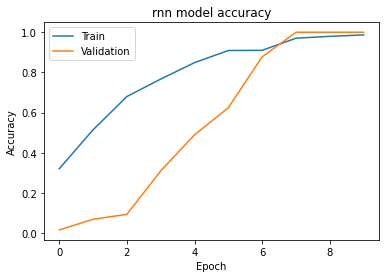

Training cnn model...
Epoch 1/10
31/31 [==============================] - 4s 111ms/step - loss: 0.6596 - accuracy: 0.1665 - val_loss: 0.5551 - val_accuracy: 0.0000e+00
Epoch 2/10
31/31 [==============================] - 3s 110ms/step - loss: 0.5540 - accuracy: 0.2901 - val_loss: 0.8239 - val_accuracy: 0.1388
Epoch 3/10
31/31 [==============================] - 3s 104ms/step - loss: 0.5391 - accuracy: 0.3606 - val_loss: 0.7848 - val_accuracy: 0.0245
Epoch 4/10
31/31 [==============================] - 3s 104ms/step - loss: 0.5060 - accuracy: 0.4688 - val_loss: 0.7792 - val_accuracy: 0.1306
Epoch 5/10
31/31 [==============================] - 3s 106ms/step - loss: 0.4108 - accuracy: 0.6374 - val_loss: 0.8030 - val_accuracy: 0.1224
Epoch 6/10
31/31 [==============================] - 3s 107ms/step - loss: 0.3102 - accuracy: 0.7681 - val_loss: 0.5379 - val_accuracy: 0.2653
Epoch 7/10
31/31 [==============================] - 3s 110ms/step - loss: 0.2249 - accuracy: 0.8315 - val_loss: 0.4589 - v

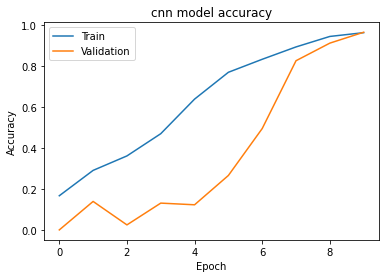

Training lstm model...
Epoch 1/10


2023-03-30 00:12:27.552060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:12:27.553424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:12:27.554429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.3340

2023-03-30 00:12:33.261376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:12:33.262627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:12:33.263547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 6s 154ms/step - loss: 0.5797 - accuracy: 0.3340 - val_loss: 0.7773 - val_accuracy: 0.0122
Epoch 2/10
31/31 [==============================] - 4s 145ms/step - loss: 0.5158 - accuracy: 0.4505 - val_loss: 0.7544 - val_accuracy: 0.0490
Epoch 3/10
31/31 [==============================] - 4s 145ms/step - loss: 0.3894 - accuracy: 0.6650 - val_loss: 0.7213 - val_accuracy: 0.1306
Epoch 4/10
31/31 [==============================] - 5s 150ms/step - loss: 0.2897 - accuracy: 0.7722 - val_loss: 0.5361 - val_accuracy: 0.3306
Epoch 5/10
31/31 [==============================] - 5s 149ms/step - loss: 0.2128 - accuracy: 0.8468 - val_loss: 0.3229 - val_accuracy: 0.7510
Epoch 6/10
31/31 [==============================] - 5s 148ms/step - loss: 0.1583 - accuracy: 0.8958 - val_loss: 0.1773 - val_accuracy: 0.8857
Epoch 7/10
31/31 [==============================] - 5s 148ms/step - loss: 0.1027 - accuracy: 0.9428 - val_loss: 0.1247 - val_accuracy: 0.8980
Epoch 8/10
31/31 

2023-03-30 00:13:14.999045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:13:15.000174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:13:15.001105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 16ms/step
lstm model confusion matrix:
[[37  2  3  1]
 [ 5 49 12  1]
 [10  9 53  0]
 [ 1  1  0 16]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.70      0.86      0.77        43
           1       0.80      0.73      0.77        67
           2       0.78      0.74      0.76        72
           3       0.89      0.89      0.89        18

    accuracy                           0.78       200
   macro avg       0.79      0.80      0.80       200
weighted avg       0.78      0.78      0.77       200

lstm model accuracy: 0.7750
lstm model precision: 0.7924
lstm model recall: 0.8042


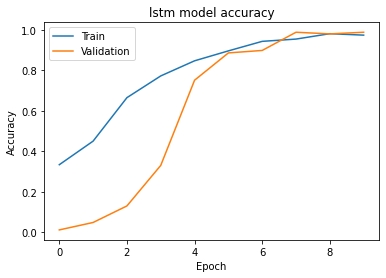

Training bilstm model...
Epoch 1/10


2023-03-30 00:13:15.485535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:13:15.487113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:13:15.488429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.3279

2023-03-30 00:13:23.411680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:13:23.413119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:13:23.414064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 9s 208ms/step - loss: 0.5737 - accuracy: 0.3279 - val_loss: 0.7740 - val_accuracy: 0.0000e+00
Epoch 2/10
31/31 [==============================] - 6s 196ms/step - loss: 0.4917 - accuracy: 0.4903 - val_loss: 0.7874 - val_accuracy: 0.0898
Epoch 3/10
31/31 [==============================] - 6s 187ms/step - loss: 0.3810 - accuracy: 0.6609 - val_loss: 0.6924 - val_accuracy: 0.1184
Epoch 4/10
31/31 [==============================] - 6s 186ms/step - loss: 0.3079 - accuracy: 0.7457 - val_loss: 0.6903 - val_accuracy: 0.1347
Epoch 5/10
31/31 [==============================] - 6s 186ms/step - loss: 0.2249 - accuracy: 0.8151 - val_loss: 0.4101 - val_accuracy: 0.6204
Epoch 6/10
31/31 [==============================] - 6s 197ms/step - loss: 0.1616 - accuracy: 0.8836 - val_loss: 0.3847 - val_accuracy: 0.7061
Epoch 7/10
31/31 [==============================] - 6s 208ms/step - loss: 0.1003 - accuracy: 0.9336 - val_loss: 0.1905 - val_accuracy: 0.9143
Epoch 8/10
31

2023-03-30 00:14:17.660194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:14:17.661162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:14:17.662396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 22ms/step
bilstm model confusion matrix:
[[35  0  6  2]
 [ 3 45 18  1]
 [ 7  8 57  0]
 [ 1  0  1 16]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        43
           1       0.85      0.67      0.75        67
           2       0.70      0.79      0.74        72
           3       0.84      0.89      0.86        18

    accuracy                           0.77       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.77      0.77      0.76       200

bilstm model accuracy: 0.7650
bilstm model precision: 0.7868
bilstm model recall: 0.7915


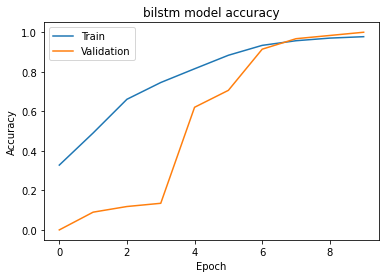

In [38]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# UNDERSAMPLING DATASET AND ENCODING Y LABELS

In [39]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# DEFINE THE NEURAL NETWORK MODELS WITH BEST PARAMS PASSED (UNDERSAMPLED)

In [40]:
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=50000, embedding_size=128, filter_size=32, kernel_size=5, pool_size=3, dense_size=128, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.2, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# RUNNING MODELS ON UNDERSAMPLED DATASET AND PERFORMANCE ANALYSIS

2023-03-30 00:14:18.487070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:14:18.488251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:14:18.489359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/10


2023-03-30 00:14:18.784442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 00:14:18.817623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:14:18.818916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

10/10 [==============================] - 1s 65ms/step - loss: 0.6400 - accuracy: 0.3026 - val_loss: 0.6871 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 44ms/step - loss: 0.5414 - accuracy: 0.3487 - val_loss: 0.8903 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 0s 43ms/step - loss: 0.5315 - accuracy: 0.3487 - val_loss: 0.9563 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 0s 43ms/step - loss: 0.5155 - accuracy: 0.4046 - val_loss: 0.8347 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 0s 44ms/step - loss: 0.4876 - accuracy: 0.4967 - val_loss: 0.9039 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 0s 44ms/step - loss: 0.4672 - accuracy: 0.6217 - val_loss: 0.8667 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 0s 43ms/step - loss: 0.4219 - accuracy: 0.7336 - val_loss: 0.8464 - val_accuracy: 0.0000e

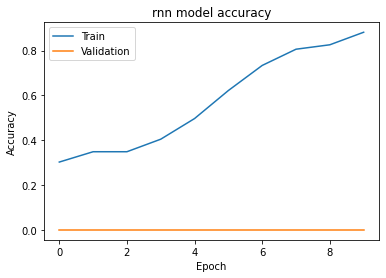

Training cnn model...
Epoch 1/10
10/10 [==============================] - 2s 118ms/step - loss: 0.6739 - accuracy: 0.2599 - val_loss: 0.6692 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 105ms/step - loss: 0.5772 - accuracy: 0.3257 - val_loss: 0.7579 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 104ms/step - loss: 0.5383 - accuracy: 0.3158 - val_loss: 0.9326 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 105ms/step - loss: 0.5355 - accuracy: 0.3158 - val_loss: 0.9209 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 1s 106ms/step - loss: 0.5249 - accuracy: 0.3783 - val_loss: 0.9552 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 1s 105ms/step - loss: 0.5239 - accuracy: 0.3914 - val_loss: 0.9294 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 106ms/step - loss: 0.5029 - accuracy: 0.4770 - 

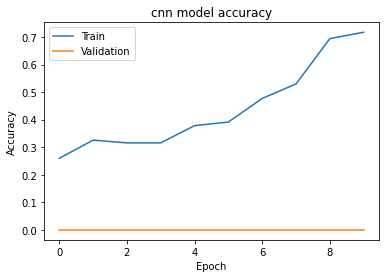

Training lstm model...
Epoch 1/10


2023-03-30 00:14:36.107194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:14:36.108449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:14:36.109374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 3s 176ms/step - loss: 0.6460 - accuracy: 0.2862 - val_loss: 0.9623 - val_accuracy: 0.0000e+00
Epoch 2/10


2023-03-30 00:14:38.833356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:14:38.835082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:14:38.836065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 145ms/step - loss: 0.5515 - accuracy: 0.3059 - val_loss: 0.8841 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 147ms/step - loss: 0.5325 - accuracy: 0.3618 - val_loss: 0.9313 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 146ms/step - loss: 0.5268 - accuracy: 0.3553 - val_loss: 0.9179 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 1s 147ms/step - loss: 0.5149 - accuracy: 0.4474 - val_loss: 0.8965 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 2s 153ms/step - loss: 0.4976 - accuracy: 0.5362 - val_loss: 0.9315 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 148ms/step - loss: 0.4536 - accuracy: 0.6283 - val_loss: 0.8206 - val_accuracy: 0.0000e+00
Epoch 8/10
10/10 [==============================] - 1s 146ms/step - loss: 0.3863 - accuracy: 0.6974 - val_loss: 0.9525 - val_accuracy: 

2023-03-30 00:14:52.401286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:14:52.402804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:14:52.404011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 16ms/step
lstm model confusion matrix:
[[34  3  6  0]
 [ 4 49 14  0]
 [ 8 15 49  0]
 [ 2 13  3  0]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        43
           1       0.61      0.73      0.67        67
           2       0.68      0.68      0.68        72
           3       0.00      0.00      0.00        18

    accuracy                           0.66       200
   macro avg       0.50      0.55      0.52       200
weighted avg       0.60      0.66      0.63       200

lstm model accuracy: 0.6600
lstm model precision: 0.5003
lstm model recall: 0.5506


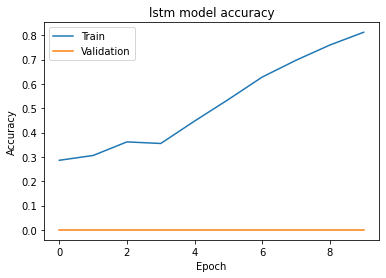

Training bilstm model...
Epoch 1/10


2023-03-30 00:14:52.894809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:14:52.896290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:14:52.897220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.3125

2023-03-30 00:14:57.181136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:14:57.182066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:14:57.183116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 5s 234ms/step - loss: 0.6590 - accuracy: 0.3125 - val_loss: 0.8069 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 2s 193ms/step - loss: 0.5424 - accuracy: 0.3454 - val_loss: 0.9043 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 2s 195ms/step - loss: 0.5412 - accuracy: 0.3059 - val_loss: 0.9133 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 2s 190ms/step - loss: 0.5240 - accuracy: 0.3882 - val_loss: 0.9182 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 2s 190ms/step - loss: 0.5047 - accuracy: 0.5099 - val_loss: 0.8945 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 2s 185ms/step - loss: 0.4565 - accuracy: 0.6546 - val_loss: 0.8940 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 2s 186ms/step - loss: 0.3856 - accuracy: 0.7007 - val_loss: 1.0721 - val_accuracy: 

2023-03-30 00:15:14.696157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 00:15:14.697525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 00:15:14.698426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 21ms/step
bilstm model confusion matrix:
[[37  3  3  0]
 [ 6 52  9  0]
 [13 18 41  0]
 [ 3 14  1  0]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.63      0.86      0.73        43
           1       0.60      0.78      0.68        67
           2       0.76      0.57      0.65        72
           3       0.00      0.00      0.00        18

    accuracy                           0.65       200
   macro avg       0.50      0.55      0.51       200
weighted avg       0.61      0.65      0.62       200

bilstm model accuracy: 0.6500
bilstm model precision: 0.4960
bilstm model recall: 0.5515


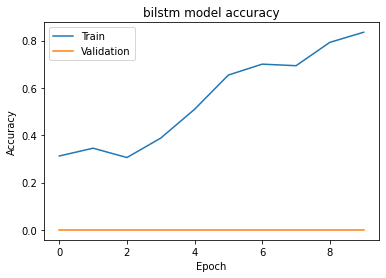

In [41]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()